In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards_in + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:0.6865 eloss:9.4895 aloss2:3.8739 exploreP:0.9980
Episode:1 meanR:20.5000 R:21.0000 rate:0.0420 aloss:0.6864 eloss:9.4684 aloss2:3.7700 exploreP:0.9959
Episode:2 meanR:31.6667 R:54.0000 rate:0.1080 aloss:0.6827 eloss:9.6181 aloss2:3.8222 exploreP:0.9906
Episode:3 meanR:31.7500 R:32.0000 rate:0.0640 aloss:0.6850 eloss:9.5099 aloss2:3.6715 exploreP:0.9875
Episode:4 meanR:28.0000 R:13.0000 rate:0.0260 aloss:0.6963 eloss:9.3468 aloss2:3.6540 exploreP:0.9862
Episode:5 meanR:26.3333 R:18.0000 rate:0.0360 aloss:0.6830 eloss:9.6061 aloss2:3.6532 exploreP:0.9845
Episode:6 meanR:26.8571 R:30.0000 rate:0.0600 aloss:0.6860 eloss:9.7184 aloss2:3.7325 exploreP:0.9816
Episode:7 meanR:29.7500 R:50.0000 rate:0.1000 aloss:0.6819 eloss:9.6526 aloss2:3.6922 exploreP:0.9767
Episode:8 meanR:28.1111 R:15.0000 rate:0.0300 aloss:0.6843 eloss:9.5060 aloss2:3.6282 exploreP:0.9753
Episode:9 meanR:27.1000 R:18.0000 rate:0.0360 aloss:0.6813 eloss:9.6062 aloss2:3.6

Episode:80 meanR:24.3704 R:22.0000 rate:0.0440 aloss:0.6899 eloss:8.2260 aloss2:4.9202 exploreP:0.8227
Episode:81 meanR:24.2683 R:16.0000 rate:0.0320 aloss:0.6798 eloss:8.2394 aloss2:4.8409 exploreP:0.8214
Episode:82 meanR:24.3494 R:31.0000 rate:0.0620 aloss:0.6866 eloss:8.1451 aloss2:4.8540 exploreP:0.8188
Episode:83 meanR:24.4643 R:34.0000 rate:0.0680 aloss:0.6850 eloss:8.1298 aloss2:4.9613 exploreP:0.8161
Episode:84 meanR:24.5176 R:29.0000 rate:0.0580 aloss:0.6829 eloss:8.0588 aloss2:4.9183 exploreP:0.8138
Episode:85 meanR:24.4651 R:20.0000 rate:0.0400 aloss:0.6878 eloss:8.0405 aloss2:4.9479 exploreP:0.8122
Episode:86 meanR:24.4253 R:21.0000 rate:0.0420 aloss:0.6840 eloss:8.0499 aloss2:5.0198 exploreP:0.8105
Episode:87 meanR:24.5795 R:38.0000 rate:0.0760 aloss:0.6814 eloss:7.8961 aloss2:4.9134 exploreP:0.8074
Episode:88 meanR:24.5730 R:24.0000 rate:0.0480 aloss:0.6751 eloss:7.9701 aloss2:4.9345 exploreP:0.8055
Episode:89 meanR:24.6778 R:34.0000 rate:0.0680 aloss:0.6781 eloss:7.9128 

Episode:159 meanR:45.2500 R:82.0000 rate:0.1640 aloss:0.6909 eloss:6.5028 aloss2:7.3416 exploreP:0.5583
Episode:160 meanR:46.3200 R:124.0000 rate:0.2480 aloss:0.7074 eloss:6.5423 aloss2:7.4713 exploreP:0.5516
Episode:161 meanR:47.0700 R:94.0000 rate:0.1880 aloss:0.6970 eloss:6.4047 aloss2:7.5868 exploreP:0.5465
Episode:162 meanR:47.4100 R:49.0000 rate:0.0980 aloss:0.6909 eloss:6.3726 aloss2:7.7000 exploreP:0.5439
Episode:163 meanR:47.8600 R:60.0000 rate:0.1200 aloss:0.7029 eloss:6.3944 aloss2:7.6498 exploreP:0.5407
Episode:164 meanR:48.2000 R:72.0000 rate:0.1440 aloss:0.6862 eloss:6.3082 aloss2:7.7537 exploreP:0.5369
Episode:165 meanR:48.8100 R:88.0000 rate:0.1760 aloss:0.6990 eloss:6.2768 aloss2:7.8743 exploreP:0.5323
Episode:166 meanR:49.5300 R:90.0000 rate:0.1800 aloss:0.7238 eloss:6.3204 aloss2:7.9926 exploreP:0.5276
Episode:167 meanR:49.1000 R:55.0000 rate:0.1100 aloss:0.6914 eloss:6.1922 aloss2:8.1316 exploreP:0.5248
Episode:168 meanR:49.7400 R:87.0000 rate:0.1740 aloss:0.7107 el

Episode:238 meanR:77.6400 R:39.0000 rate:0.0780 aloss:0.6713 eloss:2.5316 aloss2:19.5833 exploreP:0.2969
Episode:239 meanR:77.2200 R:42.0000 rate:0.0840 aloss:0.6835 eloss:3.5429 aloss2:19.9886 exploreP:0.2957
Episode:240 meanR:78.3600 R:130.0000 rate:0.2600 aloss:0.6774 eloss:3.2300 aloss2:19.9767 exploreP:0.2921
Episode:241 meanR:78.5500 R:48.0000 rate:0.0960 aloss:0.6737 eloss:3.4246 aloss2:20.4489 exploreP:0.2907
Episode:242 meanR:78.2000 R:57.0000 rate:0.1140 aloss:0.6723 eloss:2.7974 aloss2:20.4042 exploreP:0.2891
Episode:243 meanR:77.5300 R:76.0000 rate:0.1520 aloss:0.6758 eloss:2.4849 aloss2:20.3939 exploreP:0.2870
Episode:244 meanR:77.8500 R:63.0000 rate:0.1260 aloss:0.6764 eloss:2.5698 aloss2:20.5934 exploreP:0.2853
Episode:245 meanR:78.3600 R:65.0000 rate:0.1300 aloss:0.6824 eloss:2.9552 aloss2:20.8336 exploreP:0.2835
Episode:246 meanR:77.7900 R:60.0000 rate:0.1200 aloss:0.6808 eloss:3.1405 aloss2:20.9178 exploreP:0.2818
Episode:247 meanR:78.1000 R:44.0000 rate:0.0880 aloss:

Episode:317 meanR:55.2000 R:62.0000 rate:0.1240 aloss:0.6749 eloss:2.0343 aloss2:28.2350 exploreP:0.1997
Episode:318 meanR:55.2100 R:59.0000 rate:0.1180 aloss:0.6789 eloss:2.4935 aloss2:28.5432 exploreP:0.1986
Episode:319 meanR:55.0800 R:44.0000 rate:0.0880 aloss:0.6789 eloss:1.0902 aloss2:28.6043 exploreP:0.1977
Episode:320 meanR:54.3800 R:28.0000 rate:0.0560 aloss:0.6857 eloss:0.8452 aloss2:28.3168 exploreP:0.1972
Episode:321 meanR:53.9700 R:49.0000 rate:0.0980 aloss:0.6730 eloss:0.9139 aloss2:28.5064 exploreP:0.1963
Episode:322 meanR:53.9300 R:39.0000 rate:0.0780 aloss:0.6758 eloss:1.1300 aloss2:28.4153 exploreP:0.1956
Episode:323 meanR:53.4800 R:48.0000 rate:0.0960 aloss:0.6705 eloss:1.0897 aloss2:28.9263 exploreP:0.1947
Episode:324 meanR:53.7600 R:69.0000 rate:0.1380 aloss:0.6747 eloss:1.3531 aloss2:28.6971 exploreP:0.1934
Episode:325 meanR:52.5900 R:18.0000 rate:0.0360 aloss:0.6820 eloss:1.8169 aloss2:28.7349 exploreP:0.1931
Episode:326 meanR:52.9600 R:66.0000 rate:0.1320 aloss:0

Episode:396 meanR:54.7000 R:64.0000 rate:0.1280 aloss:0.6679 eloss:0.1016 aloss2:33.6420 exploreP:0.1327
Episode:397 meanR:54.5800 R:46.0000 rate:0.0920 aloss:0.6709 eloss:0.3118 aloss2:33.8795 exploreP:0.1322
Episode:398 meanR:54.5900 R:46.0000 rate:0.0920 aloss:0.6699 eloss:-0.2487 aloss2:33.6801 exploreP:0.1316
Episode:399 meanR:54.4000 R:54.0000 rate:0.1080 aloss:0.6646 eloss:0.4342 aloss2:33.9029 exploreP:0.1309
Episode:400 meanR:54.4000 R:56.0000 rate:0.1120 aloss:0.6721 eloss:0.0595 aloss2:34.2743 exploreP:0.1303
Episode:401 meanR:54.5300 R:59.0000 rate:0.1180 aloss:0.6732 eloss:-0.0775 aloss2:34.0843 exploreP:0.1296
Episode:402 meanR:54.7200 R:58.0000 rate:0.1160 aloss:0.6671 eloss:0.0604 aloss2:34.3035 exploreP:0.1289
Episode:403 meanR:55.0600 R:63.0000 rate:0.1260 aloss:0.6729 eloss:0.1832 aloss2:34.3808 exploreP:0.1281
Episode:404 meanR:54.9900 R:51.0000 rate:0.1020 aloss:0.6572 eloss:-0.0075 aloss2:34.6948 exploreP:0.1275
Episode:405 meanR:54.8500 R:37.0000 rate:0.0740 alos

Episode:474 meanR:68.0500 R:82.0000 rate:0.1640 aloss:0.6632 eloss:-0.5624 aloss2:38.9432 exploreP:0.0811
Episode:475 meanR:68.2900 R:67.0000 rate:0.1340 aloss:0.6665 eloss:1.3842 aloss2:38.6851 exploreP:0.0806
Episode:476 meanR:68.1500 R:61.0000 rate:0.1220 aloss:0.6634 eloss:2.3732 aloss2:38.3696 exploreP:0.0802
Episode:477 meanR:68.0800 R:57.0000 rate:0.1140 aloss:0.6577 eloss:3.0072 aloss2:39.2739 exploreP:0.0798
Episode:478 meanR:68.1700 R:69.0000 rate:0.1380 aloss:0.6700 eloss:-0.0434 aloss2:38.4223 exploreP:0.0793
Episode:479 meanR:68.2000 R:58.0000 rate:0.1160 aloss:0.6617 eloss:-0.2743 aloss2:38.9629 exploreP:0.0789
Episode:480 meanR:68.4100 R:70.0000 rate:0.1400 aloss:0.6702 eloss:-0.0984 aloss2:38.7738 exploreP:0.0784
Episode:481 meanR:68.7400 R:76.0000 rate:0.1520 aloss:0.6611 eloss:0.1491 aloss2:39.0530 exploreP:0.0779
Episode:482 meanR:68.9500 R:80.0000 rate:0.1600 aloss:0.6662 eloss:0.2173 aloss2:38.5656 exploreP:0.0774
Episode:483 meanR:69.2700 R:79.0000 rate:0.1580 alo

Episode:552 meanR:76.3300 R:89.0000 rate:0.1780 aloss:0.6604 eloss:2.7219 aloss2:41.0212 exploreP:0.0488
Episode:553 meanR:76.6800 R:102.0000 rate:0.2040 aloss:0.6693 eloss:-0.1796 aloss2:41.1576 exploreP:0.0485
Episode:554 meanR:76.4600 R:71.0000 rate:0.1420 aloss:0.6574 eloss:-0.6009 aloss2:41.0293 exploreP:0.0482
Episode:555 meanR:76.4400 R:91.0000 rate:0.1820 aloss:0.6602 eloss:-0.4298 aloss2:41.1395 exploreP:0.0478
Episode:556 meanR:76.4300 R:62.0000 rate:0.1240 aloss:0.6474 eloss:-0.9720 aloss2:40.9675 exploreP:0.0476
Episode:557 meanR:76.6400 R:83.0000 rate:0.1660 aloss:0.6551 eloss:-0.5149 aloss2:41.3799 exploreP:0.0473
Episode:558 meanR:76.7000 R:79.0000 rate:0.1580 aloss:0.6422 eloss:-0.2803 aloss2:41.1850 exploreP:0.0470
Episode:559 meanR:76.8100 R:73.0000 rate:0.1460 aloss:0.6434 eloss:-1.0773 aloss2:41.3156 exploreP:0.0467
Episode:560 meanR:76.7700 R:62.0000 rate:0.1240 aloss:0.6621 eloss:-1.1368 aloss2:41.3553 exploreP:0.0465
Episode:561 meanR:76.7100 R:83.0000 rate:0.166

Episode:630 meanR:83.3400 R:73.0000 rate:0.1460 aloss:0.6599 eloss:-0.4049 aloss2:44.1054 exploreP:0.0301
Episode:631 meanR:83.5600 R:75.0000 rate:0.1500 aloss:0.6561 eloss:0.6892 aloss2:44.0972 exploreP:0.0299
Episode:632 meanR:83.5700 R:64.0000 rate:0.1280 aloss:0.6410 eloss:1.2490 aloss2:44.2776 exploreP:0.0298
Episode:633 meanR:83.0300 R:70.0000 rate:0.1400 aloss:0.6535 eloss:4.6247 aloss2:43.9231 exploreP:0.0297
Episode:634 meanR:82.8500 R:70.0000 rate:0.1400 aloss:0.6530 eloss:1.0612 aloss2:43.5800 exploreP:0.0295
Episode:635 meanR:82.9600 R:79.0000 rate:0.1580 aloss:0.6592 eloss:0.9233 aloss2:43.8338 exploreP:0.0294
Episode:636 meanR:82.8900 R:75.0000 rate:0.1500 aloss:0.6564 eloss:2.6326 aloss2:44.0963 exploreP:0.0292
Episode:637 meanR:82.8800 R:97.0000 rate:0.1940 aloss:0.6524 eloss:-0.0797 aloss2:43.6181 exploreP:0.0291
Episode:638 meanR:82.6800 R:59.0000 rate:0.1180 aloss:0.6304 eloss:-0.7107 aloss2:43.6954 exploreP:0.0290
Episode:639 meanR:82.6600 R:93.0000 rate:0.1860 alos

Episode:708 meanR:81.8700 R:73.0000 rate:0.1460 aloss:0.6440 eloss:-1.0259 aloss2:45.5779 exploreP:0.0206
Episode:709 meanR:81.9100 R:69.0000 rate:0.1380 aloss:0.6396 eloss:-0.1750 aloss2:45.4460 exploreP:0.0205
Episode:710 meanR:81.7100 R:75.0000 rate:0.1500 aloss:0.6307 eloss:-0.8189 aloss2:44.8983 exploreP:0.0204
Episode:711 meanR:81.9700 R:113.0000 rate:0.2260 aloss:0.6436 eloss:-1.5825 aloss2:45.8075 exploreP:0.0203
Episode:712 meanR:81.2600 R:64.0000 rate:0.1280 aloss:0.6266 eloss:0.5415 aloss2:45.9703 exploreP:0.0202
Episode:713 meanR:81.6300 R:101.0000 rate:0.2020 aloss:0.6168 eloss:-1.0832 aloss2:45.7858 exploreP:0.0201
Episode:714 meanR:81.8400 R:109.0000 rate:0.2180 aloss:0.6256 eloss:-0.8980 aloss2:45.6473 exploreP:0.0200
Episode:715 meanR:81.7400 R:58.0000 rate:0.1160 aloss:0.6301 eloss:-1.8869 aloss2:45.4620 exploreP:0.0199
Episode:716 meanR:81.6000 R:61.0000 rate:0.1220 aloss:0.6317 eloss:4.9033 aloss2:46.1269 exploreP:0.0199
Episode:717 meanR:81.5500 R:70.0000 rate:0.14

Episode:786 meanR:85.0100 R:90.0000 rate:0.1800 aloss:0.6257 eloss:1.8816 aloss2:47.5368 exploreP:0.0154
Episode:787 meanR:84.8500 R:62.0000 rate:0.1240 aloss:0.6154 eloss:-1.6498 aloss2:47.8515 exploreP:0.0154
Episode:788 meanR:84.7600 R:68.0000 rate:0.1360 aloss:0.6100 eloss:0.1426 aloss2:46.5735 exploreP:0.0154
Episode:789 meanR:84.7000 R:61.0000 rate:0.1220 aloss:0.6193 eloss:1.0855 aloss2:47.2605 exploreP:0.0153
Episode:790 meanR:84.4700 R:75.0000 rate:0.1500 aloss:0.6444 eloss:-1.4709 aloss2:47.4211 exploreP:0.0153
Episode:791 meanR:84.6800 R:79.0000 rate:0.1580 aloss:0.6161 eloss:-1.8756 aloss2:47.4897 exploreP:0.0153
Episode:792 meanR:84.2600 R:63.0000 rate:0.1260 aloss:0.6170 eloss:-1.4924 aloss2:47.1054 exploreP:0.0152
Episode:793 meanR:84.1200 R:73.0000 rate:0.1460 aloss:0.6113 eloss:-0.6610 aloss2:47.5607 exploreP:0.0152
Episode:794 meanR:84.0600 R:64.0000 rate:0.1280 aloss:0.6177 eloss:-1.5685 aloss2:47.3470 exploreP:0.0151
Episode:795 meanR:83.8200 R:69.0000 rate:0.1380 a

Episode:864 meanR:80.1600 R:101.0000 rate:0.2020 aloss:0.5851 eloss:-2.6768 aloss2:50.1823 exploreP:0.0129
Episode:865 meanR:80.3400 R:79.0000 rate:0.1580 aloss:0.5998 eloss:-1.8123 aloss2:50.2866 exploreP:0.0129
Episode:866 meanR:80.2700 R:66.0000 rate:0.1320 aloss:0.5988 eloss:0.3884 aloss2:50.4159 exploreP:0.0129
Episode:867 meanR:79.6500 R:73.0000 rate:0.1460 aloss:0.5916 eloss:-1.7063 aloss2:50.2837 exploreP:0.0129
Episode:868 meanR:79.2400 R:68.0000 rate:0.1360 aloss:0.6213 eloss:2.5828 aloss2:50.0249 exploreP:0.0129
Episode:869 meanR:78.5300 R:69.0000 rate:0.1380 aloss:0.6144 eloss:0.7076 aloss2:50.1103 exploreP:0.0128
Episode:870 meanR:77.8200 R:67.0000 rate:0.1340 aloss:0.6005 eloss:-2.8968 aloss2:49.8654 exploreP:0.0128
Episode:871 meanR:77.3700 R:71.0000 rate:0.1420 aloss:0.5926 eloss:-2.2826 aloss2:50.3227 exploreP:0.0128
Episode:872 meanR:77.2500 R:53.0000 rate:0.1060 aloss:0.6041 eloss:1.0655 aloss2:50.3809 exploreP:0.0128
Episode:873 meanR:77.0000 R:69.0000 rate:0.1380 a

Episode:942 meanR:79.1400 R:63.0000 rate:0.1260 aloss:0.5738 eloss:-1.7864 aloss2:52.2932 exploreP:0.0116
Episode:943 meanR:79.1100 R:62.0000 rate:0.1240 aloss:0.5946 eloss:3.0900 aloss2:52.6818 exploreP:0.0116
Episode:944 meanR:78.7800 R:83.0000 rate:0.1660 aloss:0.5773 eloss:-2.5817 aloss2:52.4069 exploreP:0.0116
Episode:945 meanR:78.9200 R:85.0000 rate:0.1700 aloss:0.5875 eloss:-2.6621 aloss2:52.4286 exploreP:0.0116
Episode:946 meanR:79.8100 R:158.0000 rate:0.3160 aloss:0.5823 eloss:-1.7197 aloss2:52.5423 exploreP:0.0115
Episode:947 meanR:79.7800 R:62.0000 rate:0.1240 aloss:0.5752 eloss:-0.1066 aloss2:52.6299 exploreP:0.0115
Episode:948 meanR:79.7900 R:68.0000 rate:0.1360 aloss:0.5331 eloss:-3.8116 aloss2:52.5778 exploreP:0.0115
Episode:949 meanR:79.8000 R:133.0000 rate:0.2660 aloss:0.5740 eloss:-1.4473 aloss2:52.6660 exploreP:0.0115
Episode:950 meanR:79.8100 R:61.0000 rate:0.1220 aloss:0.5515 eloss:-3.2795 aloss2:52.9392 exploreP:0.0115
Episode:951 meanR:80.2300 R:99.0000 rate:0.19

Episode:1020 meanR:77.2400 R:69.0000 rate:0.1380 aloss:0.5835 eloss:-0.6590 aloss2:55.4555 exploreP:0.0109
Episode:1021 meanR:77.2700 R:69.0000 rate:0.1380 aloss:0.5541 eloss:-3.5261 aloss2:55.5876 exploreP:0.0109
Episode:1022 meanR:77.3200 R:66.0000 rate:0.1320 aloss:0.5783 eloss:-3.0504 aloss2:55.6384 exploreP:0.0109
Episode:1023 meanR:77.5000 R:81.0000 rate:0.1620 aloss:0.5703 eloss:-0.7489 aloss2:56.1654 exploreP:0.0108
Episode:1024 meanR:77.3400 R:56.0000 rate:0.1120 aloss:0.5510 eloss:3.7944 aloss2:55.9340 exploreP:0.0108
Episode:1025 meanR:77.4600 R:68.0000 rate:0.1360 aloss:0.5466 eloss:-3.1417 aloss2:55.3967 exploreP:0.0108
Episode:1026 meanR:77.4300 R:81.0000 rate:0.1620 aloss:0.5476 eloss:-2.3412 aloss2:55.5236 exploreP:0.0108
Episode:1027 meanR:77.3500 R:73.0000 rate:0.1460 aloss:0.5560 eloss:-2.9949 aloss2:55.9635 exploreP:0.0108
Episode:1028 meanR:77.3700 R:79.0000 rate:0.1580 aloss:0.5228 eloss:-3.9499 aloss2:56.0056 exploreP:0.0108
Episode:1029 meanR:77.8400 R:106.0000 

Episode:1097 meanR:87.0400 R:68.0000 rate:0.1360 aloss:0.5211 eloss:0.0429 aloss2:57.1167 exploreP:0.0104
Episode:1098 meanR:86.8100 R:88.0000 rate:0.1760 aloss:0.5208 eloss:-3.1317 aloss2:57.3004 exploreP:0.0104
Episode:1099 meanR:86.9400 R:80.0000 rate:0.1600 aloss:0.4974 eloss:1.0067 aloss2:56.9692 exploreP:0.0104
Episode:1100 meanR:87.1300 R:90.0000 rate:0.1800 aloss:0.5103 eloss:-3.5458 aloss2:57.2506 exploreP:0.0104
Episode:1101 meanR:88.0200 R:150.0000 rate:0.3000 aloss:0.5273 eloss:-1.8623 aloss2:57.1711 exploreP:0.0104
Episode:1102 meanR:87.6300 R:58.0000 rate:0.1160 aloss:0.5350 eloss:-4.4552 aloss2:57.4278 exploreP:0.0104
Episode:1103 meanR:87.3500 R:62.0000 rate:0.1240 aloss:0.5337 eloss:-3.3937 aloss2:57.8220 exploreP:0.0104
Episode:1104 meanR:87.3100 R:63.0000 rate:0.1260 aloss:0.5075 eloss:-2.8941 aloss2:57.3327 exploreP:0.0104
Episode:1105 meanR:87.3000 R:68.0000 rate:0.1360 aloss:0.5088 eloss:-3.5303 aloss2:57.7430 exploreP:0.0104
Episode:1106 meanR:86.6300 R:55.0000 r

Episode:1174 meanR:88.9500 R:73.0000 rate:0.1460 aloss:0.5104 eloss:-1.5268 aloss2:60.3283 exploreP:0.0102
Episode:1175 meanR:89.1100 R:77.0000 rate:0.1540 aloss:0.5064 eloss:-4.5677 aloss2:60.7753 exploreP:0.0102
Episode:1176 meanR:89.6700 R:117.0000 rate:0.2340 aloss:0.4942 eloss:-4.5711 aloss2:60.8556 exploreP:0.0102
Episode:1177 meanR:89.8000 R:71.0000 rate:0.1420 aloss:0.4987 eloss:-3.4377 aloss2:60.7226 exploreP:0.0102
Episode:1178 meanR:89.7700 R:70.0000 rate:0.1400 aloss:0.4872 eloss:-4.1546 aloss2:60.9101 exploreP:0.0102
Episode:1179 meanR:89.7700 R:66.0000 rate:0.1320 aloss:0.4920 eloss:-5.3666 aloss2:61.3167 exploreP:0.0102
Episode:1180 meanR:89.6800 R:83.0000 rate:0.1660 aloss:0.4627 eloss:-5.0117 aloss2:61.4909 exploreP:0.0102
Episode:1181 meanR:88.3500 R:69.0000 rate:0.1380 aloss:0.4561 eloss:-2.7728 aloss2:61.4404 exploreP:0.0102
Episode:1182 meanR:88.2900 R:67.0000 rate:0.1340 aloss:0.4905 eloss:-4.7440 aloss2:61.5587 exploreP:0.0102
Episode:1183 meanR:88.2700 R:89.0000

Episode:1251 meanR:100.2500 R:138.0000 rate:0.2760 aloss:0.4636 eloss:-0.7756 aloss2:66.2376 exploreP:0.0101
Episode:1252 meanR:101.5400 R:295.0000 rate:0.5900 aloss:0.4719 eloss:-5.2710 aloss2:66.6191 exploreP:0.0101
Episode:1253 meanR:101.0300 R:115.0000 rate:0.2300 aloss:0.4869 eloss:-4.1203 aloss2:67.0198 exploreP:0.0101
Episode:1254 meanR:101.2100 R:93.0000 rate:0.1860 aloss:0.4896 eloss:-0.1463 aloss2:66.5430 exploreP:0.0101
Episode:1255 meanR:101.8200 R:134.0000 rate:0.2680 aloss:0.4622 eloss:-3.5352 aloss2:66.5087 exploreP:0.0101
Episode:1256 meanR:102.7700 R:171.0000 rate:0.3420 aloss:0.4816 eloss:-5.2065 aloss2:67.6344 exploreP:0.0101
Episode:1257 meanR:103.1800 R:104.0000 rate:0.2080 aloss:0.4717 eloss:-3.3886 aloss2:66.4173 exploreP:0.0101
Episode:1258 meanR:104.8800 R:266.0000 rate:0.5320 aloss:0.4996 eloss:-2.4912 aloss2:67.3490 exploreP:0.0101
Episode:1259 meanR:104.6500 R:94.0000 rate:0.1880 aloss:0.4936 eloss:-0.3407 aloss2:67.2894 exploreP:0.0101
Episode:1260 meanR:10

Episode:1327 meanR:138.5000 R:83.0000 rate:0.1660 aloss:0.4529 eloss:-7.8369 aloss2:79.9128 exploreP:0.0100
Episode:1328 meanR:138.2200 R:115.0000 rate:0.2300 aloss:0.4614 eloss:-5.1593 aloss2:80.2909 exploreP:0.0100
Episode:1329 meanR:139.4700 R:201.0000 rate:0.4020 aloss:0.4587 eloss:-4.0838 aloss2:79.3257 exploreP:0.0100
Episode:1330 meanR:141.0600 R:282.0000 rate:0.5640 aloss:0.4626 eloss:-7.9569 aloss2:80.9858 exploreP:0.0100
Episode:1331 meanR:140.9100 R:74.0000 rate:0.1480 aloss:0.4558 eloss:-6.8001 aloss2:81.3666 exploreP:0.0100
Episode:1332 meanR:142.6700 R:258.0000 rate:0.5160 aloss:0.4728 eloss:-7.4954 aloss2:81.5234 exploreP:0.0100
Episode:1333 meanR:142.9600 R:79.0000 rate:0.1580 aloss:0.4497 eloss:-6.5499 aloss2:81.3602 exploreP:0.0100
Episode:1334 meanR:142.7800 R:69.0000 rate:0.1380 aloss:0.4535 eloss:-8.6913 aloss2:82.0178 exploreP:0.0100
Episode:1335 meanR:142.5700 R:85.0000 rate:0.1700 aloss:0.4592 eloss:-6.7355 aloss2:81.2921 exploreP:0.0100
Episode:1336 meanR:139.7

Episode:1403 meanR:160.2900 R:241.0000 rate:0.4820 aloss:0.4249 eloss:-5.8651 aloss2:96.7823 exploreP:0.0100
Episode:1404 meanR:160.3700 R:107.0000 rate:0.2140 aloss:0.4127 eloss:-9.0312 aloss2:98.3375 exploreP:0.0100
Episode:1405 meanR:157.9600 R:117.0000 rate:0.2340 aloss:0.4152 eloss:-5.4971 aloss2:96.1684 exploreP:0.0100
Episode:1406 meanR:158.0000 R:103.0000 rate:0.2060 aloss:0.4108 eloss:-9.3875 aloss2:97.4355 exploreP:0.0100
Episode:1407 meanR:158.9100 R:226.0000 rate:0.4520 aloss:0.4105 eloss:-8.8888 aloss2:98.2021 exploreP:0.0100
Episode:1408 meanR:158.8500 R:94.0000 rate:0.1880 aloss:0.4126 eloss:-11.8374 aloss2:99.0680 exploreP:0.0100
Episode:1409 meanR:157.0800 R:123.0000 rate:0.2460 aloss:0.4025 eloss:-7.2914 aloss2:97.2032 exploreP:0.0100
Episode:1410 meanR:157.4300 R:171.0000 rate:0.3420 aloss:0.4078 eloss:-12.0125 aloss2:98.6647 exploreP:0.0100
Episode:1411 meanR:158.8800 R:240.0000 rate:0.4800 aloss:0.4024 eloss:-7.1773 aloss2:99.6634 exploreP:0.0100
Episode:1412 meanR

Episode:1478 meanR:136.7400 R:85.0000 rate:0.1700 aloss:0.4047 eloss:-13.1116 aloss2:120.3529 exploreP:0.0100
Episode:1479 meanR:135.0600 R:97.0000 rate:0.1940 aloss:0.3976 eloss:-11.2360 aloss2:117.2206 exploreP:0.0100
Episode:1480 meanR:135.9500 R:156.0000 rate:0.3120 aloss:0.3942 eloss:-12.4948 aloss2:118.7411 exploreP:0.0100
Episode:1481 meanR:134.5700 R:234.0000 rate:0.4680 aloss:0.3898 eloss:-12.1414 aloss2:120.0863 exploreP:0.0100
Episode:1482 meanR:135.3800 R:165.0000 rate:0.3300 aloss:0.3870 eloss:-10.2519 aloss2:121.4081 exploreP:0.0100
Episode:1483 meanR:136.3000 R:171.0000 rate:0.3420 aloss:0.3925 eloss:-13.6632 aloss2:120.9252 exploreP:0.0100
Episode:1484 meanR:136.2600 R:108.0000 rate:0.2160 aloss:0.3827 eloss:-8.5180 aloss2:120.9680 exploreP:0.0100
Episode:1485 meanR:137.7800 R:245.0000 rate:0.4900 aloss:0.3928 eloss:-14.4008 aloss2:120.8818 exploreP:0.0100
Episode:1486 meanR:136.0500 R:75.0000 rate:0.1500 aloss:0.3875 eloss:-11.8709 aloss2:118.8011 exploreP:0.0100
Episo

Episode:1553 meanR:152.3900 R:97.0000 rate:0.1940 aloss:0.3730 eloss:-20.4222 aloss2:151.7835 exploreP:0.0100
Episode:1554 meanR:153.5500 R:220.0000 rate:0.4400 aloss:0.3772 eloss:-15.5652 aloss2:148.6254 exploreP:0.0100
Episode:1555 meanR:153.8300 R:157.0000 rate:0.3140 aloss:0.3803 eloss:-19.5271 aloss2:147.4256 exploreP:0.0100
Episode:1556 meanR:153.1200 R:101.0000 rate:0.2020 aloss:0.3758 eloss:-14.6579 aloss2:150.8055 exploreP:0.0100
Episode:1557 meanR:151.4400 R:110.0000 rate:0.2200 aloss:0.3739 eloss:-16.2502 aloss2:148.8717 exploreP:0.0100
Episode:1558 meanR:152.7200 R:239.0000 rate:0.4780 aloss:0.3680 eloss:-19.8084 aloss2:151.7105 exploreP:0.0100
Episode:1559 meanR:152.5300 R:99.0000 rate:0.1980 aloss:0.3648 eloss:-16.6482 aloss2:157.1924 exploreP:0.0100
Episode:1560 meanR:152.6400 R:101.0000 rate:0.2020 aloss:0.3729 eloss:-21.3177 aloss2:155.3036 exploreP:0.0100
Episode:1561 meanR:152.7800 R:173.0000 rate:0.3460 aloss:0.3697 eloss:-15.9052 aloss2:155.7035 exploreP:0.0100
Epi

Episode:1628 meanR:135.6800 R:91.0000 rate:0.1820 aloss:0.3416 eloss:-20.0830 aloss2:171.7517 exploreP:0.0100
Episode:1629 meanR:136.0100 R:124.0000 rate:0.2480 aloss:0.3432 eloss:-23.9985 aloss2:180.4625 exploreP:0.0100
Episode:1630 meanR:137.4500 R:217.0000 rate:0.4340 aloss:0.3459 eloss:-22.6130 aloss2:182.4476 exploreP:0.0100
Episode:1631 meanR:136.3700 R:64.0000 rate:0.1280 aloss:0.3484 eloss:-20.3817 aloss2:180.5051 exploreP:0.0100
Episode:1632 meanR:137.1600 R:164.0000 rate:0.3280 aloss:0.3515 eloss:-21.8150 aloss2:178.6236 exploreP:0.0100
Episode:1633 meanR:136.7200 R:74.0000 rate:0.1480 aloss:0.3502 eloss:-19.9121 aloss2:178.4743 exploreP:0.0100
Episode:1634 meanR:136.4000 R:66.0000 rate:0.1320 aloss:0.3382 eloss:-12.1364 aloss2:175.1938 exploreP:0.0100
Episode:1635 meanR:134.4900 R:228.0000 rate:0.4560 aloss:0.3359 eloss:-14.6190 aloss2:178.2986 exploreP:0.0100
Episode:1636 meanR:133.5100 R:72.0000 rate:0.1440 aloss:0.3463 eloss:-25.4873 aloss2:182.5327 exploreP:0.0100
Episod

Episode:1703 meanR:115.1400 R:57.0000 rate:0.1140 aloss:0.3432 eloss:-27.2706 aloss2:209.9315 exploreP:0.0100
Episode:1704 meanR:114.8900 R:83.0000 rate:0.1660 aloss:0.3434 eloss:-21.6913 aloss2:204.8882 exploreP:0.0100
Episode:1705 meanR:115.5300 R:132.0000 rate:0.2640 aloss:0.3542 eloss:-27.2069 aloss2:211.1289 exploreP:0.0100
Episode:1706 meanR:115.5000 R:116.0000 rate:0.2320 aloss:0.3406 eloss:-25.2078 aloss2:208.7137 exploreP:0.0100
Episode:1707 meanR:115.1700 R:97.0000 rate:0.1940 aloss:0.3441 eloss:-10.0759 aloss2:206.7666 exploreP:0.0100
Episode:1708 meanR:114.4300 R:121.0000 rate:0.2420 aloss:0.3529 eloss:-22.4041 aloss2:205.7867 exploreP:0.0100
Episode:1709 meanR:114.2000 R:74.0000 rate:0.1480 aloss:0.3434 eloss:-23.8759 aloss2:214.4596 exploreP:0.0100
Episode:1710 meanR:113.9700 R:109.0000 rate:0.2180 aloss:0.3554 eloss:-27.7387 aloss2:211.6843 exploreP:0.0100
Episode:1711 meanR:112.4200 R:51.0000 rate:0.1020 aloss:0.3440 eloss:-30.9703 aloss2:215.2268 exploreP:0.0100
Episod

Episode:1778 meanR:88.9700 R:50.0000 rate:0.1000 aloss:0.3549 eloss:-28.5510 aloss2:224.3663 exploreP:0.0100
Episode:1779 meanR:88.2300 R:91.0000 rate:0.1820 aloss:0.3452 eloss:-29.4703 aloss2:218.5117 exploreP:0.0100
Episode:1780 meanR:88.3800 R:81.0000 rate:0.1620 aloss:0.3519 eloss:-21.3056 aloss2:218.0375 exploreP:0.0100
Episode:1781 meanR:88.3000 R:64.0000 rate:0.1280 aloss:0.3510 eloss:-32.6493 aloss2:220.8114 exploreP:0.0100
Episode:1782 meanR:87.5500 R:123.0000 rate:0.2460 aloss:0.3454 eloss:-28.0611 aloss2:224.5767 exploreP:0.0100
Episode:1783 meanR:87.6300 R:68.0000 rate:0.1360 aloss:0.3394 eloss:-23.2274 aloss2:225.2736 exploreP:0.0100
Episode:1784 meanR:87.5000 R:58.0000 rate:0.1160 aloss:0.3462 eloss:-34.2367 aloss2:225.9567 exploreP:0.0100
Episode:1785 meanR:87.3700 R:45.0000 rate:0.0900 aloss:0.3507 eloss:-31.7919 aloss2:223.7259 exploreP:0.0100
Episode:1786 meanR:87.4800 R:69.0000 rate:0.1380 aloss:0.3608 eloss:-23.3821 aloss2:213.6060 exploreP:0.0100
Episode:1787 meanR

Episode:1854 meanR:77.0900 R:153.0000 rate:0.3060 aloss:0.3196 eloss:-33.8492 aloss2:243.0854 exploreP:0.0100
Episode:1855 meanR:76.8500 R:77.0000 rate:0.1540 aloss:0.3144 eloss:-24.8534 aloss2:240.2102 exploreP:0.0100
Episode:1856 meanR:76.7500 R:41.0000 rate:0.0820 aloss:0.3147 eloss:-29.9230 aloss2:245.2891 exploreP:0.0100
Episode:1857 meanR:75.9900 R:50.0000 rate:0.1000 aloss:0.3255 eloss:-37.3262 aloss2:242.9277 exploreP:0.0100
Episode:1858 meanR:76.1200 R:103.0000 rate:0.2060 aloss:0.3251 eloss:-32.2380 aloss2:230.2197 exploreP:0.0100
Episode:1859 meanR:76.1300 R:60.0000 rate:0.1200 aloss:0.3047 eloss:-33.0632 aloss2:243.4337 exploreP:0.0100
Episode:1860 meanR:76.2600 R:81.0000 rate:0.1620 aloss:0.3174 eloss:-23.5570 aloss2:243.6575 exploreP:0.0100
Episode:1861 meanR:76.0600 R:67.0000 rate:0.1340 aloss:0.3092 eloss:2.8018 aloss2:236.5236 exploreP:0.0100
Episode:1862 meanR:76.2300 R:108.0000 rate:0.2160 aloss:0.3167 eloss:-29.2066 aloss2:237.4330 exploreP:0.0100
Episode:1863 meanR

Episode:1930 meanR:79.1200 R:166.0000 rate:0.3320 aloss:0.2791 eloss:-35.1199 aloss2:265.6620 exploreP:0.0100
Episode:1931 meanR:79.4200 R:105.0000 rate:0.2100 aloss:0.2841 eloss:-34.6314 aloss2:267.4012 exploreP:0.0100
Episode:1932 meanR:80.2200 R:118.0000 rate:0.2360 aloss:0.2792 eloss:-35.1948 aloss2:274.1604 exploreP:0.0100
Episode:1933 meanR:80.3200 R:68.0000 rate:0.1360 aloss:0.2821 eloss:-24.4657 aloss2:265.1485 exploreP:0.0100
Episode:1934 meanR:80.1600 R:44.0000 rate:0.0880 aloss:0.2808 eloss:-28.9089 aloss2:271.4844 exploreP:0.0100
Episode:1935 meanR:80.2700 R:78.0000 rate:0.1560 aloss:0.2784 eloss:-38.5977 aloss2:261.7021 exploreP:0.0100
Episode:1936 meanR:80.1300 R:38.0000 rate:0.0760 aloss:0.2920 eloss:-33.3455 aloss2:276.4289 exploreP:0.0100
Episode:1937 meanR:79.7200 R:60.0000 rate:0.1200 aloss:0.2727 eloss:-42.4053 aloss2:260.7046 exploreP:0.0100
Episode:1938 meanR:79.7600 R:48.0000 rate:0.0960 aloss:0.2753 eloss:-46.6708 aloss2:274.1773 exploreP:0.0100
Episode:1939 mea

Episode:2006 meanR:77.7100 R:60.0000 rate:0.1200 aloss:0.2675 eloss:-46.4149 aloss2:294.5277 exploreP:0.0100
Episode:2007 meanR:77.6100 R:45.0000 rate:0.0900 aloss:0.2785 eloss:-48.2472 aloss2:288.4461 exploreP:0.0100
Episode:2008 meanR:77.5700 R:66.0000 rate:0.1320 aloss:0.2709 eloss:-47.1337 aloss2:287.4208 exploreP:0.0100
Episode:2009 meanR:78.0500 R:96.0000 rate:0.1920 aloss:0.2744 eloss:-36.2198 aloss2:290.4373 exploreP:0.0100
Episode:2010 meanR:77.7300 R:72.0000 rate:0.1440 aloss:0.2847 eloss:-41.0998 aloss2:287.6728 exploreP:0.0100
Episode:2011 meanR:78.0100 R:86.0000 rate:0.1720 aloss:0.2756 eloss:-49.3704 aloss2:299.3838 exploreP:0.0100
Episode:2012 meanR:77.9800 R:74.0000 rate:0.1480 aloss:0.2809 eloss:-46.2426 aloss2:292.5737 exploreP:0.0100
Episode:2013 meanR:78.1600 R:89.0000 rate:0.1780 aloss:0.2788 eloss:-42.8116 aloss2:275.9698 exploreP:0.0100
Episode:2014 meanR:77.8600 R:50.0000 rate:0.1000 aloss:0.2769 eloss:-33.8766 aloss2:286.7372 exploreP:0.0100
Episode:2015 meanR:

Episode:2082 meanR:73.3600 R:34.0000 rate:0.0680 aloss:0.2899 eloss:-49.1170 aloss2:311.5599 exploreP:0.0100
Episode:2083 meanR:73.3000 R:58.0000 rate:0.1160 aloss:0.2791 eloss:-41.2336 aloss2:288.7649 exploreP:0.0100
Episode:2084 meanR:73.4000 R:93.0000 rate:0.1860 aloss:0.2775 eloss:-48.2614 aloss2:300.8673 exploreP:0.0100
Episode:2085 meanR:73.7800 R:96.0000 rate:0.1920 aloss:0.2750 eloss:-47.8267 aloss2:303.4888 exploreP:0.0100
Episode:2086 meanR:74.0800 R:73.0000 rate:0.1460 aloss:0.2773 eloss:-45.6345 aloss2:303.9623 exploreP:0.0100
Episode:2087 meanR:74.5300 R:84.0000 rate:0.1680 aloss:0.2817 eloss:-51.9137 aloss2:307.8401 exploreP:0.0100
Episode:2088 meanR:74.3300 R:84.0000 rate:0.1680 aloss:0.2659 eloss:-48.4250 aloss2:299.7672 exploreP:0.0100
Episode:2089 meanR:74.0000 R:36.0000 rate:0.0720 aloss:0.2858 eloss:-35.5811 aloss2:306.0763 exploreP:0.0100
Episode:2090 meanR:74.3500 R:115.0000 rate:0.2300 aloss:0.2709 eloss:-41.8417 aloss2:289.5743 exploreP:0.0100
Episode:2091 meanR

Episode:2158 meanR:73.3500 R:88.0000 rate:0.1760 aloss:0.2723 eloss:-49.1499 aloss2:337.6040 exploreP:0.0100
Episode:2159 meanR:72.7700 R:27.0000 rate:0.0540 aloss:0.2792 eloss:-40.7928 aloss2:332.5663 exploreP:0.0100
Episode:2160 meanR:73.1200 R:87.0000 rate:0.1740 aloss:0.2678 eloss:-29.5311 aloss2:324.1454 exploreP:0.0100
Episode:2161 meanR:73.1400 R:41.0000 rate:0.0820 aloss:0.2629 eloss:-49.4608 aloss2:308.4239 exploreP:0.0100
Episode:2162 meanR:73.2700 R:75.0000 rate:0.1500 aloss:0.2813 eloss:-39.8826 aloss2:331.4717 exploreP:0.0100
Episode:2163 meanR:73.3300 R:54.0000 rate:0.1080 aloss:0.2675 eloss:-47.4350 aloss2:317.3842 exploreP:0.0100
Episode:2164 meanR:73.7200 R:72.0000 rate:0.1440 aloss:0.2794 eloss:-47.6474 aloss2:344.2090 exploreP:0.0100
Episode:2165 meanR:73.8800 R:62.0000 rate:0.1240 aloss:0.2712 eloss:-43.5338 aloss2:317.7121 exploreP:0.0100
Episode:2166 meanR:73.6500 R:41.0000 rate:0.0820 aloss:0.2747 eloss:-54.5866 aloss2:350.0627 exploreP:0.0100
Episode:2167 meanR:

Episode:2234 meanR:72.3800 R:97.0000 rate:0.1940 aloss:0.2656 eloss:-48.8642 aloss2:350.5640 exploreP:0.0100
Episode:2235 meanR:72.5900 R:107.0000 rate:0.2140 aloss:0.2687 eloss:-52.2230 aloss2:352.0965 exploreP:0.0100
Episode:2236 meanR:72.7000 R:89.0000 rate:0.1780 aloss:0.2616 eloss:-39.7630 aloss2:362.8716 exploreP:0.0100
Episode:2237 meanR:72.3600 R:30.0000 rate:0.0600 aloss:0.2530 eloss:-57.3335 aloss2:356.9684 exploreP:0.0100
Episode:2238 meanR:72.2400 R:87.0000 rate:0.1740 aloss:0.2558 eloss:-58.9033 aloss2:351.8412 exploreP:0.0100
Episode:2239 meanR:70.5400 R:41.0000 rate:0.0820 aloss:0.2549 eloss:-64.3262 aloss2:333.0426 exploreP:0.0100
Episode:2240 meanR:70.4100 R:82.0000 rate:0.1640 aloss:0.2514 eloss:-47.3736 aloss2:341.5232 exploreP:0.0100
Episode:2241 meanR:70.1400 R:51.0000 rate:0.1020 aloss:0.2588 eloss:-49.2318 aloss2:355.1038 exploreP:0.0100
Episode:2242 meanR:70.4400 R:87.0000 rate:0.1740 aloss:0.2588 eloss:-55.1575 aloss2:357.2844 exploreP:0.0100
Episode:2243 meanR

Episode:2310 meanR:71.9800 R:46.0000 rate:0.0920 aloss:0.2554 eloss:-61.3597 aloss2:376.8973 exploreP:0.0100
Episode:2311 meanR:70.9600 R:27.0000 rate:0.0540 aloss:0.2579 eloss:-70.9047 aloss2:368.7885 exploreP:0.0100
Episode:2312 meanR:70.6900 R:76.0000 rate:0.1520 aloss:0.2532 eloss:-39.0068 aloss2:366.8938 exploreP:0.0100
Episode:2313 meanR:69.8700 R:33.0000 rate:0.0660 aloss:0.2723 eloss:-55.9592 aloss2:401.1220 exploreP:0.0100
Episode:2314 meanR:70.6600 R:110.0000 rate:0.2200 aloss:0.2610 eloss:-65.9186 aloss2:381.7838 exploreP:0.0100
Episode:2315 meanR:70.5900 R:53.0000 rate:0.1060 aloss:0.2645 eloss:-66.0421 aloss2:387.3902 exploreP:0.0100
Episode:2316 meanR:69.7300 R:29.0000 rate:0.0580 aloss:0.2662 eloss:-54.3902 aloss2:376.9092 exploreP:0.0100
Episode:2317 meanR:70.1100 R:104.0000 rate:0.2080 aloss:0.2579 eloss:-44.5847 aloss2:383.8226 exploreP:0.0100
Episode:2318 meanR:69.7500 R:47.0000 rate:0.0940 aloss:0.2606 eloss:-62.8857 aloss2:376.0636 exploreP:0.0100
Episode:2319 mean

Episode:2386 meanR:67.8300 R:35.0000 rate:0.0700 aloss:0.2578 eloss:-12.2063 aloss2:377.8154 exploreP:0.0100
Episode:2387 meanR:67.5100 R:88.0000 rate:0.1760 aloss:0.2737 eloss:-40.2937 aloss2:390.3002 exploreP:0.0100
Episode:2388 meanR:67.8700 R:86.0000 rate:0.1720 aloss:0.2535 eloss:-57.3997 aloss2:392.4330 exploreP:0.0100
Episode:2389 meanR:68.1100 R:64.0000 rate:0.1280 aloss:0.2695 eloss:-59.4608 aloss2:406.9101 exploreP:0.0100
Episode:2390 meanR:68.4500 R:68.0000 rate:0.1360 aloss:0.2609 eloss:-71.3946 aloss2:407.2216 exploreP:0.0100
Episode:2391 meanR:68.4600 R:86.0000 rate:0.1720 aloss:0.2579 eloss:-70.3153 aloss2:399.3792 exploreP:0.0100
Episode:2392 meanR:67.8900 R:43.0000 rate:0.0860 aloss:0.2603 eloss:-63.0990 aloss2:416.5879 exploreP:0.0100
Episode:2393 meanR:67.2900 R:29.0000 rate:0.0580 aloss:0.2702 eloss:-73.6167 aloss2:394.9086 exploreP:0.0100
Episode:2394 meanR:66.9600 R:30.0000 rate:0.0600 aloss:0.2704 eloss:-51.4331 aloss2:402.6312 exploreP:0.0100
Episode:2395 meanR:

Episode:2462 meanR:64.3600 R:65.0000 rate:0.1300 aloss:0.2643 eloss:-53.7158 aloss2:410.6935 exploreP:0.0100
Episode:2463 meanR:64.0100 R:65.0000 rate:0.1300 aloss:0.2649 eloss:-79.2828 aloss2:408.4925 exploreP:0.0100
Episode:2464 meanR:64.0600 R:89.0000 rate:0.1780 aloss:0.2712 eloss:-71.4900 aloss2:422.5067 exploreP:0.0100
Episode:2465 meanR:64.3700 R:66.0000 rate:0.1320 aloss:0.2756 eloss:-75.4041 aloss2:421.5050 exploreP:0.0100
Episode:2466 meanR:64.2200 R:67.0000 rate:0.1340 aloss:0.2746 eloss:-72.4491 aloss2:413.2642 exploreP:0.0100
Episode:2467 meanR:64.1400 R:30.0000 rate:0.0600 aloss:0.2795 eloss:-75.0639 aloss2:443.4676 exploreP:0.0100
Episode:2468 meanR:64.4700 R:76.0000 rate:0.1520 aloss:0.2742 eloss:-59.0182 aloss2:408.9457 exploreP:0.0100
Episode:2469 meanR:64.4000 R:45.0000 rate:0.0900 aloss:0.2806 eloss:-61.4430 aloss2:413.7371 exploreP:0.0100
Episode:2470 meanR:64.3700 R:30.0000 rate:0.0600 aloss:0.2764 eloss:-55.2521 aloss2:403.7989 exploreP:0.0100
Episode:2471 meanR:

Episode:2538 meanR:63.2900 R:73.0000 rate:0.1460 aloss:0.2725 eloss:-73.8191 aloss2:435.0984 exploreP:0.0100
Episode:2539 meanR:62.9400 R:79.0000 rate:0.1580 aloss:0.2804 eloss:-68.6188 aloss2:434.9505 exploreP:0.0100
Episode:2540 meanR:62.8100 R:30.0000 rate:0.0600 aloss:0.2767 eloss:-83.5122 aloss2:413.4073 exploreP:0.0100
Episode:2541 meanR:63.0200 R:102.0000 rate:0.2040 aloss:0.2654 eloss:-67.1756 aloss2:434.2087 exploreP:0.0100
Episode:2542 meanR:63.1900 R:56.0000 rate:0.1120 aloss:0.2676 eloss:-80.1798 aloss2:427.6673 exploreP:0.0100
Episode:2543 meanR:63.4600 R:73.0000 rate:0.1460 aloss:0.2657 eloss:-62.8749 aloss2:435.8327 exploreP:0.0100
Episode:2544 meanR:63.1800 R:49.0000 rate:0.0980 aloss:0.2751 eloss:-88.4540 aloss2:437.9565 exploreP:0.0100
Episode:2545 meanR:62.8100 R:43.0000 rate:0.0860 aloss:0.2650 eloss:-72.1536 aloss2:437.1225 exploreP:0.0100
Episode:2546 meanR:62.9100 R:76.0000 rate:0.1520 aloss:0.2742 eloss:-81.0972 aloss2:433.9402 exploreP:0.0100
Episode:2547 meanR

Episode:2614 meanR:60.6800 R:52.0000 rate:0.1040 aloss:0.2650 eloss:-79.0101 aloss2:448.4140 exploreP:0.0100
Episode:2615 meanR:61.0300 R:61.0000 rate:0.1220 aloss:0.2743 eloss:-75.9404 aloss2:462.6662 exploreP:0.0100
Episode:2616 meanR:60.6600 R:38.0000 rate:0.0760 aloss:0.2767 eloss:-67.0735 aloss2:448.2221 exploreP:0.0100
Episode:2617 meanR:59.6100 R:28.0000 rate:0.0560 aloss:0.2720 eloss:-84.7470 aloss2:451.5514 exploreP:0.0100
Episode:2618 meanR:60.0500 R:73.0000 rate:0.1460 aloss:0.2791 eloss:-66.4607 aloss2:447.3246 exploreP:0.0100
Episode:2619 meanR:59.8700 R:54.0000 rate:0.1080 aloss:0.2712 eloss:-70.2107 aloss2:447.1974 exploreP:0.0100
Episode:2620 meanR:59.7500 R:28.0000 rate:0.0560 aloss:0.2757 eloss:-75.5517 aloss2:451.4281 exploreP:0.0100
Episode:2621 meanR:59.7700 R:28.0000 rate:0.0560 aloss:0.2779 eloss:-71.2955 aloss2:450.4993 exploreP:0.0100
Episode:2622 meanR:59.9000 R:70.0000 rate:0.1400 aloss:0.2720 eloss:-82.9012 aloss2:440.8550 exploreP:0.0100
Episode:2623 meanR:

Episode:2690 meanR:53.7900 R:31.0000 rate:0.0620 aloss:0.2847 eloss:-78.9666 aloss2:479.3859 exploreP:0.0100
Episode:2691 meanR:54.0300 R:74.0000 rate:0.1480 aloss:0.2788 eloss:-70.5584 aloss2:465.8362 exploreP:0.0100
Episode:2692 meanR:54.1900 R:49.0000 rate:0.0980 aloss:0.2781 eloss:-80.8715 aloss2:456.6429 exploreP:0.0100
Episode:2693 meanR:54.4400 R:79.0000 rate:0.1580 aloss:0.2851 eloss:-73.2952 aloss2:451.4440 exploreP:0.0100
Episode:2694 meanR:53.8600 R:69.0000 rate:0.1380 aloss:0.2781 eloss:-88.3530 aloss2:465.6360 exploreP:0.0100
Episode:2695 meanR:54.2100 R:75.0000 rate:0.1500 aloss:0.2825 eloss:-84.9927 aloss2:452.4778 exploreP:0.0100
Episode:2696 meanR:54.0100 R:33.0000 rate:0.0660 aloss:0.2787 eloss:-81.7012 aloss2:488.4860 exploreP:0.0100
Episode:2697 meanR:53.5000 R:33.0000 rate:0.0660 aloss:0.2698 eloss:-79.2520 aloss2:464.9315 exploreP:0.0100
Episode:2698 meanR:53.5600 R:50.0000 rate:0.1000 aloss:0.2730 eloss:-76.3412 aloss2:469.7220 exploreP:0.0100
Episode:2699 meanR:

Episode:2766 meanR:59.5200 R:104.0000 rate:0.2080 aloss:0.2890 eloss:-78.5630 aloss2:467.7543 exploreP:0.0100
Episode:2767 meanR:59.6600 R:69.0000 rate:0.1380 aloss:0.2827 eloss:-71.8880 aloss2:497.7903 exploreP:0.0100
Episode:2768 meanR:59.8500 R:60.0000 rate:0.1200 aloss:0.2747 eloss:-74.7423 aloss2:472.4710 exploreP:0.0100
Episode:2769 meanR:59.3200 R:47.0000 rate:0.0940 aloss:0.2793 eloss:-73.5208 aloss2:446.4300 exploreP:0.0100
Episode:2770 meanR:59.3500 R:33.0000 rate:0.0660 aloss:0.2840 eloss:-77.7055 aloss2:459.2358 exploreP:0.0100
Episode:2771 meanR:58.5800 R:28.0000 rate:0.0560 aloss:0.2901 eloss:-90.1307 aloss2:478.3768 exploreP:0.0100
Episode:2772 meanR:59.1700 R:87.0000 rate:0.1740 aloss:0.2889 eloss:-76.4557 aloss2:462.1099 exploreP:0.0100
Episode:2773 meanR:60.0000 R:112.0000 rate:0.2240 aloss:0.2885 eloss:-68.0402 aloss2:472.6831 exploreP:0.0100
Episode:2774 meanR:60.5800 R:107.0000 rate:0.2140 aloss:0.2829 eloss:-84.0548 aloss2:468.9238 exploreP:0.0100
Episode:2775 mea

Episode:2842 meanR:56.3200 R:68.0000 rate:0.1360 aloss:0.2830 eloss:-79.1109 aloss2:483.0920 exploreP:0.0100
Episode:2843 meanR:56.2400 R:34.0000 rate:0.0680 aloss:0.2647 eloss:-90.3250 aloss2:442.6975 exploreP:0.0100
Episode:2844 meanR:55.8000 R:33.0000 rate:0.0660 aloss:0.2838 eloss:-87.0353 aloss2:485.4982 exploreP:0.0100
Episode:2845 meanR:56.3000 R:86.0000 rate:0.1720 aloss:0.2839 eloss:-84.3678 aloss2:485.5737 exploreP:0.0100
Episode:2846 meanR:57.2300 R:121.0000 rate:0.2420 aloss:0.2858 eloss:-82.0087 aloss2:472.2806 exploreP:0.0100
Episode:2847 meanR:57.2600 R:80.0000 rate:0.1600 aloss:0.2785 eloss:-92.5455 aloss2:484.9915 exploreP:0.0100
Episode:2848 meanR:57.4100 R:41.0000 rate:0.0820 aloss:0.2717 eloss:-89.2423 aloss2:508.3586 exploreP:0.0100
Episode:2849 meanR:57.5500 R:76.0000 rate:0.1520 aloss:0.2822 eloss:-93.1294 aloss2:488.7887 exploreP:0.0100
Episode:2850 meanR:57.2400 R:31.0000 rate:0.0620 aloss:0.2803 eloss:-78.9167 aloss2:493.8476 exploreP:0.0100
Episode:2851 meanR

Episode:2918 meanR:58.7800 R:37.0000 rate:0.0740 aloss:0.2782 eloss:-98.2502 aloss2:505.4753 exploreP:0.0100
Episode:2919 meanR:58.8300 R:40.0000 rate:0.0800 aloss:0.2793 eloss:-102.6198 aloss2:499.3092 exploreP:0.0100
Episode:2920 meanR:59.2100 R:75.0000 rate:0.1500 aloss:0.2834 eloss:-57.3816 aloss2:487.5128 exploreP:0.0100
Episode:2921 meanR:59.0000 R:46.0000 rate:0.0920 aloss:0.2823 eloss:-68.0517 aloss2:479.6176 exploreP:0.0100
Episode:2922 meanR:58.0800 R:35.0000 rate:0.0700 aloss:0.2851 eloss:-89.2094 aloss2:499.2311 exploreP:0.0100
Episode:2923 meanR:58.2600 R:72.0000 rate:0.1440 aloss:0.2739 eloss:-105.9448 aloss2:507.9309 exploreP:0.0100
Episode:2924 meanR:57.9500 R:40.0000 rate:0.0800 aloss:0.2763 eloss:-90.2353 aloss2:507.1610 exploreP:0.0100
Episode:2925 meanR:57.9900 R:38.0000 rate:0.0760 aloss:0.2865 eloss:-67.8975 aloss2:504.7809 exploreP:0.0100
Episode:2926 meanR:57.4800 R:39.0000 rate:0.0780 aloss:0.2917 eloss:-59.5441 aloss2:486.7729 exploreP:0.0100
Episode:2927 mean

Episode:2993 meanR:62.4200 R:31.0000 rate:0.0620 aloss:0.2828 eloss:-88.6196 aloss2:491.5523 exploreP:0.0100
Episode:2994 meanR:63.1200 R:113.0000 rate:0.2260 aloss:0.2793 eloss:-100.1555 aloss2:509.0058 exploreP:0.0100
Episode:2995 meanR:63.3300 R:52.0000 rate:0.1040 aloss:0.2699 eloss:-71.7870 aloss2:499.3434 exploreP:0.0100
Episode:2996 meanR:64.1700 R:125.0000 rate:0.2500 aloss:0.2731 eloss:-93.0788 aloss2:508.9718 exploreP:0.0100
Episode:2997 meanR:64.1800 R:38.0000 rate:0.0760 aloss:0.2737 eloss:-106.5874 aloss2:498.2486 exploreP:0.0100
Episode:2998 meanR:63.7100 R:39.0000 rate:0.0780 aloss:0.2722 eloss:-98.9768 aloss2:507.8990 exploreP:0.0100
Episode:2999 meanR:64.2100 R:100.0000 rate:0.2000 aloss:0.2697 eloss:-104.1537 aloss2:531.0170 exploreP:0.0100
Episode:3000 meanR:64.5300 R:62.0000 rate:0.1240 aloss:0.2726 eloss:-102.6450 aloss2:513.7355 exploreP:0.0100
Episode:3001 meanR:64.5600 R:42.0000 rate:0.0840 aloss:0.2817 eloss:-89.4775 aloss2:527.3450 exploreP:0.0100
Episode:3002

Episode:3068 meanR:61.1600 R:58.0000 rate:0.1160 aloss:0.2604 eloss:-113.4063 aloss2:527.3183 exploreP:0.0100
Episode:3069 meanR:61.2000 R:38.0000 rate:0.0760 aloss:0.2643 eloss:-116.7338 aloss2:536.9406 exploreP:0.0100
Episode:3070 meanR:61.3900 R:66.0000 rate:0.1320 aloss:0.2594 eloss:-112.1273 aloss2:536.4722 exploreP:0.0100
Episode:3071 meanR:61.7600 R:66.0000 rate:0.1320 aloss:0.2605 eloss:-99.1629 aloss2:541.6199 exploreP:0.0100
Episode:3072 meanR:61.0000 R:30.0000 rate:0.0600 aloss:0.2609 eloss:-115.4456 aloss2:553.2892 exploreP:0.0100
Episode:3073 meanR:60.8100 R:48.0000 rate:0.0960 aloss:0.2612 eloss:-76.6968 aloss2:535.4424 exploreP:0.0100
Episode:3074 meanR:60.5200 R:67.0000 rate:0.1340 aloss:0.2608 eloss:-110.7792 aloss2:534.0355 exploreP:0.0100
Episode:3075 meanR:60.0800 R:46.0000 rate:0.0920 aloss:0.2692 eloss:-95.1727 aloss2:542.6518 exploreP:0.0100
Episode:3076 meanR:60.0700 R:46.0000 rate:0.0920 aloss:0.2601 eloss:-115.4719 aloss2:536.8112 exploreP:0.0100
Episode:3077 

Episode:3143 meanR:58.9400 R:63.0000 rate:0.1260 aloss:0.2566 eloss:-108.7576 aloss2:540.6123 exploreP:0.0100
Episode:3144 meanR:59.0900 R:63.0000 rate:0.1260 aloss:0.2542 eloss:-110.1180 aloss2:537.3738 exploreP:0.0100
Episode:3145 meanR:59.0200 R:39.0000 rate:0.0780 aloss:0.2613 eloss:-106.9173 aloss2:522.6631 exploreP:0.0100
Episode:3146 meanR:59.7500 R:115.0000 rate:0.2300 aloss:0.2619 eloss:-111.3533 aloss2:528.2079 exploreP:0.0100
Episode:3147 meanR:60.0600 R:60.0000 rate:0.1200 aloss:0.2583 eloss:-54.9166 aloss2:527.2773 exploreP:0.0100
Episode:3148 meanR:59.8800 R:44.0000 rate:0.0880 aloss:0.2573 eloss:-116.7756 aloss2:548.2650 exploreP:0.0100
Episode:3149 meanR:59.9100 R:32.0000 rate:0.0640 aloss:0.2601 eloss:-111.2356 aloss2:536.4312 exploreP:0.0100
Episode:3150 meanR:60.7400 R:117.0000 rate:0.2340 aloss:0.2584 eloss:-98.5816 aloss2:539.4880 exploreP:0.0100
Episode:3151 meanR:60.3000 R:60.0000 rate:0.1200 aloss:0.2575 eloss:-119.1389 aloss2:541.7787 exploreP:0.0100
Episode:31

Episode:3218 meanR:60.8400 R:91.0000 rate:0.1820 aloss:0.2516 eloss:-117.0159 aloss2:542.4610 exploreP:0.0100
Episode:3219 meanR:61.0600 R:61.0000 rate:0.1220 aloss:0.2513 eloss:-101.4080 aloss2:556.0322 exploreP:0.0100
Episode:3220 meanR:60.9900 R:39.0000 rate:0.0780 aloss:0.2511 eloss:-119.1146 aloss2:576.7596 exploreP:0.0100
Episode:3221 meanR:61.1600 R:65.0000 rate:0.1300 aloss:0.2525 eloss:-110.9190 aloss2:560.3872 exploreP:0.0100
Episode:3222 meanR:61.4200 R:72.0000 rate:0.1440 aloss:0.2483 eloss:-112.9074 aloss2:575.6423 exploreP:0.0100
Episode:3223 meanR:61.5100 R:45.0000 rate:0.0900 aloss:0.2444 eloss:-116.3960 aloss2:566.5158 exploreP:0.0100
Episode:3224 meanR:61.6900 R:54.0000 rate:0.1080 aloss:0.2489 eloss:-75.7932 aloss2:556.7903 exploreP:0.0100
Episode:3225 meanR:61.8500 R:89.0000 rate:0.1780 aloss:0.2471 eloss:-102.3320 aloss2:541.3788 exploreP:0.0100
Episode:3226 meanR:61.8300 R:38.0000 rate:0.0760 aloss:0.2428 eloss:-120.3353 aloss2:536.2323 exploreP:0.0100
Episode:322

Episode:3293 meanR:66.3600 R:34.0000 rate:0.0680 aloss:0.2437 eloss:-123.8371 aloss2:553.4576 exploreP:0.0100
Episode:3294 meanR:66.4100 R:73.0000 rate:0.1460 aloss:0.2440 eloss:-120.6654 aloss2:550.3569 exploreP:0.0100
Episode:3295 meanR:67.1800 R:107.0000 rate:0.2140 aloss:0.2470 eloss:-119.5300 aloss2:575.8527 exploreP:0.0100
Episode:3296 meanR:67.0000 R:24.0000 rate:0.0480 aloss:0.2331 eloss:-125.5840 aloss2:525.7631 exploreP:0.0100
Episode:3297 meanR:66.9800 R:50.0000 rate:0.1000 aloss:0.2411 eloss:-128.7807 aloss2:565.8229 exploreP:0.0100
Episode:3298 meanR:67.6400 R:97.0000 rate:0.1940 aloss:0.2454 eloss:-120.8247 aloss2:578.7811 exploreP:0.0100
Episode:3299 meanR:67.7300 R:83.0000 rate:0.1660 aloss:0.2438 eloss:-57.9880 aloss2:559.5841 exploreP:0.0100
Episode:3300 meanR:67.7700 R:123.0000 rate:0.2460 aloss:0.2424 eloss:-113.4745 aloss2:563.7035 exploreP:0.0100
Episode:3301 meanR:67.4500 R:36.0000 rate:0.0720 aloss:0.2414 eloss:-116.0230 aloss2:539.5675 exploreP:0.0100
Episode:3

Episode:3368 meanR:66.5800 R:127.0000 rate:0.2540 aloss:0.2400 eloss:-123.0969 aloss2:583.5656 exploreP:0.0100
Episode:3369 meanR:66.4700 R:61.0000 rate:0.1220 aloss:0.2426 eloss:-125.3468 aloss2:571.0164 exploreP:0.0100
Episode:3370 meanR:66.1300 R:36.0000 rate:0.0720 aloss:0.2416 eloss:-107.5238 aloss2:598.9447 exploreP:0.0100
Episode:3371 meanR:66.2100 R:97.0000 rate:0.1940 aloss:0.2415 eloss:-115.7782 aloss2:589.9966 exploreP:0.0100
Episode:3372 meanR:66.2800 R:46.0000 rate:0.0920 aloss:0.2446 eloss:-128.7341 aloss2:589.7952 exploreP:0.0100
Episode:3373 meanR:65.9800 R:73.0000 rate:0.1460 aloss:0.2418 eloss:-109.0848 aloss2:579.1968 exploreP:0.0100
Episode:3374 meanR:66.4800 R:97.0000 rate:0.1940 aloss:0.2377 eloss:-129.1291 aloss2:594.8702 exploreP:0.0100
Episode:3375 meanR:65.8100 R:35.0000 rate:0.0700 aloss:0.2380 eloss:-133.2949 aloss2:602.9063 exploreP:0.0100
Episode:3376 meanR:66.4100 R:91.0000 rate:0.1820 aloss:0.2401 eloss:-116.2679 aloss2:582.9686 exploreP:0.0100
Episode:3

Episode:3443 meanR:68.5200 R:32.0000 rate:0.0640 aloss:0.2329 eloss:-142.1294 aloss2:575.0826 exploreP:0.0100
Episode:3444 meanR:69.0000 R:129.0000 rate:0.2580 aloss:0.2381 eloss:-116.9379 aloss2:600.9552 exploreP:0.0100
Episode:3445 meanR:68.7100 R:31.0000 rate:0.0620 aloss:0.2430 eloss:-124.8923 aloss2:622.9884 exploreP:0.0100
Episode:3446 meanR:69.3500 R:95.0000 rate:0.1900 aloss:0.2401 eloss:-118.1380 aloss2:583.5983 exploreP:0.0100
Episode:3447 meanR:69.0100 R:38.0000 rate:0.0760 aloss:0.2411 eloss:-88.9249 aloss2:621.2587 exploreP:0.0100
Episode:3448 meanR:69.0800 R:40.0000 rate:0.0800 aloss:0.2387 eloss:-98.4570 aloss2:624.2635 exploreP:0.0100
Episode:3449 meanR:69.5500 R:107.0000 rate:0.2140 aloss:0.2343 eloss:-118.2764 aloss2:604.1198 exploreP:0.0100
Episode:3450 meanR:69.5100 R:64.0000 rate:0.1280 aloss:0.2396 eloss:-108.4983 aloss2:593.1289 exploreP:0.0100
Episode:3451 meanR:69.4400 R:55.0000 rate:0.1100 aloss:0.2334 eloss:-138.5601 aloss2:601.7219 exploreP:0.0100
Episode:34

Episode:3518 meanR:65.1400 R:31.0000 rate:0.0620 aloss:0.2397 eloss:-141.2909 aloss2:639.0132 exploreP:0.0100
Episode:3519 meanR:65.7000 R:96.0000 rate:0.1920 aloss:0.2347 eloss:-121.3553 aloss2:631.1890 exploreP:0.0100
Episode:3520 meanR:65.7900 R:52.0000 rate:0.1040 aloss:0.2312 eloss:-136.2767 aloss2:631.0049 exploreP:0.0100
Episode:3521 meanR:65.9000 R:56.0000 rate:0.1120 aloss:0.2441 eloss:-81.5917 aloss2:625.6250 exploreP:0.0100
Episode:3522 meanR:66.0000 R:71.0000 rate:0.1420 aloss:0.2455 eloss:-59.7153 aloss2:595.0878 exploreP:0.0100
Episode:3523 meanR:66.3200 R:87.0000 rate:0.1740 aloss:0.2365 eloss:-116.0466 aloss2:608.1465 exploreP:0.0100
Episode:3524 meanR:66.1900 R:31.0000 rate:0.0620 aloss:0.2444 eloss:-131.5024 aloss2:624.4948 exploreP:0.0100
Episode:3525 meanR:66.1200 R:103.0000 rate:0.2060 aloss:0.2395 eloss:-123.8609 aloss2:634.1285 exploreP:0.0100
Episode:3526 meanR:65.7100 R:42.0000 rate:0.0840 aloss:0.2343 eloss:-112.5719 aloss2:629.0146 exploreP:0.0100
Episode:352

Episode:3593 meanR:66.6100 R:79.0000 rate:0.1580 aloss:0.2309 eloss:-128.7776 aloss2:635.0364 exploreP:0.0100
Episode:3594 meanR:65.9200 R:33.0000 rate:0.0660 aloss:0.2319 eloss:-147.0007 aloss2:627.6959 exploreP:0.0100
Episode:3595 meanR:65.6400 R:47.0000 rate:0.0940 aloss:0.2315 eloss:-134.4382 aloss2:645.6846 exploreP:0.0100
Episode:3596 meanR:65.7000 R:40.0000 rate:0.0800 aloss:0.2345 eloss:-133.5809 aloss2:666.9546 exploreP:0.0100
Episode:3597 meanR:66.1800 R:93.0000 rate:0.1860 aloss:0.2324 eloss:-120.0599 aloss2:649.2166 exploreP:0.0100
Episode:3598 meanR:66.4600 R:84.0000 rate:0.1680 aloss:0.2332 eloss:-124.7234 aloss2:637.3831 exploreP:0.0100
Episode:3599 meanR:66.5100 R:82.0000 rate:0.1640 aloss:0.2347 eloss:-114.5050 aloss2:636.2917 exploreP:0.0100
Episode:3600 meanR:67.5100 R:145.0000 rate:0.2900 aloss:0.2304 eloss:-133.7360 aloss2:625.2230 exploreP:0.0100
Episode:3601 meanR:68.0000 R:104.0000 rate:0.2080 aloss:0.2361 eloss:-119.7648 aloss2:640.1565 exploreP:0.0100
Episode:

Episode:3668 meanR:67.2100 R:91.0000 rate:0.1820 aloss:0.2413 eloss:-139.3921 aloss2:654.7366 exploreP:0.0100
Episode:3669 meanR:67.5100 R:75.0000 rate:0.1500 aloss:0.2409 eloss:-128.6269 aloss2:656.6620 exploreP:0.0100
Episode:3670 meanR:67.0900 R:35.0000 rate:0.0700 aloss:0.2417 eloss:-92.4246 aloss2:668.0619 exploreP:0.0100
Episode:3671 meanR:67.3600 R:62.0000 rate:0.1240 aloss:0.2352 eloss:-116.4631 aloss2:656.5071 exploreP:0.0100
Episode:3672 meanR:67.2400 R:57.0000 rate:0.1140 aloss:0.2355 eloss:-137.9767 aloss2:659.6859 exploreP:0.0100
Episode:3673 meanR:67.7300 R:103.0000 rate:0.2060 aloss:0.2377 eloss:-121.9515 aloss2:671.1863 exploreP:0.0100
Episode:3674 meanR:68.0800 R:86.0000 rate:0.1720 aloss:0.2330 eloss:-115.7207 aloss2:666.4533 exploreP:0.0100
Episode:3675 meanR:68.0400 R:91.0000 rate:0.1820 aloss:0.2376 eloss:-118.2385 aloss2:631.0634 exploreP:0.0100
Episode:3676 meanR:68.4900 R:87.0000 rate:0.1740 aloss:0.2413 eloss:-137.1272 aloss2:665.9397 exploreP:0.0100
Episode:36

Episode:3743 meanR:64.5300 R:45.0000 rate:0.0900 aloss:0.2349 eloss:-152.4718 aloss2:691.2880 exploreP:0.0100
Episode:3744 meanR:64.7900 R:70.0000 rate:0.1400 aloss:0.2353 eloss:-139.5252 aloss2:662.3515 exploreP:0.0100
Episode:3745 meanR:64.7200 R:42.0000 rate:0.0840 aloss:0.2389 eloss:-134.1945 aloss2:689.5791 exploreP:0.0100
Episode:3746 meanR:64.2300 R:41.0000 rate:0.0820 aloss:0.2304 eloss:-141.7200 aloss2:651.9119 exploreP:0.0100
Episode:3747 meanR:64.6400 R:86.0000 rate:0.1720 aloss:0.2385 eloss:-123.8638 aloss2:656.7015 exploreP:0.0100
Episode:3748 meanR:64.4100 R:53.0000 rate:0.1060 aloss:0.2430 eloss:-99.2061 aloss2:634.3061 exploreP:0.0100
Episode:3749 meanR:64.5100 R:62.0000 rate:0.1240 aloss:0.2325 eloss:-136.5276 aloss2:645.9469 exploreP:0.0100
Episode:3750 meanR:64.4600 R:80.0000 rate:0.1600 aloss:0.2306 eloss:-135.6964 aloss2:673.3246 exploreP:0.0100
Episode:3751 meanR:64.6200 R:93.0000 rate:0.1860 aloss:0.2343 eloss:-104.5894 aloss2:672.9503 exploreP:0.0100
Episode:375

Episode:3818 meanR:66.5700 R:93.0000 rate:0.1860 aloss:0.2442 eloss:-119.7283 aloss2:668.5394 exploreP:0.0100
Episode:3819 meanR:66.7600 R:71.0000 rate:0.1420 aloss:0.2377 eloss:-135.5564 aloss2:683.1187 exploreP:0.0100
Episode:3820 meanR:67.0800 R:83.0000 rate:0.1660 aloss:0.2335 eloss:-139.1604 aloss2:685.5646 exploreP:0.0100
Episode:3821 meanR:67.3100 R:95.0000 rate:0.1900 aloss:0.2331 eloss:-149.7729 aloss2:684.5715 exploreP:0.0100
Episode:3822 meanR:67.1000 R:34.0000 rate:0.0680 aloss:0.2438 eloss:0.5642 aloss2:665.0308 exploreP:0.0100
Episode:3823 meanR:67.1800 R:47.0000 rate:0.0940 aloss:0.2362 eloss:-132.1293 aloss2:693.0703 exploreP:0.0100
Episode:3824 meanR:67.0300 R:36.0000 rate:0.0720 aloss:0.2299 eloss:-107.0308 aloss2:668.4858 exploreP:0.0100
Episode:3825 meanR:67.4000 R:109.0000 rate:0.2180 aloss:0.2303 eloss:-132.2525 aloss2:687.5630 exploreP:0.0100
Episode:3826 meanR:67.4100 R:74.0000 rate:0.1480 aloss:0.2383 eloss:-116.8036 aloss2:678.4111 exploreP:0.0100
Episode:3827

Episode:3893 meanR:63.1500 R:34.0000 rate:0.0680 aloss:0.2392 eloss:-107.6886 aloss2:671.9340 exploreP:0.0100
Episode:3894 meanR:63.3500 R:68.0000 rate:0.1360 aloss:0.2360 eloss:-158.3956 aloss2:675.3480 exploreP:0.0100
Episode:3895 meanR:63.1300 R:42.0000 rate:0.0840 aloss:0.2370 eloss:-141.4542 aloss2:657.1772 exploreP:0.0100
Episode:3896 meanR:63.2100 R:41.0000 rate:0.0820 aloss:0.2393 eloss:-151.5003 aloss2:667.1165 exploreP:0.0100
Episode:3897 meanR:63.1000 R:47.0000 rate:0.0940 aloss:0.2318 eloss:-147.8854 aloss2:694.9106 exploreP:0.0100
Episode:3898 meanR:63.8400 R:128.0000 rate:0.2560 aloss:0.2359 eloss:-158.3108 aloss2:680.3431 exploreP:0.0100
Episode:3899 meanR:63.3700 R:40.0000 rate:0.0800 aloss:0.2382 eloss:-137.5736 aloss2:704.2578 exploreP:0.0100
Episode:3900 meanR:62.4200 R:45.0000 rate:0.0900 aloss:0.2348 eloss:-123.2866 aloss2:691.8594 exploreP:0.0100
Episode:3901 meanR:62.5200 R:85.0000 rate:0.1700 aloss:0.2361 eloss:-132.1511 aloss2:686.3498 exploreP:0.0100
Episode:3

Episode:3968 meanR:65.3600 R:59.0000 rate:0.1180 aloss:0.2261 eloss:-169.7940 aloss2:708.4842 exploreP:0.0100
Episode:3969 meanR:65.2000 R:39.0000 rate:0.0780 aloss:0.2283 eloss:-170.3688 aloss2:708.1221 exploreP:0.0100
Episode:3970 meanR:65.4700 R:74.0000 rate:0.1480 aloss:0.2257 eloss:-162.6916 aloss2:705.9360 exploreP:0.0100
Episode:3971 meanR:65.5700 R:89.0000 rate:0.1780 aloss:0.2246 eloss:-160.5618 aloss2:703.6368 exploreP:0.0100
Episode:3972 meanR:65.1800 R:40.0000 rate:0.0800 aloss:0.2345 eloss:-114.1832 aloss2:677.5970 exploreP:0.0100
Episode:3973 meanR:65.0200 R:73.0000 rate:0.1460 aloss:0.2245 eloss:-168.8979 aloss2:688.0186 exploreP:0.0100
Episode:3974 meanR:65.0100 R:35.0000 rate:0.0700 aloss:0.2260 eloss:-139.7433 aloss2:685.1941 exploreP:0.0100
Episode:3975 meanR:65.6700 R:97.0000 rate:0.1940 aloss:0.2240 eloss:-160.4202 aloss2:710.9086 exploreP:0.0100
Episode:3976 meanR:66.9800 R:169.0000 rate:0.3380 aloss:0.2237 eloss:-153.3140 aloss2:705.7870 exploreP:0.0100
Episode:3

Episode:4043 meanR:66.4700 R:77.0000 rate:0.1540 aloss:0.2361 eloss:-158.2202 aloss2:708.8522 exploreP:0.0100
Episode:4044 meanR:67.1000 R:117.0000 rate:0.2340 aloss:0.2376 eloss:-151.1777 aloss2:711.4635 exploreP:0.0100
Episode:4045 meanR:66.8500 R:52.0000 rate:0.1040 aloss:0.2383 eloss:-116.0544 aloss2:710.3466 exploreP:0.0100
Episode:4046 meanR:66.7700 R:40.0000 rate:0.0800 aloss:0.2372 eloss:-157.7623 aloss2:709.9835 exploreP:0.0100
Episode:4047 meanR:66.5200 R:52.0000 rate:0.1040 aloss:0.2350 eloss:-136.6589 aloss2:709.7767 exploreP:0.0100
Episode:4048 meanR:66.3800 R:48.0000 rate:0.0960 aloss:0.2329 eloss:-164.5775 aloss2:721.4216 exploreP:0.0100
Episode:4049 meanR:66.4700 R:77.0000 rate:0.1540 aloss:0.2329 eloss:-155.6518 aloss2:733.3027 exploreP:0.0100
Episode:4050 meanR:65.9500 R:33.0000 rate:0.0660 aloss:0.2322 eloss:-95.9761 aloss2:716.1208 exploreP:0.0100
Episode:4051 meanR:65.8200 R:49.0000 rate:0.0980 aloss:0.2385 eloss:-143.8800 aloss2:746.5627 exploreP:0.0100
Episode:40

Episode:4118 meanR:69.6900 R:38.0000 rate:0.0760 aloss:0.2243 eloss:-142.0959 aloss2:716.7739 exploreP:0.0100
Episode:4119 meanR:70.1800 R:111.0000 rate:0.2220 aloss:0.2304 eloss:-169.0986 aloss2:748.0792 exploreP:0.0100
Episode:4120 meanR:70.2800 R:78.0000 rate:0.1560 aloss:0.2243 eloss:-178.8131 aloss2:754.9349 exploreP:0.0100
Episode:4121 meanR:69.8500 R:38.0000 rate:0.0760 aloss:0.2270 eloss:-149.5733 aloss2:742.7932 exploreP:0.0100
Episode:4122 meanR:69.3600 R:36.0000 rate:0.0720 aloss:0.2330 eloss:-162.3625 aloss2:725.0852 exploreP:0.0100
Episode:4123 meanR:69.6100 R:63.0000 rate:0.1260 aloss:0.2255 eloss:-131.2442 aloss2:732.4017 exploreP:0.0100
Episode:4124 meanR:69.8400 R:61.0000 rate:0.1220 aloss:0.2282 eloss:-154.5705 aloss2:710.7349 exploreP:0.0100
Episode:4125 meanR:69.4100 R:38.0000 rate:0.0760 aloss:0.2311 eloss:-178.7069 aloss2:728.0369 exploreP:0.0100
Episode:4126 meanR:69.9300 R:121.0000 rate:0.2420 aloss:0.2299 eloss:-160.5724 aloss2:749.0917 exploreP:0.0100
Episode:

Episode:4193 meanR:70.4600 R:35.0000 rate:0.0700 aloss:0.2218 eloss:-100.7045 aloss2:709.6296 exploreP:0.0100
Episode:4194 meanR:71.1100 R:109.0000 rate:0.2180 aloss:0.2269 eloss:-173.6240 aloss2:746.5945 exploreP:0.0100
Episode:4195 meanR:71.1100 R:35.0000 rate:0.0700 aloss:0.2250 eloss:-184.9009 aloss2:759.8145 exploreP:0.0100
Episode:4196 meanR:70.7300 R:45.0000 rate:0.0900 aloss:0.2247 eloss:-178.9178 aloss2:766.5037 exploreP:0.0100
Episode:4197 meanR:71.1500 R:77.0000 rate:0.1540 aloss:0.2271 eloss:-178.5484 aloss2:747.3138 exploreP:0.0100
Episode:4198 meanR:70.7100 R:40.0000 rate:0.0800 aloss:0.2194 eloss:-163.9535 aloss2:721.6896 exploreP:0.0100
Episode:4199 meanR:70.1800 R:77.0000 rate:0.1540 aloss:0.2263 eloss:-170.6844 aloss2:763.2576 exploreP:0.0100
Episode:4200 meanR:69.9900 R:44.0000 rate:0.0880 aloss:0.2245 eloss:-148.9440 aloss2:761.9792 exploreP:0.0100
Episode:4201 meanR:69.2500 R:49.0000 rate:0.0980 aloss:0.2213 eloss:-170.1976 aloss2:745.8580 exploreP:0.0100
Episode:4

Episode:4268 meanR:67.6200 R:75.0000 rate:0.1500 aloss:0.2178 eloss:-174.3118 aloss2:780.0087 exploreP:0.0100
Episode:4269 meanR:67.5300 R:73.0000 rate:0.1460 aloss:0.2189 eloss:-182.7636 aloss2:775.8146 exploreP:0.0100
Episode:4270 meanR:67.7100 R:78.0000 rate:0.1560 aloss:0.2196 eloss:-163.3814 aloss2:770.3093 exploreP:0.0100
Episode:4271 meanR:67.8400 R:61.0000 rate:0.1220 aloss:0.2157 eloss:-195.4830 aloss2:811.8572 exploreP:0.0100
Episode:4272 meanR:68.3200 R:101.0000 rate:0.2020 aloss:0.2173 eloss:-188.9248 aloss2:798.5215 exploreP:0.0100
Episode:4273 meanR:67.6300 R:38.0000 rate:0.0760 aloss:0.2193 eloss:-181.1872 aloss2:779.7700 exploreP:0.0100
Episode:4274 meanR:67.5000 R:63.0000 rate:0.1260 aloss:0.2188 eloss:-170.9163 aloss2:803.0993 exploreP:0.0100
Episode:4275 meanR:67.3300 R:48.0000 rate:0.0960 aloss:0.2170 eloss:-165.5108 aloss2:747.5013 exploreP:0.0100
Episode:4276 meanR:67.4400 R:66.0000 rate:0.1320 aloss:0.2173 eloss:-165.9733 aloss2:788.6564 exploreP:0.0100
Episode:4

Episode:4343 meanR:66.3200 R:75.0000 rate:0.1500 aloss:0.2229 eloss:-154.1021 aloss2:799.6367 exploreP:0.0100
Episode:4344 meanR:66.8400 R:94.0000 rate:0.1880 aloss:0.2219 eloss:-163.1309 aloss2:794.7997 exploreP:0.0100
Episode:4345 meanR:67.1200 R:117.0000 rate:0.2340 aloss:0.2225 eloss:-166.4071 aloss2:804.2507 exploreP:0.0100
Episode:4346 meanR:67.4100 R:70.0000 rate:0.1400 aloss:0.2203 eloss:-178.6438 aloss2:800.5175 exploreP:0.0100
Episode:4347 meanR:67.6900 R:76.0000 rate:0.1520 aloss:0.2271 eloss:-178.0347 aloss2:836.6342 exploreP:0.0100
Episode:4348 meanR:68.0000 R:73.0000 rate:0.1460 aloss:0.2273 eloss:-156.6950 aloss2:770.1045 exploreP:0.0100
Episode:4349 meanR:67.4900 R:51.0000 rate:0.1020 aloss:0.2249 eloss:-105.5922 aloss2:804.3036 exploreP:0.0100
Episode:4350 meanR:67.1200 R:47.0000 rate:0.0940 aloss:0.2164 eloss:-121.6092 aloss2:779.5853 exploreP:0.0100
Episode:4351 meanR:67.1800 R:67.0000 rate:0.1340 aloss:0.2280 eloss:-159.0738 aloss2:833.3036 exploreP:0.0100
Episode:4

Episode:4418 meanR:66.6400 R:38.0000 rate:0.0760 aloss:0.2504 eloss:-47.1273 aloss2:767.8370 exploreP:0.0100
Episode:4419 meanR:66.7500 R:46.0000 rate:0.0920 aloss:0.2410 eloss:-175.0594 aloss2:799.6017 exploreP:0.0100
Episode:4420 meanR:67.2100 R:84.0000 rate:0.1680 aloss:0.2435 eloss:-144.5981 aloss2:807.5082 exploreP:0.0100
Episode:4421 meanR:67.0000 R:94.0000 rate:0.1880 aloss:0.2491 eloss:-156.7917 aloss2:826.5814 exploreP:0.0100
Episode:4422 meanR:67.4200 R:93.0000 rate:0.1860 aloss:0.2451 eloss:-172.1618 aloss2:819.3203 exploreP:0.0100
Episode:4423 meanR:66.9400 R:33.0000 rate:0.0660 aloss:0.2474 eloss:-168.9556 aloss2:797.8227 exploreP:0.0100
Episode:4424 meanR:67.1000 R:80.0000 rate:0.1600 aloss:0.2469 eloss:-161.1689 aloss2:789.0673 exploreP:0.0100
Episode:4425 meanR:66.4000 R:39.0000 rate:0.0780 aloss:0.2361 eloss:-141.2112 aloss2:763.2661 exploreP:0.0100
Episode:4426 meanR:66.0900 R:53.0000 rate:0.1060 aloss:0.2648 eloss:-87.7444 aloss2:751.5143 exploreP:0.0100
Episode:4427

Episode:4493 meanR:66.7800 R:71.0000 rate:0.1420 aloss:0.2490 eloss:-145.7768 aloss2:780.3171 exploreP:0.0100
Episode:4494 meanR:67.4300 R:99.0000 rate:0.1980 aloss:0.2468 eloss:-165.2923 aloss2:819.7175 exploreP:0.0100
Episode:4495 meanR:67.6900 R:73.0000 rate:0.1460 aloss:0.2462 eloss:-121.9181 aloss2:817.2324 exploreP:0.0100
Episode:4496 meanR:67.6900 R:80.0000 rate:0.1600 aloss:0.2503 eloss:-170.7890 aloss2:822.1105 exploreP:0.0100
Episode:4497 meanR:67.8400 R:51.0000 rate:0.1020 aloss:0.2497 eloss:-130.9983 aloss2:788.9274 exploreP:0.0100
Episode:4498 meanR:68.0500 R:102.0000 rate:0.2040 aloss:0.2467 eloss:-166.0365 aloss2:828.9464 exploreP:0.0100
Episode:4499 meanR:68.5000 R:78.0000 rate:0.1560 aloss:0.2413 eloss:-176.6084 aloss2:799.6712 exploreP:0.0100
Episode:4500 meanR:68.1600 R:64.0000 rate:0.1280 aloss:0.2488 eloss:-169.4497 aloss2:792.3313 exploreP:0.0100
Episode:4501 meanR:68.0100 R:37.0000 rate:0.0740 aloss:0.2430 eloss:-150.3293 aloss2:805.2049 exploreP:0.0100
Episode:4

Episode:4568 meanR:68.5300 R:78.0000 rate:0.1560 aloss:0.2445 eloss:-149.1875 aloss2:801.9081 exploreP:0.0100
Episode:4569 meanR:68.9900 R:79.0000 rate:0.1580 aloss:0.2419 eloss:-177.5645 aloss2:812.0195 exploreP:0.0100
Episode:4570 meanR:69.0800 R:45.0000 rate:0.0900 aloss:0.2382 eloss:-183.0825 aloss2:822.8904 exploreP:0.0100
Episode:4571 meanR:69.6200 R:85.0000 rate:0.1700 aloss:0.2390 eloss:-169.9692 aloss2:785.4532 exploreP:0.0100
Episode:4572 meanR:69.3400 R:74.0000 rate:0.1480 aloss:0.2403 eloss:-142.1680 aloss2:806.4896 exploreP:0.0100
Episode:4573 meanR:69.4000 R:39.0000 rate:0.0780 aloss:0.2467 eloss:-164.8145 aloss2:814.8878 exploreP:0.0100
Episode:4574 meanR:69.5700 R:67.0000 rate:0.1340 aloss:0.2412 eloss:-175.5036 aloss2:788.4668 exploreP:0.0100
Episode:4575 meanR:69.8500 R:74.0000 rate:0.1480 aloss:0.2401 eloss:-171.4370 aloss2:819.9950 exploreP:0.0100
Episode:4576 meanR:70.0600 R:92.0000 rate:0.1840 aloss:0.2380 eloss:-185.1197 aloss2:812.2128 exploreP:0.0100
Episode:45

Episode:4643 meanR:73.7900 R:76.0000 rate:0.1520 aloss:0.2383 eloss:-177.1761 aloss2:831.7674 exploreP:0.0100
Episode:4644 meanR:73.9700 R:75.0000 rate:0.1500 aloss:0.2343 eloss:-178.3878 aloss2:842.0187 exploreP:0.0100
Episode:4645 meanR:73.8500 R:56.0000 rate:0.1120 aloss:0.2381 eloss:-106.1068 aloss2:795.1546 exploreP:0.0100
Episode:4646 meanR:73.4000 R:57.0000 rate:0.1140 aloss:0.2322 eloss:-201.6902 aloss2:839.1567 exploreP:0.0100
Episode:4647 meanR:73.6600 R:63.0000 rate:0.1260 aloss:0.2316 eloss:-194.4403 aloss2:849.8193 exploreP:0.0100
Episode:4648 meanR:73.4200 R:57.0000 rate:0.1140 aloss:0.2393 eloss:-56.1482 aloss2:810.3336 exploreP:0.0100
Episode:4649 meanR:73.2500 R:72.0000 rate:0.1440 aloss:0.2312 eloss:-138.1096 aloss2:815.1718 exploreP:0.0100
Episode:4650 meanR:73.4000 R:87.0000 rate:0.1740 aloss:0.2319 eloss:-167.5688 aloss2:809.7991 exploreP:0.0100
Episode:4651 meanR:73.3800 R:55.0000 rate:0.1100 aloss:0.2315 eloss:-201.8865 aloss2:833.9619 exploreP:0.0100
Episode:465

Episode:4718 meanR:70.1100 R:68.0000 rate:0.1360 aloss:0.2335 eloss:-120.8327 aloss2:829.2779 exploreP:0.0100
Episode:4719 meanR:70.0800 R:106.0000 rate:0.2120 aloss:0.2294 eloss:-186.9638 aloss2:812.5327 exploreP:0.0100
Episode:4720 meanR:70.5600 R:115.0000 rate:0.2300 aloss:0.2309 eloss:-167.4324 aloss2:839.7126 exploreP:0.0100
Episode:4721 meanR:70.6600 R:50.0000 rate:0.1000 aloss:0.2330 eloss:-182.6869 aloss2:866.3225 exploreP:0.0100
Episode:4722 meanR:70.4200 R:46.0000 rate:0.0920 aloss:0.2360 eloss:-151.8938 aloss2:858.2170 exploreP:0.0100
Episode:4723 meanR:70.7300 R:78.0000 rate:0.1560 aloss:0.2383 eloss:-119.0814 aloss2:866.3789 exploreP:0.0100
Episode:4724 meanR:70.9300 R:70.0000 rate:0.1400 aloss:0.2319 eloss:-193.8425 aloss2:869.4579 exploreP:0.0100
Episode:4725 meanR:70.2000 R:38.0000 rate:0.0760 aloss:0.2315 eloss:-158.2803 aloss2:851.1362 exploreP:0.0100
Episode:4726 meanR:70.1200 R:91.0000 rate:0.1820 aloss:0.2356 eloss:-179.5820 aloss2:850.0896 exploreP:0.0100
Episode:

Episode:4793 meanR:69.4700 R:89.0000 rate:0.1780 aloss:0.2345 eloss:-152.2206 aloss2:877.2584 exploreP:0.0100
Episode:4794 meanR:69.1400 R:39.0000 rate:0.0780 aloss:0.2311 eloss:-190.2024 aloss2:877.3823 exploreP:0.0100
Episode:4795 meanR:69.1100 R:67.0000 rate:0.1340 aloss:0.2357 eloss:-144.7650 aloss2:869.2277 exploreP:0.0100
Episode:4796 meanR:69.1200 R:82.0000 rate:0.1640 aloss:0.2309 eloss:-200.7681 aloss2:883.3243 exploreP:0.0100
Episode:4797 meanR:68.9400 R:36.0000 rate:0.0720 aloss:0.2378 eloss:-179.4826 aloss2:867.1873 exploreP:0.0100
Episode:4798 meanR:69.1800 R:87.0000 rate:0.1740 aloss:0.2396 eloss:-178.5271 aloss2:909.4202 exploreP:0.0100
Episode:4799 meanR:68.6200 R:49.0000 rate:0.0980 aloss:0.2294 eloss:-197.2040 aloss2:875.4351 exploreP:0.0100
Episode:4800 meanR:68.9200 R:79.0000 rate:0.1580 aloss:0.2349 eloss:-174.9789 aloss2:867.7369 exploreP:0.0100
Episode:4801 meanR:68.4800 R:32.0000 rate:0.0640 aloss:0.2281 eloss:-156.3643 aloss2:885.1912 exploreP:0.0100
Episode:48

Episode:4868 meanR:68.4400 R:79.0000 rate:0.1580 aloss:0.2325 eloss:-186.7057 aloss2:882.0650 exploreP:0.0100
Episode:4869 meanR:68.6600 R:73.0000 rate:0.1460 aloss:0.2374 eloss:-190.8180 aloss2:872.6450 exploreP:0.0100
Episode:4870 meanR:68.8600 R:83.0000 rate:0.1660 aloss:0.2325 eloss:-185.0621 aloss2:896.7380 exploreP:0.0100
Episode:4871 meanR:69.1700 R:92.0000 rate:0.1840 aloss:0.2386 eloss:-185.9954 aloss2:894.7628 exploreP:0.0100
Episode:4872 meanR:68.7500 R:49.0000 rate:0.0980 aloss:0.2390 eloss:-190.6773 aloss2:931.3808 exploreP:0.0100
Episode:4873 meanR:68.5000 R:65.0000 rate:0.1300 aloss:0.2351 eloss:-187.2079 aloss2:921.2804 exploreP:0.0100
Episode:4874 meanR:67.9900 R:37.0000 rate:0.0740 aloss:0.2354 eloss:-120.3874 aloss2:882.5891 exploreP:0.0100
Episode:4875 meanR:67.9100 R:82.0000 rate:0.1640 aloss:0.2344 eloss:-185.4388 aloss2:865.4396 exploreP:0.0100
Episode:4876 meanR:67.3500 R:38.0000 rate:0.0760 aloss:0.2303 eloss:-154.3064 aloss2:824.6404 exploreP:0.0100
Episode:48

Episode:4943 meanR:68.6900 R:64.0000 rate:0.1280 aloss:0.2276 eloss:-180.0660 aloss2:874.9384 exploreP:0.0100
Episode:4944 meanR:68.3300 R:56.0000 rate:0.1120 aloss:0.2275 eloss:-185.7830 aloss2:904.9645 exploreP:0.0100
Episode:4945 meanR:69.0900 R:116.0000 rate:0.2320 aloss:0.2256 eloss:-193.5734 aloss2:921.6152 exploreP:0.0100
Episode:4946 meanR:69.4000 R:88.0000 rate:0.1760 aloss:0.2301 eloss:-212.0076 aloss2:901.7392 exploreP:0.0100
Episode:4947 meanR:69.1100 R:71.0000 rate:0.1420 aloss:0.2239 eloss:-187.7327 aloss2:894.6325 exploreP:0.0100
Episode:4948 meanR:69.2500 R:81.0000 rate:0.1620 aloss:0.2267 eloss:-190.6148 aloss2:829.4954 exploreP:0.0100
Episode:4949 meanR:69.0500 R:40.0000 rate:0.0800 aloss:0.2269 eloss:-193.6280 aloss2:863.4594 exploreP:0.0100
Episode:4950 meanR:68.9400 R:51.0000 rate:0.1020 aloss:0.2322 eloss:-162.7049 aloss2:852.4888 exploreP:0.0100
Episode:4951 meanR:68.9600 R:61.0000 rate:0.1220 aloss:0.2279 eloss:-183.2592 aloss2:886.3359 exploreP:0.0100
Episode:4

Episode:5018 meanR:70.7800 R:73.0000 rate:0.1460 aloss:0.2322 eloss:-182.9715 aloss2:917.8939 exploreP:0.0100
Episode:5019 meanR:70.8500 R:42.0000 rate:0.0840 aloss:0.2354 eloss:-202.3532 aloss2:917.1513 exploreP:0.0100
Episode:5020 meanR:70.6600 R:67.0000 rate:0.1340 aloss:0.2275 eloss:-188.4544 aloss2:894.0489 exploreP:0.0100
Episode:5021 meanR:70.8700 R:57.0000 rate:0.1140 aloss:0.2346 eloss:-92.6499 aloss2:873.7247 exploreP:0.0100
Episode:5022 meanR:70.7800 R:69.0000 rate:0.1380 aloss:0.2346 eloss:-190.0150 aloss2:915.6223 exploreP:0.0100
Episode:5023 meanR:71.4100 R:101.0000 rate:0.2020 aloss:0.2319 eloss:-203.7724 aloss2:916.9801 exploreP:0.0100
Episode:5024 meanR:71.4900 R:119.0000 rate:0.2380 aloss:0.2427 eloss:-193.2121 aloss2:895.6733 exploreP:0.0100
Episode:5025 meanR:71.2300 R:57.0000 rate:0.1140 aloss:0.2349 eloss:-234.5264 aloss2:925.7728 exploreP:0.0100
Episode:5026 meanR:71.1300 R:74.0000 rate:0.1480 aloss:0.2370 eloss:-178.8567 aloss2:904.7459 exploreP:0.0100
Episode:5

Episode:5093 meanR:67.9900 R:48.0000 rate:0.0960 aloss:0.2415 eloss:-178.1966 aloss2:907.7342 exploreP:0.0100
Episode:5094 meanR:67.4500 R:48.0000 rate:0.0960 aloss:0.2418 eloss:-180.0524 aloss2:891.6736 exploreP:0.0100
Episode:5095 meanR:67.6100 R:55.0000 rate:0.1100 aloss:0.2400 eloss:-174.6472 aloss2:885.3807 exploreP:0.0100
Episode:5096 meanR:67.2600 R:70.0000 rate:0.1400 aloss:0.2364 eloss:-149.3068 aloss2:848.3726 exploreP:0.0100
Episode:5097 meanR:67.1200 R:61.0000 rate:0.1220 aloss:0.2464 eloss:-128.2427 aloss2:872.5557 exploreP:0.0100
Episode:5098 meanR:67.9300 R:112.0000 rate:0.2240 aloss:0.2413 eloss:-165.3936 aloss2:891.9224 exploreP:0.0100
Episode:5099 meanR:67.7400 R:76.0000 rate:0.1520 aloss:0.2383 eloss:-167.5164 aloss2:885.1465 exploreP:0.0100
Episode:5100 meanR:67.4700 R:45.0000 rate:0.0900 aloss:0.2385 eloss:-205.4998 aloss2:871.9104 exploreP:0.0100
Episode:5101 meanR:67.2700 R:34.0000 rate:0.0680 aloss:0.2370 eloss:-225.2148 aloss2:881.2416 exploreP:0.0100
Episode:5

Episode:5168 meanR:64.6200 R:77.0000 rate:0.1540 aloss:0.2477 eloss:-184.7178 aloss2:919.6422 exploreP:0.0100
Episode:5169 meanR:64.8900 R:70.0000 rate:0.1400 aloss:0.2489 eloss:-157.6150 aloss2:906.5548 exploreP:0.0100
Episode:5170 meanR:64.2100 R:35.0000 rate:0.0700 aloss:0.2484 eloss:-174.5591 aloss2:881.5872 exploreP:0.0100
Episode:5171 meanR:64.0100 R:26.0000 rate:0.0520 aloss:0.2812 eloss:-146.6093 aloss2:883.8873 exploreP:0.0100
Episode:5172 meanR:64.0300 R:62.0000 rate:0.1240 aloss:0.2470 eloss:-200.4251 aloss2:891.6722 exploreP:0.0100
Episode:5173 meanR:64.5700 R:104.0000 rate:0.2080 aloss:0.2459 eloss:-175.4341 aloss2:898.2020 exploreP:0.0100
Episode:5174 meanR:64.9300 R:79.0000 rate:0.1580 aloss:0.2499 eloss:-167.1428 aloss2:876.8680 exploreP:0.0100
Episode:5175 meanR:64.8700 R:60.0000 rate:0.1200 aloss:0.2548 eloss:-165.4935 aloss2:870.9264 exploreP:0.0100
Episode:5176 meanR:64.6500 R:57.0000 rate:0.1140 aloss:0.2555 eloss:-148.2061 aloss2:880.5931 exploreP:0.0100
Episode:5

Episode:5243 meanR:59.7800 R:35.0000 rate:0.0700 aloss:0.2529 eloss:-161.3340 aloss2:885.0883 exploreP:0.0100
Episode:5244 meanR:59.3100 R:32.0000 rate:0.0640 aloss:0.2541 eloss:-126.8892 aloss2:927.0416 exploreP:0.0100
Episode:5245 meanR:59.6200 R:71.0000 rate:0.1420 aloss:0.2492 eloss:-174.2482 aloss2:929.9985 exploreP:0.0100
Episode:5246 meanR:59.4600 R:66.0000 rate:0.1320 aloss:0.2539 eloss:-135.1178 aloss2:894.7109 exploreP:0.0100
Episode:5247 meanR:58.8400 R:49.0000 rate:0.0980 aloss:0.2564 eloss:-173.8504 aloss2:881.4568 exploreP:0.0100
Episode:5248 meanR:59.0200 R:88.0000 rate:0.1760 aloss:0.2525 eloss:-193.5483 aloss2:903.9203 exploreP:0.0100
Episode:5249 meanR:59.1400 R:58.0000 rate:0.1160 aloss:0.2466 eloss:-205.8199 aloss2:916.0386 exploreP:0.0100
Episode:5250 meanR:58.6200 R:28.0000 rate:0.0560 aloss:0.2555 eloss:-194.1371 aloss2:933.9648 exploreP:0.0100
Episode:5251 meanR:59.0200 R:91.0000 rate:0.1820 aloss:0.2497 eloss:-138.6772 aloss2:910.5115 exploreP:0.0100
Episode:52

Episode:5318 meanR:57.5800 R:31.0000 rate:0.0620 aloss:0.2463 eloss:-198.2376 aloss2:917.7264 exploreP:0.0100
Episode:5319 meanR:57.8600 R:78.0000 rate:0.1560 aloss:0.2493 eloss:-167.2942 aloss2:857.8609 exploreP:0.0100
Episode:5320 meanR:57.5100 R:59.0000 rate:0.1180 aloss:0.2547 eloss:-129.9320 aloss2:899.4216 exploreP:0.0100
Episode:5321 meanR:56.8200 R:40.0000 rate:0.0800 aloss:0.2530 eloss:-182.8489 aloss2:906.6130 exploreP:0.0100
Episode:5322 meanR:56.7300 R:36.0000 rate:0.0720 aloss:0.2589 eloss:-124.7104 aloss2:902.0110 exploreP:0.0100
Episode:5323 meanR:56.9400 R:69.0000 rate:0.1380 aloss:0.2604 eloss:-176.5060 aloss2:909.7201 exploreP:0.0100
Episode:5324 meanR:56.8400 R:101.0000 rate:0.2020 aloss:0.2610 eloss:-153.6829 aloss2:891.4361 exploreP:0.0100
Episode:5325 meanR:56.7200 R:51.0000 rate:0.1020 aloss:0.2616 eloss:-166.1888 aloss2:895.9727 exploreP:0.0100
Episode:5326 meanR:56.2700 R:53.0000 rate:0.1060 aloss:0.2589 eloss:-175.5340 aloss2:926.3032 exploreP:0.0100
Episode:5

Episode:5393 meanR:62.3000 R:39.0000 rate:0.0780 aloss:0.2525 eloss:-118.1998 aloss2:900.2307 exploreP:0.0100
Episode:5394 meanR:62.4600 R:58.0000 rate:0.1160 aloss:0.2407 eloss:-169.7063 aloss2:871.0783 exploreP:0.0100
Episode:5395 meanR:62.7300 R:55.0000 rate:0.1100 aloss:0.2582 eloss:-125.4955 aloss2:879.7799 exploreP:0.0100
Episode:5396 meanR:63.2600 R:87.0000 rate:0.1740 aloss:0.2468 eloss:-140.0422 aloss2:881.9529 exploreP:0.0100
Episode:5397 meanR:62.9200 R:71.0000 rate:0.1420 aloss:0.2559 eloss:-114.2910 aloss2:857.8987 exploreP:0.0100
Episode:5398 meanR:62.5700 R:59.0000 rate:0.1180 aloss:0.2586 eloss:-94.2367 aloss2:857.9655 exploreP:0.0100
Episode:5399 meanR:62.6500 R:68.0000 rate:0.1360 aloss:0.2518 eloss:-144.4284 aloss2:878.3396 exploreP:0.0100
Episode:5400 meanR:62.9100 R:57.0000 rate:0.1140 aloss:0.2502 eloss:-141.6400 aloss2:878.5222 exploreP:0.0100
Episode:5401 meanR:62.5900 R:52.0000 rate:0.1040 aloss:0.2601 eloss:-131.1564 aloss2:865.7676 exploreP:0.0100
Episode:540

Episode:5468 meanR:65.3600 R:88.0000 rate:0.1760 aloss:0.2527 eloss:-25.4808 aloss2:817.7568 exploreP:0.0100
Episode:5469 meanR:65.3700 R:32.0000 rate:0.0640 aloss:0.2456 eloss:456.9012 aloss2:862.5206 exploreP:0.0100
Episode:5470 meanR:65.3300 R:73.0000 rate:0.1460 aloss:0.2559 eloss:-150.0076 aloss2:815.2993 exploreP:0.0100
Episode:5471 meanR:64.9200 R:33.0000 rate:0.0660 aloss:0.2527 eloss:-175.1694 aloss2:819.4675 exploreP:0.0100
Episode:5472 meanR:64.3900 R:31.0000 rate:0.0620 aloss:0.2427 eloss:-30.2168 aloss2:839.3645 exploreP:0.0100
Episode:5473 meanR:64.2000 R:60.0000 rate:0.1200 aloss:0.2471 eloss:-188.5308 aloss2:830.8363 exploreP:0.0100
Episode:5474 meanR:63.8400 R:70.0000 rate:0.1400 aloss:0.2465 eloss:-184.2950 aloss2:833.7531 exploreP:0.0100
Episode:5475 meanR:64.2900 R:87.0000 rate:0.1740 aloss:0.2436 eloss:-123.1615 aloss2:833.6174 exploreP:0.0100
Episode:5476 meanR:63.8700 R:77.0000 rate:0.1540 aloss:0.2471 eloss:-87.7720 aloss2:829.5310 exploreP:0.0100
Episode:5477 m

Episode:5543 meanR:67.9200 R:72.0000 rate:0.1440 aloss:0.2505 eloss:-150.8412 aloss2:798.3012 exploreP:0.0100
Episode:5544 meanR:67.5600 R:41.0000 rate:0.0820 aloss:0.2532 eloss:-38.6052 aloss2:795.2339 exploreP:0.0100
Episode:5545 meanR:68.0100 R:74.0000 rate:0.1480 aloss:0.2473 eloss:-60.0024 aloss2:771.7932 exploreP:0.0100
Episode:5546 meanR:68.5100 R:83.0000 rate:0.1660 aloss:0.2440 eloss:-159.3655 aloss2:744.0730 exploreP:0.0100
Episode:5547 meanR:68.4300 R:76.0000 rate:0.1520 aloss:0.2468 eloss:-106.2396 aloss2:794.6217 exploreP:0.0100
Episode:5548 meanR:68.4700 R:50.0000 rate:0.1000 aloss:0.2493 eloss:-125.6883 aloss2:796.3267 exploreP:0.0100
Episode:5549 meanR:67.8600 R:59.0000 rate:0.1180 aloss:0.2480 eloss:-163.5036 aloss2:769.3826 exploreP:0.0100
Episode:5550 meanR:67.2700 R:50.0000 rate:0.1000 aloss:0.2498 eloss:-136.1451 aloss2:754.5273 exploreP:0.0100
Episode:5551 meanR:67.4100 R:80.0000 rate:0.1600 aloss:0.2602 eloss:-94.2791 aloss2:772.3438 exploreP:0.0100
Episode:5552 

Episode:5618 meanR:66.9300 R:120.0000 rate:0.2400 aloss:0.2471 eloss:-55.9588 aloss2:730.5225 exploreP:0.0100
Episode:5619 meanR:66.5200 R:31.0000 rate:0.0620 aloss:0.2417 eloss:-148.8405 aloss2:744.3087 exploreP:0.0100
Episode:5620 meanR:66.7300 R:88.0000 rate:0.1760 aloss:0.2486 eloss:-37.6942 aloss2:735.0540 exploreP:0.0100
Episode:5621 meanR:66.6600 R:51.0000 rate:0.1020 aloss:0.2391 eloss:-100.3202 aloss2:773.2563 exploreP:0.0100
Episode:5622 meanR:66.3000 R:37.0000 rate:0.0740 aloss:0.2550 eloss:-99.6149 aloss2:751.3428 exploreP:0.0100
Episode:5623 meanR:66.3500 R:88.0000 rate:0.1760 aloss:0.2430 eloss:-119.9740 aloss2:750.2086 exploreP:0.0100
Episode:5624 meanR:66.0900 R:77.0000 rate:0.1540 aloss:0.2504 eloss:-133.7806 aloss2:735.1801 exploreP:0.0100
Episode:5625 meanR:66.2200 R:42.0000 rate:0.0840 aloss:0.2417 eloss:-109.4962 aloss2:747.5723 exploreP:0.0100
Episode:5626 meanR:66.1600 R:66.0000 rate:0.1320 aloss:0.2512 eloss:-102.0325 aloss2:738.2160 exploreP:0.0100
Episode:5627

Episode:5693 meanR:67.0500 R:110.0000 rate:0.2200 aloss:0.2487 eloss:6.6822 aloss2:704.9080 exploreP:0.0100
Episode:5694 meanR:66.9400 R:44.0000 rate:0.0880 aloss:0.2434 eloss:-136.0052 aloss2:700.7291 exploreP:0.0100
Episode:5695 meanR:66.8500 R:62.0000 rate:0.1240 aloss:0.2550 eloss:-119.2132 aloss2:706.6767 exploreP:0.0100
Episode:5696 meanR:66.7700 R:72.0000 rate:0.1440 aloss:0.2512 eloss:-110.2375 aloss2:741.7914 exploreP:0.0100
Episode:5697 meanR:67.2200 R:94.0000 rate:0.1880 aloss:0.2546 eloss:-122.6245 aloss2:726.3898 exploreP:0.0100
Episode:5698 meanR:67.2300 R:44.0000 rate:0.0880 aloss:0.2505 eloss:67.9622 aloss2:707.4696 exploreP:0.0100
Episode:5699 meanR:66.8700 R:37.0000 rate:0.0740 aloss:0.2517 eloss:-80.6312 aloss2:745.0767 exploreP:0.0100
Episode:5700 meanR:67.2400 R:88.0000 rate:0.1760 aloss:0.2566 eloss:-68.5502 aloss2:735.1506 exploreP:0.0100
Episode:5701 meanR:67.0000 R:37.0000 rate:0.0740 aloss:0.2499 eloss:-116.0228 aloss2:702.7587 exploreP:0.0100
Episode:5702 mea

Episode:5768 meanR:64.5900 R:38.0000 rate:0.0760 aloss:0.2420 eloss:-124.0280 aloss2:695.3889 exploreP:0.0100
Episode:5769 meanR:63.9300 R:24.0000 rate:0.0480 aloss:0.2495 eloss:-3.3457 aloss2:660.6837 exploreP:0.0100
Episode:5770 meanR:63.9600 R:58.0000 rate:0.1160 aloss:0.2518 eloss:-99.1651 aloss2:685.6319 exploreP:0.0100
Episode:5771 meanR:64.7700 R:112.0000 rate:0.2240 aloss:0.2502 eloss:-110.9993 aloss2:675.1996 exploreP:0.0100
Episode:5772 meanR:65.0600 R:88.0000 rate:0.1760 aloss:0.2434 eloss:-104.3372 aloss2:667.1650 exploreP:0.0100
Episode:5773 meanR:64.9300 R:63.0000 rate:0.1260 aloss:0.2450 eloss:-142.5327 aloss2:672.1466 exploreP:0.0100
Episode:5774 meanR:64.9500 R:35.0000 rate:0.0700 aloss:0.2479 eloss:-118.7093 aloss2:668.0275 exploreP:0.0100
Episode:5775 meanR:64.7300 R:36.0000 rate:0.0720 aloss:0.2490 eloss:-114.7428 aloss2:682.4052 exploreP:0.0100
Episode:5776 meanR:65.3000 R:103.0000 rate:0.2060 aloss:0.2489 eloss:-136.1446 aloss2:670.4241 exploreP:0.0100
Episode:577

Episode:5843 meanR:64.4600 R:76.0000 rate:0.1520 aloss:0.2479 eloss:-111.7793 aloss2:614.3989 exploreP:0.0100
Episode:5844 meanR:64.4600 R:56.0000 rate:0.1120 aloss:0.2564 eloss:-81.7526 aloss2:621.0839 exploreP:0.0100
Episode:5845 meanR:63.6500 R:25.0000 rate:0.0500 aloss:0.2392 eloss:-146.9608 aloss2:651.1705 exploreP:0.0100
Episode:5846 meanR:63.5700 R:64.0000 rate:0.1280 aloss:0.2502 eloss:-90.1547 aloss2:651.2224 exploreP:0.0100
Episode:5847 meanR:63.2200 R:33.0000 rate:0.0660 aloss:0.2527 eloss:-57.8264 aloss2:638.3616 exploreP:0.0100
Episode:5848 meanR:63.4300 R:54.0000 rate:0.1080 aloss:0.2444 eloss:-63.6996 aloss2:633.9231 exploreP:0.0100
Episode:5849 meanR:63.4600 R:38.0000 rate:0.0760 aloss:0.2530 eloss:-99.3275 aloss2:621.7964 exploreP:0.0100
Episode:5850 meanR:63.1100 R:63.0000 rate:0.1260 aloss:0.2555 eloss:-71.5103 aloss2:641.5756 exploreP:0.0100
Episode:5851 meanR:63.1800 R:56.0000 rate:0.1120 aloss:0.2558 eloss:-0.6300 aloss2:607.4617 exploreP:0.0100
Episode:5852 meanR

Episode:5918 meanR:61.7900 R:54.0000 rate:0.1080 aloss:0.2434 eloss:-110.0511 aloss2:620.1575 exploreP:0.0100
Episode:5919 meanR:61.9300 R:59.0000 rate:0.1180 aloss:0.2506 eloss:-128.3910 aloss2:625.5632 exploreP:0.0100
Episode:5920 meanR:61.8900 R:69.0000 rate:0.1380 aloss:0.2471 eloss:-101.1715 aloss2:599.0881 exploreP:0.0100
Episode:5921 meanR:61.8400 R:61.0000 rate:0.1220 aloss:0.2496 eloss:-117.4039 aloss2:608.6627 exploreP:0.0100
Episode:5922 meanR:61.6000 R:31.0000 rate:0.0620 aloss:0.2496 eloss:-116.5346 aloss2:612.3832 exploreP:0.0100
Episode:5923 meanR:61.9400 R:112.0000 rate:0.2240 aloss:0.2591 eloss:-89.2189 aloss2:606.4139 exploreP:0.0100
Episode:5924 meanR:63.2900 R:217.0000 rate:0.4340 aloss:0.2486 eloss:-105.4308 aloss2:613.3237 exploreP:0.0100
Episode:5925 meanR:63.1800 R:48.0000 rate:0.0960 aloss:0.2638 eloss:-64.3975 aloss2:611.3826 exploreP:0.0100
Episode:5926 meanR:63.1700 R:71.0000 rate:0.1420 aloss:0.2507 eloss:-119.4305 aloss2:602.1600 exploreP:0.0100
Episode:59

Episode:5993 meanR:60.7900 R:99.0000 rate:0.1980 aloss:0.2472 eloss:-106.5294 aloss2:573.0369 exploreP:0.0100
Episode:5994 meanR:60.9200 R:71.0000 rate:0.1420 aloss:0.2452 eloss:-115.1413 aloss2:577.7770 exploreP:0.0100
Episode:5995 meanR:61.1500 R:76.0000 rate:0.1520 aloss:0.2471 eloss:-129.7408 aloss2:598.9573 exploreP:0.0100
Episode:5996 meanR:60.7600 R:72.0000 rate:0.1440 aloss:0.2514 eloss:-121.2829 aloss2:584.8181 exploreP:0.0100
Episode:5997 meanR:60.5000 R:39.0000 rate:0.0780 aloss:0.2614 eloss:-71.0596 aloss2:552.4879 exploreP:0.0100
Episode:5998 meanR:60.9100 R:78.0000 rate:0.1560 aloss:0.2479 eloss:-114.7682 aloss2:576.6224 exploreP:0.0100
Episode:5999 meanR:60.8800 R:48.0000 rate:0.0960 aloss:0.2494 eloss:-103.5978 aloss2:586.9512 exploreP:0.0100
Episode:6000 meanR:61.4300 R:116.0000 rate:0.2320 aloss:0.2437 eloss:-144.2873 aloss2:579.0435 exploreP:0.0100
Episode:6001 meanR:61.2700 R:82.0000 rate:0.1640 aloss:0.2488 eloss:-111.9460 aloss2:570.3433 exploreP:0.0100
Episode:60

Episode:6068 meanR:65.1400 R:124.0000 rate:0.2480 aloss:0.2451 eloss:-130.7528 aloss2:562.6505 exploreP:0.0100
Episode:6069 meanR:65.3200 R:52.0000 rate:0.1040 aloss:0.2470 eloss:-132.9037 aloss2:586.1638 exploreP:0.0100
Episode:6070 meanR:65.3600 R:73.0000 rate:0.1460 aloss:0.2451 eloss:-117.1140 aloss2:591.5740 exploreP:0.0100
Episode:6071 meanR:65.8600 R:82.0000 rate:0.1640 aloss:0.2437 eloss:-130.3925 aloss2:582.5435 exploreP:0.0100
Episode:6072 meanR:66.2500 R:111.0000 rate:0.2220 aloss:0.2458 eloss:-129.9632 aloss2:573.6105 exploreP:0.0100
Episode:6073 meanR:65.7700 R:38.0000 rate:0.0760 aloss:0.2468 eloss:-130.6782 aloss2:546.7361 exploreP:0.0100
Episode:6074 meanR:65.8000 R:56.0000 rate:0.1120 aloss:0.2444 eloss:-117.3005 aloss2:579.9641 exploreP:0.0100
Episode:6075 meanR:66.2500 R:78.0000 rate:0.1560 aloss:0.2529 eloss:-82.2006 aloss2:569.2573 exploreP:0.0100
Episode:6076 meanR:66.4400 R:55.0000 rate:0.1100 aloss:0.2413 eloss:-147.4937 aloss2:581.0707 exploreP:0.0100
Episode:6

Episode:6143 meanR:65.7400 R:89.0000 rate:0.1780 aloss:0.2500 eloss:-136.4934 aloss2:573.2582 exploreP:0.0100
Episode:6144 meanR:65.4600 R:45.0000 rate:0.0900 aloss:0.2612 eloss:-123.5606 aloss2:566.2377 exploreP:0.0100
Episode:6145 meanR:65.0200 R:39.0000 rate:0.0780 aloss:0.2542 eloss:-152.8020 aloss2:603.7785 exploreP:0.0100
Episode:6146 meanR:64.9600 R:58.0000 rate:0.1160 aloss:0.2627 eloss:-69.5099 aloss2:597.9879 exploreP:0.0100
Episode:6147 meanR:65.1800 R:84.0000 rate:0.1680 aloss:0.2585 eloss:-122.1069 aloss2:577.4295 exploreP:0.0100
Episode:6148 meanR:65.3200 R:69.0000 rate:0.1380 aloss:0.2626 eloss:-74.9534 aloss2:574.3697 exploreP:0.0100
Episode:6149 meanR:65.6700 R:61.0000 rate:0.1220 aloss:0.2542 eloss:-143.8261 aloss2:585.4674 exploreP:0.0100
Episode:6150 meanR:65.5600 R:55.0000 rate:0.1100 aloss:0.2652 eloss:-73.9303 aloss2:568.5529 exploreP:0.0100
Episode:6151 meanR:65.7000 R:52.0000 rate:0.1040 aloss:0.2539 eloss:-150.6165 aloss2:581.5926 exploreP:0.0100
Episode:6152 

Episode:6218 meanR:64.7400 R:36.0000 rate:0.0720 aloss:0.2600 eloss:-138.8661 aloss2:566.2805 exploreP:0.0100
Episode:6219 meanR:64.2300 R:59.0000 rate:0.1180 aloss:0.2635 eloss:-149.4903 aloss2:598.5979 exploreP:0.0100
Episode:6220 meanR:64.3000 R:60.0000 rate:0.1200 aloss:0.2545 eloss:-149.6485 aloss2:578.7973 exploreP:0.0100
Episode:6221 meanR:64.2900 R:86.0000 rate:0.1720 aloss:0.2614 eloss:-135.9901 aloss2:582.1616 exploreP:0.0100
Episode:6222 meanR:64.1700 R:77.0000 rate:0.1540 aloss:0.2544 eloss:-155.8263 aloss2:607.9977 exploreP:0.0100
Episode:6223 meanR:64.5100 R:82.0000 rate:0.1640 aloss:0.2554 eloss:-140.3519 aloss2:597.1761 exploreP:0.0100
Episode:6224 meanR:64.2600 R:38.0000 rate:0.0760 aloss:0.2618 eloss:-128.9005 aloss2:579.3206 exploreP:0.0100
Episode:6225 meanR:63.8600 R:53.0000 rate:0.1060 aloss:0.2569 eloss:-157.3656 aloss2:594.4932 exploreP:0.0100
Episode:6226 meanR:63.7500 R:82.0000 rate:0.1640 aloss:0.2596 eloss:-122.7545 aloss2:580.0018 exploreP:0.0100
Episode:62

Episode:6293 meanR:62.5000 R:31.0000 rate:0.0620 aloss:0.2729 eloss:-155.4227 aloss2:642.1803 exploreP:0.0100
Episode:6294 meanR:62.4900 R:48.0000 rate:0.0960 aloss:0.2739 eloss:-147.6423 aloss2:615.2769 exploreP:0.0100
Episode:6295 meanR:62.8200 R:96.0000 rate:0.1920 aloss:0.2709 eloss:-150.0015 aloss2:617.5341 exploreP:0.0100
Episode:6296 meanR:62.5600 R:32.0000 rate:0.0640 aloss:0.2809 eloss:-76.5760 aloss2:622.1180 exploreP:0.0100
Episode:6297 meanR:62.5900 R:43.0000 rate:0.0860 aloss:0.2758 eloss:-141.1705 aloss2:606.1118 exploreP:0.0100
Episode:6298 meanR:63.1600 R:99.0000 rate:0.1980 aloss:0.2736 eloss:-129.9156 aloss2:593.5767 exploreP:0.0100
Episode:6299 meanR:63.4200 R:68.0000 rate:0.1360 aloss:0.2750 eloss:-139.5532 aloss2:612.5556 exploreP:0.0100
Episode:6300 meanR:62.8900 R:42.0000 rate:0.0840 aloss:0.2734 eloss:-152.0407 aloss2:617.1214 exploreP:0.0100
Episode:6301 meanR:62.9900 R:61.0000 rate:0.1220 aloss:0.2753 eloss:-135.4928 aloss2:603.5872 exploreP:0.0100
Episode:630

Episode:6368 meanR:59.8100 R:58.0000 rate:0.1160 aloss:0.2758 eloss:-139.5348 aloss2:622.2681 exploreP:0.0100
Episode:6369 meanR:59.5800 R:35.0000 rate:0.0700 aloss:0.2857 eloss:-112.8556 aloss2:642.9222 exploreP:0.0100
Episode:6370 meanR:59.6100 R:45.0000 rate:0.0900 aloss:0.2695 eloss:-147.6741 aloss2:622.9512 exploreP:0.0100
Episode:6371 meanR:59.5100 R:93.0000 rate:0.1860 aloss:0.2809 eloss:-123.0197 aloss2:598.6162 exploreP:0.0100
Episode:6372 meanR:59.5300 R:52.0000 rate:0.1040 aloss:0.2766 eloss:-158.0703 aloss2:659.5817 exploreP:0.0100
Episode:6373 meanR:60.0500 R:84.0000 rate:0.1680 aloss:0.2758 eloss:-150.8421 aloss2:653.9766 exploreP:0.0100
Episode:6374 meanR:59.9700 R:33.0000 rate:0.0660 aloss:0.2800 eloss:-109.5770 aloss2:628.2422 exploreP:0.0100
Episode:6375 meanR:59.7300 R:42.0000 rate:0.0840 aloss:0.2699 eloss:-133.7331 aloss2:636.7398 exploreP:0.0100
Episode:6376 meanR:59.8700 R:44.0000 rate:0.0880 aloss:0.2702 eloss:-138.8111 aloss2:616.6898 exploreP:0.0100
Episode:63

Episode:6443 meanR:59.7500 R:105.0000 rate:0.2100 aloss:0.2781 eloss:-79.1423 aloss2:641.5764 exploreP:0.0100
Episode:6444 meanR:59.9200 R:48.0000 rate:0.0960 aloss:0.2745 eloss:-152.1382 aloss2:673.0654 exploreP:0.0100
Episode:6445 meanR:60.1700 R:73.0000 rate:0.1460 aloss:0.2736 eloss:-150.1148 aloss2:669.6442 exploreP:0.0100
Episode:6446 meanR:60.1700 R:54.0000 rate:0.1080 aloss:0.2797 eloss:-147.2490 aloss2:664.4700 exploreP:0.0100
Episode:6447 meanR:60.3100 R:66.0000 rate:0.1320 aloss:0.2689 eloss:-149.7945 aloss2:658.6423 exploreP:0.0100
Episode:6448 meanR:60.0300 R:40.0000 rate:0.0800 aloss:0.2654 eloss:-171.5112 aloss2:678.2593 exploreP:0.0100
Episode:6449 meanR:60.1000 R:50.0000 rate:0.1000 aloss:0.2744 eloss:-155.5007 aloss2:681.8267 exploreP:0.0100
Episode:6450 meanR:59.9000 R:53.0000 rate:0.1060 aloss:0.2680 eloss:-163.7363 aloss2:669.7303 exploreP:0.0100
Episode:6451 meanR:59.9100 R:65.0000 rate:0.1300 aloss:0.2744 eloss:-136.2264 aloss2:654.3055 exploreP:0.0100
Episode:64

Episode:6518 meanR:58.7700 R:35.0000 rate:0.0700 aloss:0.2758 eloss:-150.9544 aloss2:661.8378 exploreP:0.0100
Episode:6519 meanR:58.7000 R:32.0000 rate:0.0640 aloss:0.2818 eloss:-162.1385 aloss2:702.7379 exploreP:0.0100
Episode:6520 meanR:58.3400 R:64.0000 rate:0.1280 aloss:0.2811 eloss:-129.5685 aloss2:659.7681 exploreP:0.0100
Episode:6521 meanR:58.6600 R:72.0000 rate:0.1440 aloss:0.2768 eloss:-138.8407 aloss2:656.9062 exploreP:0.0100
Episode:6522 meanR:58.7600 R:84.0000 rate:0.1680 aloss:0.2722 eloss:-151.3203 aloss2:675.7881 exploreP:0.0100
Episode:6523 meanR:58.1500 R:32.0000 rate:0.0640 aloss:0.2728 eloss:-149.1534 aloss2:690.2377 exploreP:0.0100
Episode:6524 meanR:58.1900 R:48.0000 rate:0.0960 aloss:0.2771 eloss:-133.5820 aloss2:663.0192 exploreP:0.0100
Episode:6525 meanR:58.1400 R:34.0000 rate:0.0680 aloss:0.2800 eloss:-160.9659 aloss2:710.4650 exploreP:0.0100
Episode:6526 meanR:58.0400 R:44.0000 rate:0.0880 aloss:0.2616 eloss:-172.3973 aloss2:693.4748 exploreP:0.0100
Episode:65

Episode:6593 meanR:60.4300 R:38.0000 rate:0.0760 aloss:0.2825 eloss:-131.7803 aloss2:665.0330 exploreP:0.0100
Episode:6594 meanR:60.4600 R:40.0000 rate:0.0800 aloss:0.2881 eloss:-39.1252 aloss2:659.0942 exploreP:0.0100
Episode:6595 meanR:60.6200 R:46.0000 rate:0.0920 aloss:0.2786 eloss:-141.3352 aloss2:686.7018 exploreP:0.0100
Episode:6596 meanR:60.4900 R:45.0000 rate:0.0900 aloss:0.2764 eloss:-174.2650 aloss2:700.0851 exploreP:0.0100
Episode:6597 meanR:59.9100 R:35.0000 rate:0.0700 aloss:0.2732 eloss:-161.3254 aloss2:691.8350 exploreP:0.0100
Episode:6598 meanR:59.8800 R:37.0000 rate:0.0740 aloss:0.2783 eloss:-156.4341 aloss2:703.6002 exploreP:0.0100
Episode:6599 meanR:59.4500 R:44.0000 rate:0.0880 aloss:0.2837 eloss:-157.2679 aloss2:710.4383 exploreP:0.0100
Episode:6600 meanR:59.4400 R:42.0000 rate:0.0840 aloss:0.2750 eloss:-145.8654 aloss2:672.0575 exploreP:0.0100
Episode:6601 meanR:58.9100 R:55.0000 rate:0.1100 aloss:0.2801 eloss:-163.1271 aloss2:707.7225 exploreP:0.0100
Episode:660

Episode:6668 meanR:56.0900 R:36.0000 rate:0.0720 aloss:0.2960 eloss:-131.7519 aloss2:697.5639 exploreP:0.0100
Episode:6669 meanR:56.7300 R:108.0000 rate:0.2160 aloss:0.2848 eloss:-151.0533 aloss2:708.3716 exploreP:0.0100
Episode:6670 meanR:57.1900 R:102.0000 rate:0.2040 aloss:0.2889 eloss:-103.4933 aloss2:694.9165 exploreP:0.0100
Episode:6671 meanR:57.2600 R:39.0000 rate:0.0780 aloss:0.2921 eloss:-124.5318 aloss2:688.9605 exploreP:0.0100
Episode:6672 meanR:56.4400 R:39.0000 rate:0.0780 aloss:0.2974 eloss:-132.4395 aloss2:716.6284 exploreP:0.0100
Episode:6673 meanR:57.2400 R:117.0000 rate:0.2340 aloss:0.2936 eloss:-125.5017 aloss2:693.1490 exploreP:0.0100
Episode:6674 meanR:58.3900 R:153.0000 rate:0.3060 aloss:0.2883 eloss:-131.0355 aloss2:679.4405 exploreP:0.0100
Episode:6675 meanR:58.3500 R:43.0000 rate:0.0860 aloss:0.2865 eloss:-154.5853 aloss2:707.7666 exploreP:0.0100
Episode:6676 meanR:58.8000 R:87.0000 rate:0.1740 aloss:0.2854 eloss:-156.8394 aloss2:703.2084 exploreP:0.0100
Episod

Episode:6743 meanR:61.2300 R:39.0000 rate:0.0780 aloss:0.2825 eloss:-149.9016 aloss2:705.4401 exploreP:0.0100
Episode:6744 meanR:61.6800 R:89.0000 rate:0.1780 aloss:0.2868 eloss:-148.7937 aloss2:700.1785 exploreP:0.0100
Episode:6745 meanR:61.0400 R:35.0000 rate:0.0700 aloss:0.2856 eloss:-144.6089 aloss2:697.2666 exploreP:0.0100
Episode:6746 meanR:60.6500 R:49.0000 rate:0.0980 aloss:0.2934 eloss:-102.8722 aloss2:699.2558 exploreP:0.0100
Episode:6747 meanR:61.0400 R:103.0000 rate:0.2060 aloss:0.2880 eloss:-144.1997 aloss2:711.3724 exploreP:0.0100
Episode:6748 meanR:61.1200 R:54.0000 rate:0.1080 aloss:0.2876 eloss:-160.5645 aloss2:728.0816 exploreP:0.0100
Episode:6749 meanR:61.2000 R:88.0000 rate:0.1760 aloss:0.2887 eloss:-157.7683 aloss2:725.2639 exploreP:0.0100
Episode:6750 meanR:61.0900 R:52.0000 rate:0.1040 aloss:0.2912 eloss:-144.9090 aloss2:709.7288 exploreP:0.0100
Episode:6751 meanR:61.1900 R:46.0000 rate:0.0920 aloss:0.2943 eloss:-94.0733 aloss2:692.7689 exploreP:0.0100
Episode:67

Episode:6818 meanR:64.9500 R:38.0000 rate:0.0760 aloss:0.3007 eloss:-151.3614 aloss2:743.3644 exploreP:0.0100
Episode:6819 meanR:63.8100 R:46.0000 rate:0.0920 aloss:0.3072 eloss:-146.2610 aloss2:726.0863 exploreP:0.0100
Episode:6820 meanR:63.8500 R:50.0000 rate:0.1000 aloss:0.2928 eloss:-149.5241 aloss2:718.5552 exploreP:0.0100
Episode:6821 meanR:65.2700 R:201.0000 rate:0.4020 aloss:0.2976 eloss:-128.6221 aloss2:703.6884 exploreP:0.0100
Episode:6822 meanR:65.1600 R:99.0000 rate:0.1980 aloss:0.2975 eloss:-126.1946 aloss2:725.5465 exploreP:0.0100
Episode:6823 meanR:64.6800 R:66.0000 rate:0.1320 aloss:0.2958 eloss:-151.1340 aloss2:728.3996 exploreP:0.0100
Episode:6824 meanR:64.7000 R:41.0000 rate:0.0820 aloss:0.2983 eloss:-144.3287 aloss2:715.6210 exploreP:0.0100
Episode:6825 meanR:64.1200 R:70.0000 rate:0.1400 aloss:0.3015 eloss:-133.3052 aloss2:720.3644 exploreP:0.0100
Episode:6826 meanR:64.1300 R:52.0000 rate:0.1040 aloss:0.3041 eloss:-143.0122 aloss2:732.3170 exploreP:0.0100
Episode:6

Episode:6893 meanR:71.8100 R:97.0000 rate:0.1940 aloss:0.3001 eloss:-135.1191 aloss2:711.1572 exploreP:0.0100
Episode:6894 meanR:71.7700 R:58.0000 rate:0.1160 aloss:0.3027 eloss:-119.2387 aloss2:703.9368 exploreP:0.0100
Episode:6895 meanR:71.2600 R:54.0000 rate:0.1080 aloss:0.3079 eloss:-136.0283 aloss2:730.4102 exploreP:0.0100
Episode:6896 meanR:71.4200 R:53.0000 rate:0.1060 aloss:0.3008 eloss:-134.0792 aloss2:710.2270 exploreP:0.0100
Episode:6897 meanR:71.3200 R:42.0000 rate:0.0840 aloss:0.2977 eloss:-148.4010 aloss2:724.1204 exploreP:0.0100
Episode:6898 meanR:71.4900 R:65.0000 rate:0.1300 aloss:0.3145 eloss:-110.9887 aloss2:717.1091 exploreP:0.0100
Episode:6899 meanR:71.4900 R:62.0000 rate:0.1240 aloss:0.3112 eloss:-119.2910 aloss2:695.1232 exploreP:0.0100
Episode:6900 meanR:71.4400 R:54.0000 rate:0.1080 aloss:0.3016 eloss:-144.2953 aloss2:720.3376 exploreP:0.0100
Episode:6901 meanR:71.0700 R:44.0000 rate:0.0880 aloss:0.3005 eloss:-129.1946 aloss2:707.5886 exploreP:0.0100
Episode:69

Episode:6968 meanR:65.7500 R:86.0000 rate:0.1720 aloss:0.3066 eloss:-107.5105 aloss2:692.7860 exploreP:0.0100
Episode:6969 meanR:65.7300 R:49.0000 rate:0.0980 aloss:0.2938 eloss:-143.8666 aloss2:720.0727 exploreP:0.0100
Episode:6970 meanR:64.6900 R:40.0000 rate:0.0800 aloss:0.3010 eloss:-141.4119 aloss2:738.5740 exploreP:0.0100
Episode:6971 meanR:64.6100 R:46.0000 rate:0.0920 aloss:0.3105 eloss:-121.5169 aloss2:728.3804 exploreP:0.0100
Episode:6972 meanR:64.7900 R:65.0000 rate:0.1300 aloss:0.2949 eloss:-155.4519 aloss2:728.8908 exploreP:0.0100
Episode:6973 meanR:65.5100 R:130.0000 rate:0.2600 aloss:0.3062 eloss:-114.6931 aloss2:710.7545 exploreP:0.0100
Episode:6974 meanR:64.3600 R:66.0000 rate:0.1320 aloss:0.3044 eloss:-123.1162 aloss2:709.6152 exploreP:0.0100
Episode:6975 meanR:64.0900 R:36.0000 rate:0.0720 aloss:0.3026 eloss:-120.7685 aloss2:701.9331 exploreP:0.0100
Episode:6976 meanR:63.9000 R:86.0000 rate:0.1720 aloss:0.3022 eloss:-117.2278 aloss2:702.2151 exploreP:0.0100
Episode:6

Episode:7043 meanR:68.5200 R:68.0000 rate:0.1360 aloss:0.3224 eloss:-93.0345 aloss2:733.8658 exploreP:0.0100
Episode:7044 meanR:68.6200 R:67.0000 rate:0.1340 aloss:0.3076 eloss:-138.5747 aloss2:717.3645 exploreP:0.0100
Episode:7045 meanR:68.9100 R:65.0000 rate:0.1300 aloss:0.3182 eloss:-125.3325 aloss2:712.0488 exploreP:0.0100
Episode:7046 meanR:68.8500 R:62.0000 rate:0.1240 aloss:0.3227 eloss:-142.2345 aloss2:745.7650 exploreP:0.0100
Episode:7047 meanR:69.3600 R:118.0000 rate:0.2360 aloss:0.3196 eloss:-95.9567 aloss2:693.8344 exploreP:0.0100
Episode:7048 meanR:69.5300 R:62.0000 rate:0.1240 aloss:0.3176 eloss:-127.1163 aloss2:729.3127 exploreP:0.0100
Episode:7049 meanR:69.7200 R:76.0000 rate:0.1520 aloss:0.3165 eloss:-142.5983 aloss2:728.8653 exploreP:0.0100
Episode:7050 meanR:69.6500 R:41.0000 rate:0.0820 aloss:0.3135 eloss:-131.0423 aloss2:704.6909 exploreP:0.0100
Episode:7051 meanR:69.7300 R:54.0000 rate:0.1080 aloss:0.3091 eloss:-127.5422 aloss2:683.2316 exploreP:0.0100
Episode:705

Episode:7118 meanR:73.3000 R:54.0000 rate:0.1080 aloss:0.3484 eloss:-91.5110 aloss2:702.4939 exploreP:0.0100
Episode:7119 meanR:72.9200 R:62.0000 rate:0.1240 aloss:0.3255 eloss:-126.4920 aloss2:695.3214 exploreP:0.0100
Episode:7120 meanR:72.5700 R:44.0000 rate:0.0880 aloss:0.3260 eloss:-132.6359 aloss2:712.9869 exploreP:0.0100
Episode:7121 meanR:71.9900 R:43.0000 rate:0.0860 aloss:0.3331 eloss:-103.9459 aloss2:681.3104 exploreP:0.0100
Episode:7122 meanR:72.2900 R:81.0000 rate:0.1620 aloss:0.3292 eloss:-82.6971 aloss2:665.2661 exploreP:0.0100
Episode:7123 meanR:72.2600 R:70.0000 rate:0.1400 aloss:0.3240 eloss:-102.7900 aloss2:708.2193 exploreP:0.0100
Episode:7124 meanR:72.2800 R:82.0000 rate:0.1640 aloss:0.3265 eloss:-114.3287 aloss2:690.4671 exploreP:0.0100
Episode:7125 meanR:72.3400 R:56.0000 rate:0.1120 aloss:0.3183 eloss:-138.8489 aloss2:710.3908 exploreP:0.0100
Episode:7126 meanR:72.5000 R:66.0000 rate:0.1320 aloss:0.3290 eloss:-131.2509 aloss2:715.7412 exploreP:0.0100
Episode:7127

Episode:7193 meanR:66.7700 R:52.0000 rate:0.1040 aloss:0.3444 eloss:-99.7561 aloss2:699.4384 exploreP:0.0100
Episode:7194 meanR:65.9300 R:60.0000 rate:0.1200 aloss:0.3179 eloss:-126.9744 aloss2:679.7664 exploreP:0.0100
Episode:7195 meanR:66.0000 R:63.0000 rate:0.1260 aloss:0.3325 eloss:-140.2156 aloss2:729.2361 exploreP:0.0100
Episode:7196 meanR:65.4300 R:55.0000 rate:0.1100 aloss:0.3344 eloss:-98.6255 aloss2:699.9187 exploreP:0.0100
Episode:7197 meanR:64.8000 R:70.0000 rate:0.1400 aloss:0.3398 eloss:-121.0380 aloss2:713.1593 exploreP:0.0100
Episode:7198 meanR:64.9900 R:149.0000 rate:0.2980 aloss:0.3347 eloss:-110.5528 aloss2:686.0625 exploreP:0.0100
Episode:7199 meanR:65.2400 R:89.0000 rate:0.1780 aloss:0.3269 eloss:-117.4231 aloss2:690.7636 exploreP:0.0100
Episode:7200 meanR:65.8700 R:114.0000 rate:0.2280 aloss:0.3306 eloss:-132.0717 aloss2:713.5060 exploreP:0.0100
Episode:7201 meanR:66.1700 R:72.0000 rate:0.1440 aloss:0.3343 eloss:-109.3990 aloss2:705.6836 exploreP:0.0100
Episode:72

Episode:7268 meanR:72.4700 R:71.0000 rate:0.1420 aloss:0.3148 eloss:-136.1501 aloss2:690.8262 exploreP:0.0100
Episode:7269 meanR:72.5900 R:56.0000 rate:0.1120 aloss:0.3320 eloss:-111.6896 aloss2:685.9077 exploreP:0.0100
Episode:7270 meanR:72.6000 R:48.0000 rate:0.0960 aloss:0.3360 eloss:-90.6279 aloss2:697.5019 exploreP:0.0100
Episode:7271 meanR:72.4700 R:59.0000 rate:0.1180 aloss:0.3274 eloss:-147.4449 aloss2:732.0936 exploreP:0.0100
Episode:7272 meanR:72.9300 R:93.0000 rate:0.1860 aloss:0.3263 eloss:-133.6368 aloss2:712.5343 exploreP:0.0100
Episode:7273 meanR:72.8100 R:62.0000 rate:0.1240 aloss:0.3225 eloss:-103.6881 aloss2:696.4029 exploreP:0.0100
Episode:7274 meanR:74.1700 R:189.0000 rate:0.3780 aloss:0.3263 eloss:-141.5647 aloss2:734.2071 exploreP:0.0100
Episode:7275 meanR:74.1100 R:60.0000 rate:0.1200 aloss:0.3226 eloss:-129.7128 aloss2:703.9908 exploreP:0.0100
Episode:7276 meanR:74.2500 R:62.0000 rate:0.1240 aloss:0.3296 eloss:-131.2361 aloss2:697.1522 exploreP:0.0100
Episode:72

Episode:7343 meanR:74.4700 R:80.0000 rate:0.1600 aloss:0.3223 eloss:-82.6072 aloss2:688.7599 exploreP:0.0100
Episode:7344 meanR:74.4100 R:47.0000 rate:0.0940 aloss:0.3203 eloss:-144.1561 aloss2:754.0386 exploreP:0.0100
Episode:7345 meanR:74.3400 R:60.0000 rate:0.1200 aloss:0.3125 eloss:-153.5753 aloss2:757.8919 exploreP:0.0100
Episode:7346 meanR:74.3400 R:52.0000 rate:0.1040 aloss:0.3157 eloss:-152.0890 aloss2:739.1881 exploreP:0.0100
Episode:7347 meanR:74.3600 R:46.0000 rate:0.0920 aloss:0.3199 eloss:-142.1964 aloss2:733.1313 exploreP:0.0100
Episode:7348 meanR:74.4700 R:89.0000 rate:0.1780 aloss:0.3143 eloss:-134.6467 aloss2:715.3015 exploreP:0.0100
Episode:7349 meanR:74.5900 R:62.0000 rate:0.1240 aloss:0.3155 eloss:-127.5940 aloss2:711.2456 exploreP:0.0100
Episode:7350 meanR:74.9900 R:100.0000 rate:0.2000 aloss:0.3140 eloss:-120.4450 aloss2:689.0862 exploreP:0.0100
Episode:7351 meanR:74.4300 R:44.0000 rate:0.0880 aloss:0.3147 eloss:-126.8456 aloss2:712.0466 exploreP:0.0100
Episode:73

Episode:7418 meanR:69.0300 R:59.0000 rate:0.1180 aloss:0.3073 eloss:-134.6580 aloss2:726.3857 exploreP:0.0100
Episode:7419 meanR:69.0600 R:71.0000 rate:0.1420 aloss:0.3136 eloss:-106.5619 aloss2:731.4680 exploreP:0.0100
Episode:7420 meanR:69.3700 R:73.0000 rate:0.1460 aloss:0.3004 eloss:-123.9508 aloss2:703.0001 exploreP:0.0100
Episode:7421 meanR:69.4800 R:59.0000 rate:0.1180 aloss:0.2953 eloss:-130.4148 aloss2:678.8575 exploreP:0.0100
Episode:7422 meanR:69.6500 R:68.0000 rate:0.1360 aloss:0.3044 eloss:-138.4975 aloss2:738.4410 exploreP:0.0100
Episode:7423 meanR:69.3300 R:44.0000 rate:0.0880 aloss:0.2917 eloss:-152.8748 aloss2:714.6337 exploreP:0.0100
Episode:7424 meanR:69.5600 R:72.0000 rate:0.1440 aloss:0.2956 eloss:-157.5528 aloss2:744.1974 exploreP:0.0100
Episode:7425 meanR:70.2800 R:115.0000 rate:0.2300 aloss:0.2968 eloss:-119.9058 aloss2:739.9310 exploreP:0.0100
Episode:7426 meanR:70.0400 R:44.0000 rate:0.0880 aloss:0.2987 eloss:-144.5372 aloss2:731.7702 exploreP:0.0100
Episode:7

Episode:7493 meanR:71.8800 R:125.0000 rate:0.2500 aloss:0.2862 eloss:-151.9515 aloss2:750.9965 exploreP:0.0100
Episode:7494 meanR:71.4500 R:82.0000 rate:0.1640 aloss:0.2877 eloss:-142.6697 aloss2:753.1179 exploreP:0.0100
Episode:7495 meanR:71.0000 R:51.0000 rate:0.1020 aloss:0.2853 eloss:-147.2986 aloss2:760.2011 exploreP:0.0100
Episode:7496 meanR:70.3500 R:48.0000 rate:0.0960 aloss:0.3000 eloss:-124.0700 aloss2:711.7316 exploreP:0.0100
Episode:7497 meanR:70.4800 R:60.0000 rate:0.1200 aloss:0.2950 eloss:-148.6292 aloss2:760.7275 exploreP:0.0100
Episode:7498 meanR:70.8700 R:84.0000 rate:0.1680 aloss:0.2922 eloss:-91.7366 aloss2:726.5538 exploreP:0.0100
Episode:7499 meanR:70.9300 R:62.0000 rate:0.1240 aloss:0.3039 eloss:-148.1981 aloss2:751.6482 exploreP:0.0100
Episode:7500 meanR:70.6900 R:43.0000 rate:0.0860 aloss:0.3064 eloss:-149.5029 aloss2:790.1905 exploreP:0.0100
Episode:7501 meanR:71.4400 R:126.0000 rate:0.2520 aloss:0.2820 eloss:-160.0393 aloss2:769.4837 exploreP:0.0100
Episode:7

Episode:7568 meanR:70.5700 R:52.0000 rate:0.1040 aloss:0.2861 eloss:-147.0472 aloss2:775.6357 exploreP:0.0100
Episode:7569 meanR:70.4200 R:52.0000 rate:0.1040 aloss:0.2744 eloss:-168.1860 aloss2:789.5787 exploreP:0.0100
Episode:7570 meanR:70.8300 R:128.0000 rate:0.2560 aloss:0.2832 eloss:-170.4499 aloss2:791.1643 exploreP:0.0100
Episode:7571 meanR:70.3400 R:44.0000 rate:0.0880 aloss:0.2853 eloss:-158.1640 aloss2:790.4967 exploreP:0.0100
Episode:7572 meanR:70.2500 R:46.0000 rate:0.0920 aloss:0.2880 eloss:-153.7085 aloss2:808.2294 exploreP:0.0100
Episode:7573 meanR:69.9800 R:46.0000 rate:0.0920 aloss:0.2855 eloss:-138.5137 aloss2:751.9717 exploreP:0.0100
Episode:7574 meanR:70.0900 R:61.0000 rate:0.1220 aloss:0.2994 eloss:-132.7497 aloss2:761.9002 exploreP:0.0100
Episode:7575 meanR:71.1200 R:154.0000 rate:0.3080 aloss:0.3043 eloss:-95.1962 aloss2:767.8073 exploreP:0.0100
Episode:7576 meanR:71.3700 R:75.0000 rate:0.1500 aloss:0.2836 eloss:-161.5891 aloss2:802.8516 exploreP:0.0100
Episode:7

Episode:7643 meanR:70.9400 R:49.0000 rate:0.0980 aloss:0.3030 eloss:-53.1427 aloss2:737.7615 exploreP:0.0100
Episode:7644 meanR:71.1200 R:69.0000 rate:0.1380 aloss:0.2791 eloss:-165.4871 aloss2:783.1317 exploreP:0.0100
Episode:7645 meanR:71.3700 R:83.0000 rate:0.1660 aloss:0.2869 eloss:-136.7741 aloss2:775.1143 exploreP:0.0100
Episode:7646 meanR:71.0800 R:40.0000 rate:0.0800 aloss:0.2834 eloss:-177.5531 aloss2:831.1789 exploreP:0.0100
Episode:7647 meanR:71.2500 R:100.0000 rate:0.2000 aloss:0.2889 eloss:-155.9244 aloss2:797.8840 exploreP:0.0100
Episode:7648 meanR:71.6500 R:110.0000 rate:0.2200 aloss:0.2910 eloss:-155.9777 aloss2:811.0771 exploreP:0.0100
Episode:7649 meanR:71.7200 R:63.0000 rate:0.1260 aloss:0.2868 eloss:-166.7968 aloss2:803.0635 exploreP:0.0100
Episode:7650 meanR:71.8300 R:68.0000 rate:0.1360 aloss:0.2996 eloss:-130.7745 aloss2:768.4447 exploreP:0.0100
Episode:7651 meanR:71.9500 R:65.0000 rate:0.1300 aloss:0.2817 eloss:-170.6949 aloss2:802.6479 exploreP:0.0100
Episode:7

Episode:7718 meanR:73.6500 R:64.0000 rate:0.1280 aloss:0.2859 eloss:-158.8880 aloss2:825.4475 exploreP:0.0100
Episode:7719 meanR:73.4700 R:53.0000 rate:0.1060 aloss:0.2863 eloss:-161.4868 aloss2:828.8655 exploreP:0.0100
Episode:7720 meanR:73.3400 R:44.0000 rate:0.0880 aloss:0.2950 eloss:-159.8618 aloss2:848.4952 exploreP:0.0100
Episode:7721 meanR:72.5300 R:51.0000 rate:0.1020 aloss:0.3105 eloss:-41.5686 aloss2:796.3519 exploreP:0.0100
Episode:7722 meanR:72.8700 R:81.0000 rate:0.1620 aloss:0.2956 eloss:-132.7005 aloss2:794.3351 exploreP:0.0100
Episode:7723 meanR:72.7200 R:42.0000 rate:0.0840 aloss:0.2844 eloss:-149.0005 aloss2:797.8300 exploreP:0.0100
Episode:7724 meanR:72.6700 R:48.0000 rate:0.0960 aloss:0.2887 eloss:-153.6336 aloss2:806.9798 exploreP:0.0100
Episode:7725 meanR:72.1400 R:49.0000 rate:0.0980 aloss:0.3095 eloss:-142.2763 aloss2:806.2012 exploreP:0.0100
Episode:7726 meanR:72.7700 R:128.0000 rate:0.2560 aloss:0.2783 eloss:-165.6662 aloss2:803.6095 exploreP:0.0100
Episode:77

Episode:7793 meanR:66.2300 R:42.0000 rate:0.0840 aloss:0.2964 eloss:-161.7616 aloss2:849.0858 exploreP:0.0100
Episode:7794 meanR:66.5300 R:94.0000 rate:0.1880 aloss:0.2825 eloss:-168.1946 aloss2:811.8012 exploreP:0.0100
Episode:7795 meanR:66.4800 R:61.0000 rate:0.1220 aloss:0.2903 eloss:-153.3808 aloss2:822.4941 exploreP:0.0100
Episode:7796 meanR:66.3200 R:69.0000 rate:0.1380 aloss:0.2907 eloss:-151.2741 aloss2:846.7671 exploreP:0.0100
Episode:7797 meanR:65.5000 R:93.0000 rate:0.1860 aloss:0.2847 eloss:-166.6827 aloss2:845.7049 exploreP:0.0100
Episode:7798 meanR:66.3600 R:138.0000 rate:0.2760 aloss:0.2932 eloss:-150.5777 aloss2:811.6276 exploreP:0.0100
Episode:7799 meanR:66.3500 R:66.0000 rate:0.1320 aloss:0.2890 eloss:-163.2789 aloss2:825.9600 exploreP:0.0100
Episode:7800 meanR:65.3000 R:45.0000 rate:0.0900 aloss:0.2924 eloss:-147.0255 aloss2:800.9984 exploreP:0.0100
Episode:7801 meanR:65.1800 R:124.0000 rate:0.2480 aloss:0.2862 eloss:-159.9917 aloss2:825.8017 exploreP:0.0100
Episode:

Episode:7868 meanR:69.8600 R:52.0000 rate:0.1040 aloss:0.2859 eloss:-185.2931 aloss2:861.4809 exploreP:0.0100
Episode:7869 meanR:70.0000 R:74.0000 rate:0.1480 aloss:0.2916 eloss:-162.4619 aloss2:847.1745 exploreP:0.0100
Episode:7870 meanR:69.4400 R:52.0000 rate:0.1040 aloss:0.2903 eloss:-166.7001 aloss2:840.5779 exploreP:0.0100
Episode:7871 meanR:69.9300 R:116.0000 rate:0.2320 aloss:0.2860 eloss:-178.8480 aloss2:838.5091 exploreP:0.0100
Episode:7872 meanR:69.3500 R:64.0000 rate:0.1280 aloss:0.2910 eloss:-145.4500 aloss2:816.1243 exploreP:0.0100
Episode:7873 meanR:69.5500 R:69.0000 rate:0.1380 aloss:0.2894 eloss:-159.7388 aloss2:819.6753 exploreP:0.0100
Episode:7874 meanR:69.3900 R:48.0000 rate:0.0960 aloss:0.2832 eloss:-194.2512 aloss2:889.3655 exploreP:0.0100
Episode:7875 meanR:69.6200 R:69.0000 rate:0.1380 aloss:0.2891 eloss:-181.7257 aloss2:903.9250 exploreP:0.0100
Episode:7876 meanR:69.8100 R:70.0000 rate:0.1400 aloss:0.2916 eloss:-169.5234 aloss2:874.3007 exploreP:0.0100
Episode:7

Episode:7943 meanR:74.7300 R:129.0000 rate:0.2580 aloss:0.2847 eloss:-179.2658 aloss2:890.5566 exploreP:0.0100
Episode:7944 meanR:75.0700 R:136.0000 rate:0.2720 aloss:0.2902 eloss:-183.2891 aloss2:913.3970 exploreP:0.0100
Episode:7945 meanR:75.0400 R:69.0000 rate:0.1380 aloss:0.2850 eloss:-179.9076 aloss2:891.8372 exploreP:0.0100
Episode:7946 meanR:74.8000 R:49.0000 rate:0.0980 aloss:0.2810 eloss:-177.4054 aloss2:868.7003 exploreP:0.0100
Episode:7947 meanR:74.6200 R:74.0000 rate:0.1480 aloss:0.2822 eloss:-203.4618 aloss2:917.3033 exploreP:0.0100
Episode:7948 meanR:74.7400 R:69.0000 rate:0.1380 aloss:0.2859 eloss:-180.1589 aloss2:885.7301 exploreP:0.0100
Episode:7949 meanR:74.4600 R:63.0000 rate:0.1260 aloss:0.2892 eloss:-178.1825 aloss2:887.3348 exploreP:0.0100
Episode:7950 meanR:74.2700 R:64.0000 rate:0.1280 aloss:0.2962 eloss:-151.7827 aloss2:843.1697 exploreP:0.0100
Episode:7951 meanR:73.7100 R:52.0000 rate:0.1040 aloss:0.2870 eloss:-167.5448 aloss2:859.7151 exploreP:0.0100
Episode:

Episode:8018 meanR:73.1300 R:49.0000 rate:0.0980 aloss:0.2858 eloss:-188.7159 aloss2:898.2922 exploreP:0.0100
Episode:8019 meanR:73.1100 R:53.0000 rate:0.1060 aloss:0.2896 eloss:-165.0791 aloss2:858.7771 exploreP:0.0100
Episode:8020 meanR:73.3200 R:75.0000 rate:0.1500 aloss:0.2925 eloss:-113.3443 aloss2:851.0116 exploreP:0.0100
Episode:8021 meanR:73.4900 R:90.0000 rate:0.1800 aloss:0.2943 eloss:-155.5044 aloss2:890.0578 exploreP:0.0100
Episode:8022 meanR:72.7000 R:66.0000 rate:0.1320 aloss:0.2789 eloss:-153.1236 aloss2:870.4156 exploreP:0.0100
Episode:8023 meanR:72.7400 R:72.0000 rate:0.1440 aloss:0.2848 eloss:-172.1364 aloss2:897.1127 exploreP:0.0100
Episode:8024 meanR:73.5000 R:141.0000 rate:0.2820 aloss:0.2857 eloss:-173.6071 aloss2:906.7357 exploreP:0.0100
Episode:8025 meanR:73.3000 R:47.0000 rate:0.0940 aloss:0.2803 eloss:-211.6084 aloss2:941.0970 exploreP:0.0100
Episode:8026 meanR:73.3000 R:61.0000 rate:0.1220 aloss:0.2903 eloss:-190.4018 aloss2:910.6972 exploreP:0.0100
Episode:8

Episode:8093 meanR:68.6300 R:59.0000 rate:0.1180 aloss:0.2915 eloss:-167.2437 aloss2:925.5822 exploreP:0.0100
Episode:8094 meanR:69.0000 R:84.0000 rate:0.1680 aloss:0.2866 eloss:-151.0635 aloss2:902.9002 exploreP:0.0100
Episode:8095 meanR:68.6800 R:60.0000 rate:0.1200 aloss:0.2864 eloss:-174.0721 aloss2:933.9032 exploreP:0.0100
Episode:8096 meanR:68.0800 R:44.0000 rate:0.0880 aloss:0.2776 eloss:-131.5790 aloss2:939.2518 exploreP:0.0100
Episode:8097 meanR:68.1300 R:51.0000 rate:0.1020 aloss:0.2791 eloss:-185.9557 aloss2:947.5599 exploreP:0.0100
Episode:8098 meanR:68.1900 R:61.0000 rate:0.1220 aloss:0.2853 eloss:-171.9947 aloss2:936.8773 exploreP:0.0100
Episode:8099 meanR:68.2400 R:74.0000 rate:0.1480 aloss:0.2871 eloss:-192.9083 aloss2:936.3177 exploreP:0.0100
Episode:8100 meanR:68.8100 R:109.0000 rate:0.2180 aloss:0.2810 eloss:-186.0781 aloss2:937.7223 exploreP:0.0100
Episode:8101 meanR:69.3800 R:125.0000 rate:0.2500 aloss:0.2802 eloss:-199.7795 aloss2:938.3695 exploreP:0.0100
Episode:

Episode:8168 meanR:64.2500 R:42.0000 rate:0.0840 aloss:0.2707 eloss:-187.6347 aloss2:907.1006 exploreP:0.0100
Episode:8169 meanR:64.2800 R:49.0000 rate:0.0980 aloss:0.2754 eloss:-159.0791 aloss2:984.8041 exploreP:0.0100
Episode:8170 meanR:64.9300 R:120.0000 rate:0.2400 aloss:0.2787 eloss:-166.1202 aloss2:947.1523 exploreP:0.0100
Episode:8171 meanR:64.9700 R:51.0000 rate:0.1020 aloss:0.2800 eloss:-163.2404 aloss2:915.1605 exploreP:0.0100
Episode:8172 meanR:64.8900 R:63.0000 rate:0.1260 aloss:0.2794 eloss:-144.0748 aloss2:911.1356 exploreP:0.0100
Episode:8173 meanR:64.6100 R:58.0000 rate:0.1160 aloss:0.2709 eloss:-201.2376 aloss2:924.7971 exploreP:0.0100
Episode:8174 meanR:64.2500 R:50.0000 rate:0.1000 aloss:0.2786 eloss:-130.5699 aloss2:928.8714 exploreP:0.0100
Episode:8175 meanR:64.2600 R:49.0000 rate:0.0980 aloss:0.2727 eloss:-116.8753 aloss2:910.2562 exploreP:0.0100
Episode:8176 meanR:64.3500 R:66.0000 rate:0.1320 aloss:0.2802 eloss:-206.4961 aloss2:954.6504 exploreP:0.0100
Episode:8

Episode:8243 meanR:62.6900 R:90.0000 rate:0.1800 aloss:0.2842 eloss:-188.4181 aloss2:1001.4833 exploreP:0.0100
Episode:8244 meanR:62.3500 R:68.0000 rate:0.1360 aloss:0.2819 eloss:-181.5117 aloss2:1000.7173 exploreP:0.0100
Episode:8245 meanR:61.7000 R:46.0000 rate:0.0920 aloss:0.2814 eloss:-222.2863 aloss2:1037.3877 exploreP:0.0100
Episode:8246 meanR:62.2800 R:124.0000 rate:0.2480 aloss:0.2799 eloss:-207.6069 aloss2:1003.3855 exploreP:0.0100
Episode:8247 meanR:62.3200 R:50.0000 rate:0.1000 aloss:0.2817 eloss:-206.2015 aloss2:979.7556 exploreP:0.0100
Episode:8248 meanR:63.1200 R:126.0000 rate:0.2520 aloss:0.2769 eloss:-222.1380 aloss2:1025.4973 exploreP:0.0100
Episode:8249 meanR:62.0700 R:40.0000 rate:0.0800 aloss:0.2842 eloss:-212.6121 aloss2:1014.4752 exploreP:0.0100
Episode:8250 meanR:61.7600 R:41.0000 rate:0.0820 aloss:0.2798 eloss:-212.2110 aloss2:994.5791 exploreP:0.0100
Episode:8251 meanR:61.8200 R:66.0000 rate:0.1320 aloss:0.2895 eloss:-139.2848 aloss2:1019.8746 exploreP:0.0100
E

Episode:8317 meanR:68.1200 R:52.0000 rate:0.1040 aloss:0.2589 eloss:-220.4953 aloss2:998.5729 exploreP:0.0100
Episode:8318 meanR:68.3800 R:94.0000 rate:0.1880 aloss:0.2656 eloss:-214.4187 aloss2:1003.2217 exploreP:0.0100
Episode:8319 meanR:68.5800 R:64.0000 rate:0.1280 aloss:0.2575 eloss:-217.0436 aloss2:1048.4304 exploreP:0.0100
Episode:8320 meanR:68.7400 R:61.0000 rate:0.1220 aloss:0.2665 eloss:-237.9196 aloss2:1052.7520 exploreP:0.0100
Episode:8321 meanR:68.6300 R:42.0000 rate:0.0840 aloss:0.2736 eloss:-198.1038 aloss2:1004.3542 exploreP:0.0100
Episode:8322 meanR:68.6700 R:46.0000 rate:0.0920 aloss:0.2555 eloss:-227.1496 aloss2:994.7498 exploreP:0.0100
Episode:8323 meanR:69.0200 R:86.0000 rate:0.1720 aloss:0.2634 eloss:-223.5341 aloss2:1006.4648 exploreP:0.0100
Episode:8324 meanR:69.3100 R:73.0000 rate:0.1460 aloss:0.2586 eloss:-218.1462 aloss2:1038.4352 exploreP:0.0100
Episode:8325 meanR:68.8500 R:106.0000 rate:0.2120 aloss:0.2562 eloss:-211.5955 aloss2:1003.4456 exploreP:0.0100
Ep

Episode:8391 meanR:67.1900 R:46.0000 rate:0.0920 aloss:0.2557 eloss:-254.3686 aloss2:1108.1953 exploreP:0.0100
Episode:8392 meanR:68.6200 R:187.0000 rate:0.3740 aloss:0.2562 eloss:-252.6287 aloss2:1111.7805 exploreP:0.0100
Episode:8393 meanR:68.5000 R:46.0000 rate:0.0920 aloss:0.2504 eloss:-247.9613 aloss2:1114.8649 exploreP:0.0100
Episode:8394 meanR:67.9800 R:46.0000 rate:0.0920 aloss:0.2586 eloss:-232.5486 aloss2:1057.9272 exploreP:0.0100
Episode:8395 meanR:67.4400 R:70.0000 rate:0.1400 aloss:0.2580 eloss:-131.2867 aloss2:1124.1515 exploreP:0.0100
Episode:8396 meanR:67.8600 R:119.0000 rate:0.2380 aloss:0.2473 eloss:-243.3888 aloss2:1083.4728 exploreP:0.0100
Episode:8397 meanR:68.6900 R:128.0000 rate:0.2560 aloss:0.2610 eloss:-233.4722 aloss2:1121.0227 exploreP:0.0100
Episode:8398 meanR:68.5400 R:35.0000 rate:0.0700 aloss:0.2379 eloss:-240.4918 aloss2:1046.3726 exploreP:0.0100
Episode:8399 meanR:68.2400 R:46.0000 rate:0.0920 aloss:0.2521 eloss:-266.4932 aloss2:1142.6313 exploreP:0.010

Episode:8465 meanR:69.1600 R:44.0000 rate:0.0880 aloss:0.2534 eloss:-231.5343 aloss2:1097.8876 exploreP:0.0100
Episode:8466 meanR:69.1200 R:44.0000 rate:0.0880 aloss:0.2410 eloss:-270.9826 aloss2:1174.5376 exploreP:0.0100
Episode:8467 meanR:69.2000 R:50.0000 rate:0.1000 aloss:0.2334 eloss:-174.8813 aloss2:1161.8452 exploreP:0.0100
Episode:8468 meanR:68.5000 R:54.0000 rate:0.1080 aloss:0.2455 eloss:-271.7248 aloss2:1173.6902 exploreP:0.0100
Episode:8469 meanR:68.5200 R:58.0000 rate:0.1160 aloss:0.2425 eloss:-259.5822 aloss2:1148.3832 exploreP:0.0100
Episode:8470 meanR:68.8000 R:74.0000 rate:0.1480 aloss:0.2534 eloss:-234.3756 aloss2:1176.2358 exploreP:0.0100
Episode:8471 meanR:68.8200 R:50.0000 rate:0.1000 aloss:0.2344 eloss:-257.5459 aloss2:1127.4004 exploreP:0.0100
Episode:8472 meanR:68.8100 R:53.0000 rate:0.1060 aloss:0.2341 eloss:-223.0990 aloss2:1034.4161 exploreP:0.0100
Episode:8473 meanR:69.9600 R:173.0000 rate:0.3460 aloss:0.2442 eloss:-249.4125 aloss2:1188.2106 exploreP:0.0100


Episode:8539 meanR:68.0000 R:84.0000 rate:0.1680 aloss:0.2326 eloss:-218.1544 aloss2:1146.4170 exploreP:0.0100
Episode:8540 meanR:67.6800 R:84.0000 rate:0.1680 aloss:0.2295 eloss:-277.1556 aloss2:1175.4307 exploreP:0.0100
Episode:8541 meanR:68.1300 R:84.0000 rate:0.1680 aloss:0.2380 eloss:-245.8069 aloss2:1188.6805 exploreP:0.0100
Episode:8542 meanR:67.8500 R:38.0000 rate:0.0760 aloss:0.2435 eloss:-249.7682 aloss2:1138.0479 exploreP:0.0100
Episode:8543 meanR:67.7500 R:78.0000 rate:0.1560 aloss:0.2379 eloss:-250.5473 aloss2:1212.5100 exploreP:0.0100
Episode:8544 meanR:66.9300 R:45.0000 rate:0.0900 aloss:0.2350 eloss:-270.7841 aloss2:1182.7462 exploreP:0.0100
Episode:8545 meanR:67.0100 R:52.0000 rate:0.1040 aloss:0.2339 eloss:-282.1934 aloss2:1201.3403 exploreP:0.0100
Episode:8546 meanR:66.9800 R:44.0000 rate:0.0880 aloss:0.2301 eloss:-314.0451 aloss2:1264.8228 exploreP:0.0100
Episode:8547 meanR:66.8000 R:60.0000 rate:0.1200 aloss:0.2401 eloss:-241.3441 aloss2:1236.8422 exploreP:0.0100
E

Episode:8613 meanR:64.0700 R:80.0000 rate:0.1600 aloss:0.2401 eloss:-297.0474 aloss2:1275.2964 exploreP:0.0100
Episode:8614 meanR:64.2500 R:66.0000 rate:0.1320 aloss:0.2309 eloss:-264.3996 aloss2:1204.1222 exploreP:0.0100
Episode:8615 meanR:64.2800 R:40.0000 rate:0.0800 aloss:0.2594 eloss:-281.6914 aloss2:1270.0732 exploreP:0.0100
Episode:8616 meanR:65.2200 R:140.0000 rate:0.2800 aloss:0.2398 eloss:-283.0680 aloss2:1246.6948 exploreP:0.0100
Episode:8617 meanR:64.8600 R:39.0000 rate:0.0780 aloss:0.2387 eloss:-302.0024 aloss2:1289.9840 exploreP:0.0100
Episode:8618 meanR:64.8600 R:54.0000 rate:0.1080 aloss:0.2530 eloss:-202.6351 aloss2:1217.5599 exploreP:0.0100
Episode:8619 meanR:64.9100 R:44.0000 rate:0.0880 aloss:0.2465 eloss:-280.7422 aloss2:1247.7847 exploreP:0.0100
Episode:8620 meanR:64.1000 R:43.0000 rate:0.0860 aloss:0.2393 eloss:-213.1479 aloss2:1269.3134 exploreP:0.0100
Episode:8621 meanR:64.2300 R:69.0000 rate:0.1380 aloss:0.2387 eloss:-265.0541 aloss2:1193.9463 exploreP:0.0100


Episode:8687 meanR:59.6300 R:60.0000 rate:0.1200 aloss:0.2469 eloss:-64.1069 aloss2:1318.2225 exploreP:0.0100
Episode:8688 meanR:59.5400 R:39.0000 rate:0.0780 aloss:0.2406 eloss:-292.6986 aloss2:1279.9639 exploreP:0.0100
Episode:8689 meanR:59.7000 R:56.0000 rate:0.1120 aloss:0.2436 eloss:-62.5500 aloss2:1213.3749 exploreP:0.0100
Episode:8690 meanR:59.7400 R:43.0000 rate:0.0860 aloss:0.2318 eloss:-304.4751 aloss2:1295.1770 exploreP:0.0100
Episode:8691 meanR:59.7300 R:44.0000 rate:0.0880 aloss:0.2414 eloss:-142.3001 aloss2:1323.4712 exploreP:0.0100
Episode:8692 meanR:59.7500 R:40.0000 rate:0.0800 aloss:0.2359 eloss:-219.5878 aloss2:1316.0602 exploreP:0.0100
Episode:8693 meanR:59.9600 R:61.0000 rate:0.1220 aloss:0.2461 eloss:-312.7874 aloss2:1337.2710 exploreP:0.0100
Episode:8694 meanR:60.0500 R:51.0000 rate:0.1020 aloss:0.2450 eloss:-169.6614 aloss2:1339.7417 exploreP:0.0100
Episode:8695 meanR:60.0800 R:42.0000 rate:0.0840 aloss:0.2414 eloss:-304.9678 aloss2:1327.8490 exploreP:0.0100
Epi

Episode:8761 meanR:61.1000 R:96.0000 rate:0.1920 aloss:0.2377 eloss:-279.9856 aloss2:1381.3571 exploreP:0.0100
Episode:8762 meanR:61.1600 R:50.0000 rate:0.1000 aloss:0.2365 eloss:-300.9846 aloss2:1343.1034 exploreP:0.0100
Episode:8763 meanR:60.8100 R:50.0000 rate:0.1000 aloss:0.2404 eloss:-305.2509 aloss2:1364.3823 exploreP:0.0100
Episode:8764 meanR:62.0900 R:180.0000 rate:0.3600 aloss:0.2390 eloss:-285.1072 aloss2:1301.2756 exploreP:0.0100
Episode:8765 meanR:61.4300 R:51.0000 rate:0.1020 aloss:0.2443 eloss:-226.4300 aloss2:1366.3722 exploreP:0.0100
Episode:8766 meanR:61.4100 R:47.0000 rate:0.0940 aloss:0.2532 eloss:-212.1028 aloss2:1348.9462 exploreP:0.0100
Episode:8767 meanR:60.9600 R:60.0000 rate:0.1200 aloss:0.2349 eloss:-238.7548 aloss2:1335.3391 exploreP:0.0100
Episode:8768 meanR:61.1800 R:57.0000 rate:0.1140 aloss:0.2482 eloss:-292.6987 aloss2:1326.2457 exploreP:0.0100
Episode:8769 meanR:61.2200 R:50.0000 rate:0.1000 aloss:0.2409 eloss:-313.3333 aloss2:1380.6194 exploreP:0.0100


Episode:8835 meanR:62.8700 R:63.0000 rate:0.1260 aloss:0.2532 eloss:-287.8508 aloss2:1341.2410 exploreP:0.0100
Episode:8836 meanR:62.0700 R:55.0000 rate:0.1100 aloss:0.2434 eloss:-76.0732 aloss2:1381.4697 exploreP:0.0100
Episode:8837 meanR:62.0500 R:38.0000 rate:0.0760 aloss:0.2477 eloss:-319.7561 aloss2:1398.3823 exploreP:0.0100
Episode:8838 meanR:61.9500 R:35.0000 rate:0.0700 aloss:0.2549 eloss:-318.3822 aloss2:1401.8245 exploreP:0.0100
Episode:8839 meanR:61.2300 R:53.0000 rate:0.1060 aloss:0.2445 eloss:-317.5840 aloss2:1409.9374 exploreP:0.0100
Episode:8840 meanR:61.3200 R:44.0000 rate:0.0880 aloss:0.2488 eloss:-220.3242 aloss2:1411.9005 exploreP:0.0100
Episode:8841 meanR:61.3300 R:45.0000 rate:0.0900 aloss:0.2544 eloss:-213.6336 aloss2:1374.1901 exploreP:0.0100
Episode:8842 meanR:60.8200 R:43.0000 rate:0.0860 aloss:0.2521 eloss:-293.2412 aloss2:1356.8315 exploreP:0.0100
Episode:8843 meanR:60.8300 R:45.0000 rate:0.0900 aloss:0.2569 eloss:-210.4554 aloss2:1406.2021 exploreP:0.0100
Ep

Episode:8909 meanR:54.2900 R:42.0000 rate:0.0840 aloss:0.2602 eloss:-282.4733 aloss2:1384.4221 exploreP:0.0100
Episode:8910 meanR:54.2700 R:39.0000 rate:0.0780 aloss:0.2461 eloss:-298.0278 aloss2:1391.7174 exploreP:0.0100
Episode:8911 meanR:53.9400 R:62.0000 rate:0.1240 aloss:0.2509 eloss:-212.9897 aloss2:1391.8232 exploreP:0.0100
Episode:8912 meanR:53.9300 R:47.0000 rate:0.0940 aloss:0.2474 eloss:-294.0815 aloss2:1386.4916 exploreP:0.0100
Episode:8913 meanR:53.9600 R:36.0000 rate:0.0720 aloss:0.2583 eloss:-299.6752 aloss2:1407.4813 exploreP:0.0100
Episode:8914 meanR:53.9600 R:47.0000 rate:0.0940 aloss:0.2576 eloss:-318.6417 aloss2:1469.0612 exploreP:0.0100
Episode:8915 meanR:53.9600 R:72.0000 rate:0.1440 aloss:0.2599 eloss:-280.5132 aloss2:1396.1835 exploreP:0.0100
Episode:8916 meanR:54.6500 R:104.0000 rate:0.2080 aloss:0.2618 eloss:-198.1349 aloss2:1416.9817 exploreP:0.0100
Episode:8917 meanR:55.2700 R:105.0000 rate:0.2100 aloss:0.2546 eloss:-271.1049 aloss2:1335.0474 exploreP:0.0100

Episode:8983 meanR:56.5100 R:35.0000 rate:0.0700 aloss:0.2864 eloss:44.4570 aloss2:1433.6635 exploreP:0.0100
Episode:8984 meanR:56.8600 R:83.0000 rate:0.1660 aloss:0.2971 eloss:-259.2270 aloss2:1417.7277 exploreP:0.0100
Episode:8985 meanR:56.8600 R:39.0000 rate:0.0780 aloss:0.2976 eloss:-235.9500 aloss2:1395.2335 exploreP:0.0100
Episode:8986 meanR:57.1200 R:59.0000 rate:0.1180 aloss:0.2939 eloss:-148.9735 aloss2:1372.0880 exploreP:0.0100
Episode:8987 meanR:57.6700 R:93.0000 rate:0.1860 aloss:0.2880 eloss:-244.6827 aloss2:1398.0369 exploreP:0.0100
Episode:8988 meanR:57.7800 R:53.0000 rate:0.1060 aloss:0.3084 eloss:-232.5600 aloss2:1338.8538 exploreP:0.0100
Episode:8989 meanR:57.2100 R:35.0000 rate:0.0700 aloss:0.2788 eloss:-225.5127 aloss2:1315.7820 exploreP:0.0100
Episode:8990 meanR:57.2200 R:57.0000 rate:0.1140 aloss:0.2858 eloss:-256.7300 aloss2:1414.0538 exploreP:0.0100
Episode:8991 meanR:56.6900 R:61.0000 rate:0.1220 aloss:0.3067 eloss:-222.7531 aloss2:1341.1614 exploreP:0.0100
Epi

Episode:9057 meanR:54.7800 R:43.0000 rate:0.0860 aloss:0.2958 eloss:-271.9344 aloss2:1415.6672 exploreP:0.0100
Episode:9058 meanR:54.5200 R:35.0000 rate:0.0700 aloss:0.3064 eloss:-264.9828 aloss2:1413.5458 exploreP:0.0100
Episode:9059 meanR:54.1700 R:39.0000 rate:0.0780 aloss:0.3041 eloss:-239.5159 aloss2:1368.3003 exploreP:0.0100
Episode:9060 meanR:54.0900 R:85.0000 rate:0.1700 aloss:0.2911 eloss:-162.7824 aloss2:1364.0647 exploreP:0.0100
Episode:9061 meanR:54.1900 R:47.0000 rate:0.0940 aloss:0.3087 eloss:-224.9330 aloss2:1355.1897 exploreP:0.0100
Episode:9062 meanR:54.0200 R:41.0000 rate:0.0820 aloss:0.3417 eloss:-214.0345 aloss2:1305.9214 exploreP:0.0100
Episode:9063 meanR:53.9400 R:45.0000 rate:0.0900 aloss:0.3001 eloss:-223.4787 aloss2:1304.3868 exploreP:0.0100
Episode:9064 meanR:53.3600 R:35.0000 rate:0.0700 aloss:0.2907 eloss:-282.4347 aloss2:1406.1508 exploreP:0.0100
Episode:9065 meanR:53.2700 R:34.0000 rate:0.0680 aloss:0.2972 eloss:-266.9230 aloss2:1416.3739 exploreP:0.0100
E

Episode:9131 meanR:51.6900 R:44.0000 rate:0.0880 aloss:0.3325 eloss:-35.1706 aloss2:1269.8517 exploreP:0.0100
Episode:9132 meanR:51.1900 R:53.0000 rate:0.1060 aloss:0.2891 eloss:-147.1591 aloss2:1398.5974 exploreP:0.0100
Episode:9133 meanR:51.8500 R:103.0000 rate:0.2060 aloss:0.2872 eloss:-211.9378 aloss2:1412.7994 exploreP:0.0100
Episode:9134 meanR:51.9400 R:44.0000 rate:0.0880 aloss:0.2859 eloss:201.2504 aloss2:1425.7374 exploreP:0.0100
Episode:9135 meanR:52.0300 R:52.0000 rate:0.1040 aloss:0.2802 eloss:-136.4287 aloss2:1389.6965 exploreP:0.0100
Episode:9136 meanR:52.0300 R:35.0000 rate:0.0700 aloss:0.2825 eloss:-88.6202 aloss2:1419.0471 exploreP:0.0100
Episode:9137 meanR:52.3200 R:71.0000 rate:0.1420 aloss:0.2952 eloss:-164.6872 aloss2:1381.6543 exploreP:0.0100
Episode:9138 meanR:52.5500 R:57.0000 rate:0.1140 aloss:0.3095 eloss:-257.8822 aloss2:1351.6071 exploreP:0.0100
Episode:9139 meanR:52.2300 R:36.0000 rate:0.0720 aloss:0.2909 eloss:-228.4586 aloss2:1274.8318 exploreP:0.0100
Epi

Episode:9205 meanR:52.8800 R:37.0000 rate:0.0740 aloss:0.2878 eloss:-40.0690 aloss2:1365.7662 exploreP:0.0100
Episode:9206 meanR:52.9500 R:49.0000 rate:0.0980 aloss:0.2834 eloss:-112.3698 aloss2:1382.8270 exploreP:0.0100
Episode:9207 meanR:53.6400 R:103.0000 rate:0.2060 aloss:0.2835 eloss:-213.6463 aloss2:1405.4164 exploreP:0.0100
Episode:9208 meanR:53.6400 R:44.0000 rate:0.0880 aloss:0.3046 eloss:-283.9577 aloss2:1404.9998 exploreP:0.0100
Episode:9209 meanR:53.6000 R:56.0000 rate:0.1120 aloss:0.2933 eloss:-261.0488 aloss2:1385.5870 exploreP:0.0100
Episode:9210 meanR:53.4900 R:48.0000 rate:0.0960 aloss:0.3067 eloss:-101.8604 aloss2:1394.2734 exploreP:0.0100
Episode:9211 meanR:53.4300 R:35.0000 rate:0.0700 aloss:0.3065 eloss:-269.9378 aloss2:1348.1948 exploreP:0.0100
Episode:9212 meanR:53.9900 R:104.0000 rate:0.2080 aloss:0.2860 eloss:-193.1309 aloss2:1371.0319 exploreP:0.0100
Episode:9213 meanR:53.6500 R:56.0000 rate:0.1120 aloss:0.2949 eloss:-267.3304 aloss2:1373.4016 exploreP:0.0100


Episode:9279 meanR:50.8200 R:43.0000 rate:0.0860 aloss:0.3125 eloss:-37.3267 aloss2:1312.9830 exploreP:0.0100
Episode:9280 meanR:50.7100 R:67.0000 rate:0.1340 aloss:0.2759 eloss:-145.5854 aloss2:1371.2070 exploreP:0.0100
Episode:9281 meanR:50.5000 R:49.0000 rate:0.0980 aloss:0.2787 eloss:54.9992 aloss2:1328.8831 exploreP:0.0100
Episode:9282 meanR:50.7300 R:56.0000 rate:0.1120 aloss:0.2979 eloss:-49.4179 aloss2:1344.8555 exploreP:0.0100
Episode:9283 meanR:51.3100 R:99.0000 rate:0.1980 aloss:0.3108 eloss:86.5077 aloss2:1353.6212 exploreP:0.0100
Episode:9284 meanR:51.5000 R:96.0000 rate:0.1920 aloss:0.2994 eloss:-135.5777 aloss2:1382.6053 exploreP:0.0100
Episode:9285 meanR:51.5700 R:42.0000 rate:0.0840 aloss:0.2894 eloss:124.8725 aloss2:1390.8507 exploreP:0.0100
Episode:9286 meanR:51.6300 R:82.0000 rate:0.1640 aloss:0.2934 eloss:-290.5663 aloss2:1383.8710 exploreP:0.0100
Episode:9287 meanR:51.5900 R:66.0000 rate:0.1320 aloss:0.2870 eloss:-279.2291 aloss2:1361.1647 exploreP:0.0100
Episode:

Episode:9354 meanR:51.6300 R:51.0000 rate:0.1020 aloss:0.3782 eloss:1802.1566 aloss2:1270.2615 exploreP:0.0100
Episode:9355 meanR:51.7300 R:44.0000 rate:0.0880 aloss:0.2931 eloss:264.5901 aloss2:1360.9404 exploreP:0.0100
Episode:9356 meanR:51.7200 R:42.0000 rate:0.0840 aloss:0.3106 eloss:-246.1340 aloss2:1320.0408 exploreP:0.0100
Episode:9357 meanR:51.8100 R:44.0000 rate:0.0880 aloss:0.3094 eloss:-205.8672 aloss2:1348.1538 exploreP:0.0100
Episode:9358 meanR:51.9200 R:35.0000 rate:0.0700 aloss:0.3161 eloss:-245.1804 aloss2:1314.6595 exploreP:0.0100
Episode:9359 meanR:51.9000 R:35.0000 rate:0.0700 aloss:0.3358 eloss:-277.8812 aloss2:1370.6631 exploreP:0.0100
Episode:9360 meanR:51.3500 R:35.0000 rate:0.0700 aloss:0.3088 eloss:-277.1298 aloss2:1353.4908 exploreP:0.0100
Episode:9361 meanR:51.1100 R:37.0000 rate:0.0740 aloss:0.3125 eloss:-60.5175 aloss2:1301.6111 exploreP:0.0100
Episode:9362 meanR:51.1400 R:38.0000 rate:0.0760 aloss:0.2784 eloss:-285.6741 aloss2:1355.9342 exploreP:0.0100
Epi

Episode:9429 meanR:50.1300 R:57.0000 rate:0.1140 aloss:0.3280 eloss:-41.3504 aloss2:1260.1779 exploreP:0.0100
Episode:9430 meanR:49.9800 R:37.0000 rate:0.0740 aloss:0.3705 eloss:-258.8707 aloss2:1276.6472 exploreP:0.0100
Episode:9431 meanR:49.4000 R:35.0000 rate:0.0700 aloss:0.3752 eloss:555.5364 aloss2:1322.4827 exploreP:0.0100
Episode:9432 meanR:49.5800 R:49.0000 rate:0.0980 aloss:0.2816 eloss:538.8858 aloss2:1306.5425 exploreP:0.0100
Episode:9433 meanR:49.7400 R:51.0000 rate:0.1020 aloss:0.3095 eloss:-241.2973 aloss2:1258.5764 exploreP:0.0100
Episode:9434 meanR:49.6300 R:67.0000 rate:0.1340 aloss:0.3344 eloss:53.7553 aloss2:1265.9309 exploreP:0.0100
Episode:9435 meanR:49.9700 R:69.0000 rate:0.1380 aloss:0.3116 eloss:150.8122 aloss2:1256.5911 exploreP:0.0100
Episode:9436 meanR:49.9600 R:48.0000 rate:0.0960 aloss:0.3292 eloss:-30.2041 aloss2:1290.0203 exploreP:0.0100
Episode:9437 meanR:49.7700 R:38.0000 rate:0.0760 aloss:0.2767 eloss:-269.5443 aloss2:1280.1473 exploreP:0.0100
Episode:

Episode:9504 meanR:48.8700 R:24.0000 rate:0.0480 aloss:0.2977 eloss:163.3949 aloss2:1308.6666 exploreP:0.0100
Episode:9505 meanR:49.1500 R:77.0000 rate:0.1540 aloss:0.3282 eloss:350.9289 aloss2:1290.0491 exploreP:0.0100
Episode:9506 meanR:49.1000 R:47.0000 rate:0.0940 aloss:0.3273 eloss:88.1357 aloss2:1287.5690 exploreP:0.0100
Episode:9507 meanR:49.0400 R:46.0000 rate:0.0920 aloss:0.3723 eloss:-126.7235 aloss2:1281.1714 exploreP:0.0100
Episode:9508 meanR:48.3600 R:39.0000 rate:0.0780 aloss:0.2927 eloss:217.0131 aloss2:1236.8851 exploreP:0.0100
Episode:9509 meanR:48.2300 R:47.0000 rate:0.0940 aloss:0.3148 eloss:342.0241 aloss2:1283.1730 exploreP:0.0100
Episode:9510 meanR:47.7600 R:41.0000 rate:0.0820 aloss:0.3229 eloss:184.3200 aloss2:1179.3380 exploreP:0.0100
Episode:9511 meanR:47.8000 R:50.0000 rate:0.1000 aloss:0.3220 eloss:470.3404 aloss2:1274.6709 exploreP:0.0100
Episode:9512 meanR:47.6400 R:25.0000 rate:0.0500 aloss:0.2975 eloss:-26.5112 aloss2:1284.3879 exploreP:0.0100
Episode:95

Episode:9579 meanR:52.0400 R:88.0000 rate:0.1760 aloss:0.3450 eloss:-172.1787 aloss2:1212.4146 exploreP:0.0100
Episode:9580 meanR:51.8700 R:43.0000 rate:0.0860 aloss:0.3295 eloss:-5.3945 aloss2:1258.6432 exploreP:0.0100
Episode:9581 meanR:51.3900 R:33.0000 rate:0.0660 aloss:0.2878 eloss:6.0341 aloss2:1247.6082 exploreP:0.0100
Episode:9582 meanR:51.0400 R:13.0000 rate:0.0260 aloss:0.3779 eloss:-259.8406 aloss2:1256.0138 exploreP:0.0100
Episode:9583 meanR:50.9800 R:49.0000 rate:0.0980 aloss:0.3620 eloss:-115.0045 aloss2:1216.4659 exploreP:0.0100
Episode:9584 meanR:51.2100 R:54.0000 rate:0.1080 aloss:0.3586 eloss:-227.4592 aloss2:1207.4811 exploreP:0.0100
Episode:9585 meanR:50.9700 R:37.0000 rate:0.0740 aloss:0.4082 eloss:-100.0372 aloss2:1192.1168 exploreP:0.0100
Episode:9586 meanR:50.4300 R:46.0000 rate:0.0920 aloss:0.3300 eloss:45.6828 aloss2:1230.6512 exploreP:0.0100
Episode:9587 meanR:50.3300 R:44.0000 rate:0.0880 aloss:0.3749 eloss:-220.5289 aloss2:1175.8591 exploreP:0.0100
Episode:

Episode:9654 meanR:54.4800 R:37.0000 rate:0.0740 aloss:0.3926 eloss:-151.1353 aloss2:1236.5720 exploreP:0.0100
Episode:9655 meanR:55.3400 R:126.0000 rate:0.2520 aloss:0.3150 eloss:-13.1398 aloss2:1207.5846 exploreP:0.0100
Episode:9656 meanR:55.4800 R:50.0000 rate:0.1000 aloss:0.3145 eloss:66.1549 aloss2:1261.1838 exploreP:0.0100
Episode:9657 meanR:56.3600 R:131.0000 rate:0.2620 aloss:0.3474 eloss:400.6891 aloss2:1203.2588 exploreP:0.0100
Episode:9658 meanR:56.4000 R:35.0000 rate:0.0700 aloss:0.3968 eloss:-79.8252 aloss2:1179.2002 exploreP:0.0100
Episode:9659 meanR:56.2900 R:47.0000 rate:0.0940 aloss:0.3165 eloss:-25.6201 aloss2:1188.8793 exploreP:0.0100
Episode:9660 meanR:56.7600 R:85.0000 rate:0.1700 aloss:0.4960 eloss:88.0255 aloss2:1140.9716 exploreP:0.0100
Episode:9661 meanR:56.9300 R:81.0000 rate:0.1620 aloss:0.4482 eloss:-25.5996 aloss2:1146.1333 exploreP:0.0100
Episode:9662 meanR:57.0300 R:69.0000 rate:0.1380 aloss:0.3195 eloss:35.8696 aloss2:1203.5592 exploreP:0.0100
Episode:96

Episode:9729 meanR:57.8300 R:112.0000 rate:0.2240 aloss:0.4307 eloss:-106.9648 aloss2:1188.2053 exploreP:0.0100
Episode:9730 meanR:57.8300 R:43.0000 rate:0.0860 aloss:0.4944 eloss:-59.6644 aloss2:1179.2231 exploreP:0.0100
Episode:9731 meanR:57.4500 R:37.0000 rate:0.0740 aloss:0.3907 eloss:-82.9440 aloss2:1177.0109 exploreP:0.0100
Episode:9732 meanR:56.9500 R:42.0000 rate:0.0840 aloss:0.4279 eloss:-238.9408 aloss2:1193.7205 exploreP:0.0100
Episode:9733 meanR:56.5300 R:48.0000 rate:0.0960 aloss:0.4587 eloss:-119.1863 aloss2:1205.8344 exploreP:0.0100
Episode:9734 meanR:56.6100 R:48.0000 rate:0.0960 aloss:0.4114 eloss:70.3945 aloss2:1217.9142 exploreP:0.0100
Episode:9735 meanR:56.9600 R:114.0000 rate:0.2280 aloss:0.3843 eloss:14.9960 aloss2:1217.9846 exploreP:0.0100
Episode:9736 meanR:56.9200 R:31.0000 rate:0.0620 aloss:0.4310 eloss:-50.8137 aloss2:1186.1476 exploreP:0.0100
Episode:9737 meanR:57.6200 R:108.0000 rate:0.2160 aloss:0.4486 eloss:-118.5291 aloss2:1159.2936 exploreP:0.0100
Episo

Episode:9804 meanR:56.3100 R:105.0000 rate:0.2100 aloss:0.3840 eloss:-37.1184 aloss2:1208.7535 exploreP:0.0100
Episode:9805 meanR:56.1200 R:39.0000 rate:0.0780 aloss:0.4487 eloss:-214.1067 aloss2:1165.0171 exploreP:0.0100
Episode:9806 meanR:56.3500 R:66.0000 rate:0.1320 aloss:0.3584 eloss:-90.2016 aloss2:1177.0266 exploreP:0.0100
Episode:9807 meanR:56.0000 R:11.0000 rate:0.0220 aloss:0.3658 eloss:-156.1090 aloss2:1228.7319 exploreP:0.0100
Episode:9808 meanR:55.7500 R:30.0000 rate:0.0600 aloss:0.5271 eloss:-206.8316 aloss2:1154.6864 exploreP:0.0100
Episode:9809 meanR:55.8200 R:40.0000 rate:0.0800 aloss:0.3995 eloss:40.8813 aloss2:1215.3621 exploreP:0.0100
Episode:9810 meanR:55.3900 R:56.0000 rate:0.1120 aloss:0.4233 eloss:-150.2355 aloss2:1219.2334 exploreP:0.0100
Episode:9811 meanR:55.5500 R:59.0000 rate:0.1180 aloss:0.3509 eloss:-162.5694 aloss2:1228.5123 exploreP:0.0100
Episode:9812 meanR:55.5100 R:44.0000 rate:0.0880 aloss:0.4547 eloss:-36.9819 aloss2:1196.0272 exploreP:0.0100
Episo

Episode:9879 meanR:54.4000 R:64.0000 rate:0.1280 aloss:0.3935 eloss:550.8159 aloss2:1219.2539 exploreP:0.0100
Episode:9880 meanR:54.3700 R:48.0000 rate:0.0960 aloss:0.5954 eloss:-169.8531 aloss2:1140.0178 exploreP:0.0100
Episode:9881 meanR:54.2700 R:38.0000 rate:0.0760 aloss:0.4048 eloss:-214.3985 aloss2:1200.3617 exploreP:0.0100
Episode:9882 meanR:54.2000 R:37.0000 rate:0.0740 aloss:0.4858 eloss:-199.9074 aloss2:1134.1554 exploreP:0.0100
Episode:9883 meanR:54.3300 R:52.0000 rate:0.1040 aloss:0.5288 eloss:-84.5564 aloss2:1212.1995 exploreP:0.0100
Episode:9884 meanR:54.4500 R:52.0000 rate:0.1040 aloss:0.4118 eloss:-212.0764 aloss2:1193.8894 exploreP:0.0100
Episode:9885 meanR:54.5100 R:43.0000 rate:0.0860 aloss:0.4422 eloss:-244.3333 aloss2:1204.8082 exploreP:0.0100
Episode:9886 meanR:54.5600 R:73.0000 rate:0.1460 aloss:0.4114 eloss:-123.9461 aloss2:1201.6099 exploreP:0.0100
Episode:9887 meanR:55.1900 R:111.0000 rate:0.2220 aloss:0.4633 eloss:17.9031 aloss2:1181.8915 exploreP:0.0100
Epis

Episode:9954 meanR:47.9700 R:37.0000 rate:0.0740 aloss:0.4388 eloss:-42.7968 aloss2:1115.4756 exploreP:0.0100
Episode:9955 meanR:47.8100 R:44.0000 rate:0.0880 aloss:0.4308 eloss:-138.3273 aloss2:1145.8143 exploreP:0.0100
Episode:9956 meanR:47.7100 R:39.0000 rate:0.0780 aloss:0.7183 eloss:-120.5103 aloss2:1074.8931 exploreP:0.0100
Episode:9957 meanR:48.2400 R:78.0000 rate:0.1560 aloss:0.3938 eloss:-163.7252 aloss2:1178.3549 exploreP:0.0100
Episode:9958 meanR:48.2500 R:44.0000 rate:0.0880 aloss:0.5734 eloss:25.3971 aloss2:1188.5139 exploreP:0.0100
Episode:9959 meanR:48.7500 R:89.0000 rate:0.1780 aloss:0.4531 eloss:-219.4708 aloss2:1145.6970 exploreP:0.0100
Episode:9960 meanR:48.7300 R:40.0000 rate:0.0800 aloss:0.4069 eloss:-139.7700 aloss2:1200.8470 exploreP:0.0100
Episode:9961 meanR:48.7600 R:39.0000 rate:0.0780 aloss:0.5476 eloss:-128.2779 aloss2:1138.6394 exploreP:0.0100
Episode:9962 meanR:48.3900 R:39.0000 rate:0.0780 aloss:0.5537 eloss:-106.3562 aloss2:1140.2394 exploreP:0.0100
Epis

Episode:10028 meanR:48.1300 R:10.0000 rate:0.0200 aloss:0.3408 eloss:-269.7744 aloss2:1174.0383 exploreP:0.0100
Episode:10029 meanR:48.2500 R:54.0000 rate:0.1080 aloss:0.5319 eloss:-81.0712 aloss2:1131.6378 exploreP:0.0100
Episode:10030 meanR:48.5000 R:59.0000 rate:0.1180 aloss:0.4950 eloss:-192.9875 aloss2:1124.1741 exploreP:0.0100
Episode:10031 meanR:48.7600 R:64.0000 rate:0.1280 aloss:0.4481 eloss:-28.9602 aloss2:1172.6489 exploreP:0.0100
Episode:10032 meanR:48.8400 R:44.0000 rate:0.0880 aloss:0.4951 eloss:-157.9979 aloss2:1131.1161 exploreP:0.0100
Episode:10033 meanR:48.8100 R:49.0000 rate:0.0980 aloss:0.6287 eloss:-99.4939 aloss2:1120.7390 exploreP:0.0100
Episode:10034 meanR:48.5600 R:40.0000 rate:0.0800 aloss:0.4297 eloss:-137.4166 aloss2:1119.6481 exploreP:0.0100
Episode:10035 meanR:48.4400 R:40.0000 rate:0.0800 aloss:0.3807 eloss:-51.6817 aloss2:1163.2831 exploreP:0.0100
Episode:10036 meanR:48.4100 R:34.0000 rate:0.0680 aloss:0.7382 eloss:-2.4628 aloss2:1099.2794 exploreP:0.010

Episode:10102 meanR:47.7200 R:40.0000 rate:0.0800 aloss:0.5607 eloss:-149.5119 aloss2:1129.2244 exploreP:0.0100
Episode:10103 meanR:47.8700 R:61.0000 rate:0.1220 aloss:0.4447 eloss:-74.1094 aloss2:1142.3274 exploreP:0.0100
Episode:10104 meanR:48.0600 R:52.0000 rate:0.1040 aloss:0.6660 eloss:-202.2396 aloss2:1092.7882 exploreP:0.0100
Episode:10105 meanR:48.0700 R:43.0000 rate:0.0860 aloss:0.5359 eloss:-185.6191 aloss2:1075.7335 exploreP:0.0100
Episode:10106 meanR:48.0200 R:50.0000 rate:0.1000 aloss:0.4972 eloss:24.1062 aloss2:1141.7642 exploreP:0.0100
Episode:10107 meanR:48.1600 R:57.0000 rate:0.1140 aloss:0.5816 eloss:-156.5450 aloss2:1101.8693 exploreP:0.0100
Episode:10108 meanR:48.2800 R:50.0000 rate:0.1000 aloss:0.5685 eloss:-155.1304 aloss2:1058.5082 exploreP:0.0100
Episode:10109 meanR:48.4700 R:103.0000 rate:0.2060 aloss:0.5432 eloss:-162.5489 aloss2:1140.4302 exploreP:0.0100
Episode:10110 meanR:48.4300 R:46.0000 rate:0.0920 aloss:0.3852 eloss:-239.0028 aloss2:1138.3018 exploreP:0

Episode:10176 meanR:45.3000 R:41.0000 rate:0.0820 aloss:0.4440 eloss:-219.0690 aloss2:1108.7057 exploreP:0.0100
Episode:10177 meanR:45.5800 R:64.0000 rate:0.1280 aloss:0.4473 eloss:-214.2271 aloss2:1084.9407 exploreP:0.0100
Episode:10178 meanR:45.5700 R:53.0000 rate:0.1060 aloss:0.4954 eloss:-185.7724 aloss2:1090.2235 exploreP:0.0100
Episode:10179 meanR:45.4200 R:42.0000 rate:0.0840 aloss:0.6050 eloss:42.4533 aloss2:1142.6354 exploreP:0.0100
Episode:10180 meanR:45.4400 R:54.0000 rate:0.1080 aloss:0.4091 eloss:-126.8547 aloss2:1133.8318 exploreP:0.0100
Episode:10181 meanR:45.4000 R:31.0000 rate:0.0620 aloss:0.6202 eloss:-193.5795 aloss2:1069.3228 exploreP:0.0100
Episode:10182 meanR:45.6800 R:56.0000 rate:0.1120 aloss:0.4714 eloss:-63.3954 aloss2:1123.3535 exploreP:0.0100
Episode:10183 meanR:45.6000 R:41.0000 rate:0.0820 aloss:0.4278 eloss:-224.6944 aloss2:1101.5292 exploreP:0.0100
Episode:10184 meanR:45.4200 R:36.0000 rate:0.0720 aloss:0.4378 eloss:-150.9073 aloss2:1086.0099 exploreP:0.

Episode:10250 meanR:46.5800 R:41.0000 rate:0.0820 aloss:0.4423 eloss:-90.8958 aloss2:1064.4482 exploreP:0.0100
Episode:10251 meanR:46.5300 R:33.0000 rate:0.0660 aloss:0.4685 eloss:-188.3186 aloss2:1017.8082 exploreP:0.0100
Episode:10252 meanR:46.7900 R:62.0000 rate:0.1240 aloss:0.5680 eloss:7.8882 aloss2:1111.0740 exploreP:0.0100
Episode:10253 meanR:46.9900 R:59.0000 rate:0.1180 aloss:0.3562 eloss:-37.8646 aloss2:1109.8940 exploreP:0.0100
Episode:10254 meanR:46.9300 R:38.0000 rate:0.0760 aloss:0.3716 eloss:-234.4005 aloss2:1110.5594 exploreP:0.0100
Episode:10255 meanR:46.8900 R:50.0000 rate:0.1000 aloss:0.4145 eloss:30.7625 aloss2:1066.1296 exploreP:0.0100
Episode:10256 meanR:46.8000 R:26.0000 rate:0.0520 aloss:0.2887 eloss:-130.5004 aloss2:1081.7759 exploreP:0.0100
Episode:10257 meanR:46.6700 R:27.0000 rate:0.0540 aloss:0.5455 eloss:-2.1443 aloss2:1070.2166 exploreP:0.0100
Episode:10258 meanR:46.5600 R:41.0000 rate:0.0820 aloss:0.5020 eloss:-113.1426 aloss2:1038.5154 exploreP:0.0100
E

Episode:10324 meanR:48.0800 R:30.0000 rate:0.0600 aloss:0.4406 eloss:-158.6716 aloss2:1087.1481 exploreP:0.0100
Episode:10325 meanR:47.8900 R:38.0000 rate:0.0760 aloss:0.4156 eloss:-232.7550 aloss2:1100.6145 exploreP:0.0100
Episode:10326 meanR:47.8900 R:47.0000 rate:0.0940 aloss:0.4861 eloss:-169.1561 aloss2:1040.8568 exploreP:0.0100
Episode:10327 meanR:47.8000 R:41.0000 rate:0.0820 aloss:0.5375 eloss:-237.4066 aloss2:1058.6851 exploreP:0.0100
Episode:10328 meanR:47.3600 R:13.0000 rate:0.0260 aloss:0.5158 eloss:-201.4820 aloss2:1081.5323 exploreP:0.0100
Episode:10329 meanR:47.4200 R:42.0000 rate:0.0840 aloss:0.3616 eloss:-92.4390 aloss2:1080.5061 exploreP:0.0100
Episode:10330 meanR:47.3100 R:49.0000 rate:0.0980 aloss:0.3810 eloss:-90.5369 aloss2:1094.9900 exploreP:0.0100
Episode:10331 meanR:47.0200 R:16.0000 rate:0.0320 aloss:0.3043 eloss:-185.9754 aloss2:1072.7936 exploreP:0.0100
Episode:10332 meanR:47.0200 R:50.0000 rate:0.1000 aloss:0.4313 eloss:-76.4451 aloss2:1105.6962 exploreP:0.

Episode:10398 meanR:47.1600 R:40.0000 rate:0.0800 aloss:0.3630 eloss:-205.3821 aloss2:1030.8049 exploreP:0.0100
Episode:10399 meanR:47.2200 R:64.0000 rate:0.1280 aloss:0.3043 eloss:-29.3632 aloss2:1039.3457 exploreP:0.0100
Episode:10400 meanR:46.5600 R:22.0000 rate:0.0440 aloss:0.5353 eloss:-95.4593 aloss2:985.0107 exploreP:0.0100
Episode:10401 meanR:46.5400 R:48.0000 rate:0.0960 aloss:0.5627 eloss:29.3865 aloss2:1062.7277 exploreP:0.0100
Episode:10402 meanR:46.5500 R:37.0000 rate:0.0740 aloss:0.4465 eloss:-203.5717 aloss2:1028.0842 exploreP:0.0100
Episode:10403 meanR:46.3900 R:27.0000 rate:0.0540 aloss:0.4565 eloss:-214.1406 aloss2:1063.8179 exploreP:0.0100
Episode:10404 meanR:45.9300 R:41.0000 rate:0.0820 aloss:0.3271 eloss:-116.5042 aloss2:1049.1726 exploreP:0.0100
Episode:10405 meanR:46.0500 R:58.0000 rate:0.1160 aloss:0.5652 eloss:-186.7289 aloss2:1033.7043 exploreP:0.0100
Episode:10406 meanR:45.9300 R:43.0000 rate:0.0860 aloss:0.5361 eloss:-19.8601 aloss2:1068.4139 exploreP:0.010

Episode:10472 meanR:45.5400 R:39.0000 rate:0.0780 aloss:0.3993 eloss:277.3291 aloss2:1010.9680 exploreP:0.0100
Episode:10473 meanR:45.2000 R:23.0000 rate:0.0460 aloss:0.5034 eloss:-194.7151 aloss2:936.6794 exploreP:0.0100
Episode:10474 meanR:45.1500 R:41.0000 rate:0.0820 aloss:0.3712 eloss:-153.9836 aloss2:1010.9260 exploreP:0.0100
Episode:10475 meanR:45.4200 R:68.0000 rate:0.1360 aloss:0.3552 eloss:-136.3717 aloss2:1050.6672 exploreP:0.0100
Episode:10476 meanR:45.2600 R:29.0000 rate:0.0580 aloss:0.2821 eloss:65.8895 aloss2:1032.7427 exploreP:0.0100
Episode:10477 meanR:45.2600 R:38.0000 rate:0.0760 aloss:0.3880 eloss:-151.5165 aloss2:1036.7557 exploreP:0.0100
Episode:10478 meanR:45.2200 R:41.0000 rate:0.0820 aloss:0.4518 eloss:-154.1514 aloss2:1013.6870 exploreP:0.0100
Episode:10479 meanR:45.1500 R:29.0000 rate:0.0580 aloss:0.4298 eloss:-167.3749 aloss2:1036.7524 exploreP:0.0100
Episode:10480 meanR:45.8000 R:90.0000 rate:0.1800 aloss:0.3473 eloss:-73.4781 aloss2:1036.7417 exploreP:0.01

Episode:10546 meanR:48.6000 R:41.0000 rate:0.0820 aloss:0.4016 eloss:-169.6839 aloss2:992.2245 exploreP:0.0100
Episode:10547 meanR:48.6900 R:44.0000 rate:0.0880 aloss:0.3653 eloss:1771.1465 aloss2:1277.0831 exploreP:0.0100
Episode:10548 meanR:48.7700 R:50.0000 rate:0.1000 aloss:0.3822 eloss:-114.7702 aloss2:965.0429 exploreP:0.0100
Episode:10549 meanR:48.9200 R:53.0000 rate:0.1060 aloss:0.2935 eloss:140.5743 aloss2:1035.0210 exploreP:0.0100
Episode:10550 meanR:48.6200 R:62.0000 rate:0.1240 aloss:0.3939 eloss:101.0780 aloss2:1039.4224 exploreP:0.0100
Episode:10551 meanR:48.4500 R:50.0000 rate:0.1000 aloss:0.4346 eloss:-146.8029 aloss2:971.3131 exploreP:0.0100
Episode:10552 meanR:48.4400 R:45.0000 rate:0.0900 aloss:0.3150 eloss:37.8543 aloss2:1018.5995 exploreP:0.0100
Episode:10553 meanR:48.4200 R:44.0000 rate:0.0880 aloss:0.4100 eloss:0.7156 aloss2:999.2570 exploreP:0.0100
Episode:10554 meanR:48.5100 R:54.0000 rate:0.1080 aloss:0.3876 eloss:114.2603 aloss2:1047.6863 exploreP:0.0100
Epis

Episode:10621 meanR:48.4900 R:49.0000 rate:0.0980 aloss:0.3516 eloss:-98.2995 aloss2:909.9368 exploreP:0.0100
Episode:10622 meanR:48.4400 R:41.0000 rate:0.0820 aloss:0.2971 eloss:148.7920 aloss2:1012.3314 exploreP:0.0100
Episode:10623 meanR:48.4700 R:40.0000 rate:0.0800 aloss:0.2570 eloss:-178.2386 aloss2:944.1962 exploreP:0.0100
Episode:10624 meanR:48.4800 R:47.0000 rate:0.0940 aloss:0.3771 eloss:-7.4855 aloss2:1011.8757 exploreP:0.0100
Episode:10625 meanR:48.4600 R:35.0000 rate:0.0700 aloss:0.4280 eloss:-110.2180 aloss2:991.4627 exploreP:0.0100
Episode:10626 meanR:48.6000 R:36.0000 rate:0.0720 aloss:0.4282 eloss:-175.4385 aloss2:945.2172 exploreP:0.0100
Episode:10627 meanR:48.8300 R:60.0000 rate:0.1200 aloss:0.4514 eloss:-86.2168 aloss2:960.2863 exploreP:0.0100
Episode:10628 meanR:49.0900 R:65.0000 rate:0.1300 aloss:0.3665 eloss:38.3408 aloss2:975.0407 exploreP:0.0100
Episode:10629 meanR:48.9100 R:34.0000 rate:0.0680 aloss:0.3731 eloss:-180.6590 aloss2:932.9584 exploreP:0.0100
Episod

Episode:10696 meanR:46.1400 R:61.0000 rate:0.1220 aloss:0.2857 eloss:-93.9842 aloss2:940.2057 exploreP:0.0100
Episode:10697 meanR:45.4700 R:31.0000 rate:0.0620 aloss:0.4068 eloss:-78.6158 aloss2:900.7941 exploreP:0.0100
Episode:10698 meanR:45.8100 R:42.0000 rate:0.0840 aloss:0.2850 eloss:-179.3036 aloss2:912.3839 exploreP:0.0100
Episode:10699 meanR:46.1200 R:64.0000 rate:0.1280 aloss:0.2740 eloss:91.0121 aloss2:952.1924 exploreP:0.0100
Episode:10700 meanR:46.0800 R:58.0000 rate:0.1160 aloss:0.4403 eloss:-36.3938 aloss2:858.7315 exploreP:0.0100
Episode:10701 meanR:45.9600 R:36.0000 rate:0.0720 aloss:0.4943 eloss:-6.5467 aloss2:936.6416 exploreP:0.0100
Episode:10702 meanR:45.6700 R:44.0000 rate:0.0880 aloss:0.3113 eloss:-195.3963 aloss2:937.0361 exploreP:0.0100
Episode:10703 meanR:45.4800 R:40.0000 rate:0.0800 aloss:0.2294 eloss:108.8614 aloss2:1000.9500 exploreP:0.0100
Episode:10704 meanR:45.2500 R:35.0000 rate:0.0700 aloss:0.3771 eloss:-75.4928 aloss2:939.0761 exploreP:0.0100
Episode:1

Episode:10771 meanR:46.8600 R:15.0000 rate:0.0300 aloss:0.1976 eloss:-157.0056 aloss2:907.5784 exploreP:0.0100
Episode:10772 meanR:46.8300 R:51.0000 rate:0.1020 aloss:0.2774 eloss:174.0068 aloss2:966.3369 exploreP:0.0100
Episode:10773 meanR:46.7600 R:56.0000 rate:0.1120 aloss:0.2315 eloss:63.9452 aloss2:885.4150 exploreP:0.0100
Episode:10774 meanR:46.3900 R:35.0000 rate:0.0700 aloss:0.2585 eloss:5.9227 aloss2:921.5176 exploreP:0.0100
Episode:10775 meanR:45.9600 R:38.0000 rate:0.0760 aloss:0.2869 eloss:-129.5384 aloss2:909.5095 exploreP:0.0100
Episode:10776 meanR:46.2700 R:39.0000 rate:0.0780 aloss:0.2503 eloss:-147.6264 aloss2:894.9818 exploreP:0.0100
Episode:10777 meanR:46.0400 R:38.0000 rate:0.0760 aloss:0.2959 eloss:248.8153 aloss2:970.6211 exploreP:0.0100
Episode:10778 meanR:46.3300 R:37.0000 rate:0.0740 aloss:0.2895 eloss:-126.0501 aloss2:929.6854 exploreP:0.0100
Episode:10779 meanR:46.1400 R:21.0000 rate:0.0420 aloss:0.2170 eloss:-180.9672 aloss2:902.8079 exploreP:0.0100
Episode:

Episode:10846 meanR:42.1100 R:8.0000 rate:0.0160 aloss:0.2740 eloss:-184.2309 aloss2:846.7864 exploreP:0.0100
Episode:10847 meanR:42.6500 R:88.0000 rate:0.1760 aloss:0.2592 eloss:-143.3525 aloss2:859.8405 exploreP:0.0100
Episode:10848 meanR:42.4900 R:25.0000 rate:0.0500 aloss:0.2365 eloss:-132.9810 aloss2:856.3818 exploreP:0.0100
Episode:10849 meanR:42.5900 R:57.0000 rate:0.1140 aloss:0.2347 eloss:-160.0586 aloss2:833.2666 exploreP:0.0100
Episode:10850 meanR:42.4800 R:33.0000 rate:0.0660 aloss:0.2592 eloss:-91.3121 aloss2:902.6882 exploreP:0.0100
Episode:10851 meanR:42.2000 R:8.0000 rate:0.0160 aloss:0.3263 eloss:-194.4079 aloss2:923.2982 exploreP:0.0100
Episode:10852 meanR:42.4700 R:36.0000 rate:0.0720 aloss:0.2476 eloss:-143.7756 aloss2:877.2175 exploreP:0.0100
Episode:10853 meanR:43.0600 R:98.0000 rate:0.1960 aloss:0.2803 eloss:-139.2559 aloss2:877.0701 exploreP:0.0100
Episode:10854 meanR:42.7900 R:9.0000 rate:0.0180 aloss:0.1804 eloss:-65.0651 aloss2:746.8721 exploreP:0.0100
Episod

Episode:10921 meanR:35.8700 R:9.0000 rate:0.0180 aloss:0.2883 eloss:-164.4428 aloss2:917.2280 exploreP:0.0100
Episode:10922 meanR:35.8400 R:50.0000 rate:0.1000 aloss:0.2637 eloss:27.5677 aloss2:887.8839 exploreP:0.0100
Episode:10923 meanR:35.5700 R:53.0000 rate:0.1060 aloss:0.3164 eloss:5.4978 aloss2:904.0389 exploreP:0.0100
Episode:10924 meanR:35.2900 R:8.0000 rate:0.0160 aloss:0.3648 eloss:-151.0096 aloss2:830.0327 exploreP:0.0100
Episode:10925 meanR:35.2400 R:41.0000 rate:0.0820 aloss:0.2666 eloss:4192.7256 aloss2:994.6705 exploreP:0.0100
Episode:10926 meanR:35.0800 R:33.0000 rate:0.0660 aloss:0.3201 eloss:127.4362 aloss2:882.3500 exploreP:0.0100
Episode:10927 meanR:34.7000 R:8.0000 rate:0.0160 aloss:0.2598 eloss:-61.5950 aloss2:806.8516 exploreP:0.0100
Episode:10928 meanR:34.6100 R:37.0000 rate:0.0740 aloss:0.2920 eloss:-84.0217 aloss2:888.1588 exploreP:0.0100
Episode:10929 meanR:34.8100 R:45.0000 rate:0.0900 aloss:0.2398 eloss:239.7390 aloss2:938.8376 exploreP:0.0100
Episode:10930

Episode:10996 meanR:31.6800 R:9.0000 rate:0.0180 aloss:0.2421 eloss:362.2560 aloss2:979.0707 exploreP:0.0100
Episode:10997 meanR:31.5700 R:34.0000 rate:0.0680 aloss:0.2836 eloss:-138.2254 aloss2:831.9937 exploreP:0.0100
Episode:10998 meanR:31.5700 R:9.0000 rate:0.0180 aloss:0.2527 eloss:-161.3046 aloss2:831.2927 exploreP:0.0100
Episode:10999 meanR:31.5700 R:9.0000 rate:0.0180 aloss:0.2495 eloss:332.1190 aloss2:923.1666 exploreP:0.0100
Episode:11000 meanR:31.2300 R:16.0000 rate:0.0320 aloss:0.2638 eloss:138.3344 aloss2:872.1556 exploreP:0.0100
Episode:11001 meanR:31.4800 R:33.0000 rate:0.0660 aloss:0.2652 eloss:-19.9034 aloss2:870.4147 exploreP:0.0100
Episode:11002 meanR:31.3300 R:36.0000 rate:0.0720 aloss:0.2755 eloss:-106.6061 aloss2:857.3729 exploreP:0.0100
Episode:11003 meanR:31.2900 R:45.0000 rate:0.0900 aloss:0.2764 eloss:-42.3631 aloss2:871.7651 exploreP:0.0100
Episode:11004 meanR:31.2900 R:8.0000 rate:0.0160 aloss:0.2367 eloss:-41.4928 aloss2:871.2303 exploreP:0.0100
Episode:110

Episode:11071 meanR:31.8400 R:9.0000 rate:0.0180 aloss:0.3333 eloss:-37.5325 aloss2:696.5701 exploreP:0.0100
Episode:11072 meanR:31.8300 R:8.0000 rate:0.0160 aloss:0.2675 eloss:-49.2393 aloss2:719.7710 exploreP:0.0100
Episode:11073 meanR:31.8800 R:53.0000 rate:0.1060 aloss:0.2749 eloss:-108.8745 aloss2:848.4089 exploreP:0.0100
Episode:11074 meanR:31.9300 R:13.0000 rate:0.0260 aloss:0.2534 eloss:-161.9672 aloss2:846.8310 exploreP:0.0100
Episode:11075 meanR:32.0200 R:17.0000 rate:0.0340 aloss:0.3026 eloss:-154.4650 aloss2:826.1774 exploreP:0.0100
Episode:11076 meanR:31.7800 R:8.0000 rate:0.0160 aloss:0.2774 eloss:1086.8896 aloss2:991.3773 exploreP:0.0100
Episode:11077 meanR:32.1400 R:45.0000 rate:0.0900 aloss:0.2526 eloss:-32.5561 aloss2:852.2354 exploreP:0.0100
Episode:11078 meanR:32.1000 R:53.0000 rate:0.1060 aloss:0.3160 eloss:467.3452 aloss2:926.1726 exploreP:0.0100
Episode:11079 meanR:32.0600 R:34.0000 rate:0.0680 aloss:0.2642 eloss:275.9895 aloss2:883.8635 exploreP:0.0100
Episode:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

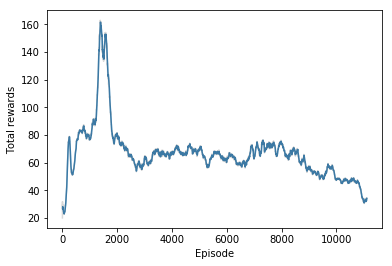

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

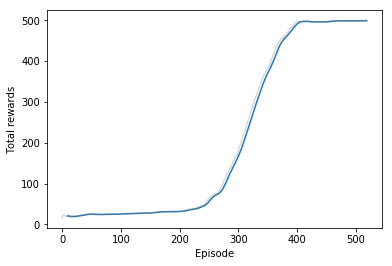

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

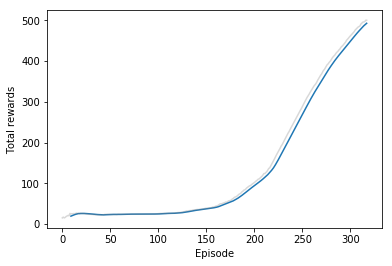

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

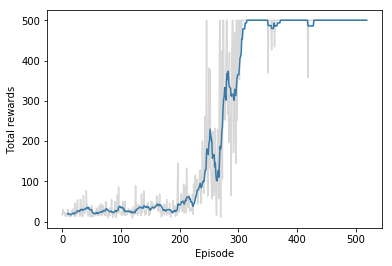

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

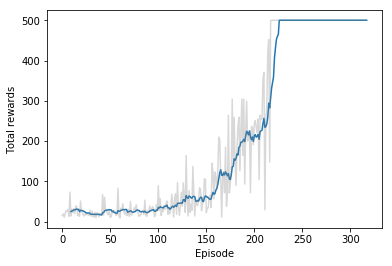

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

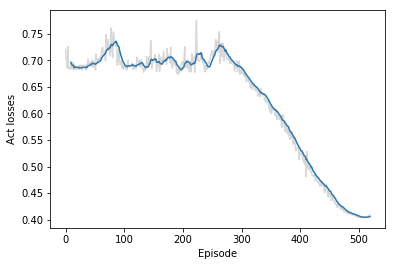

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

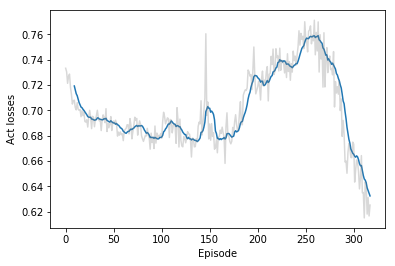

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

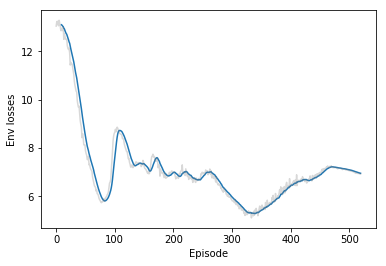

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

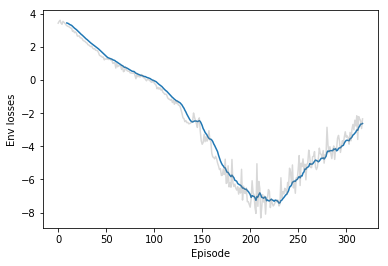

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

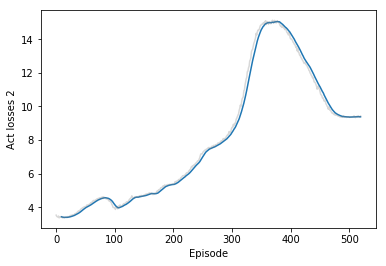

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

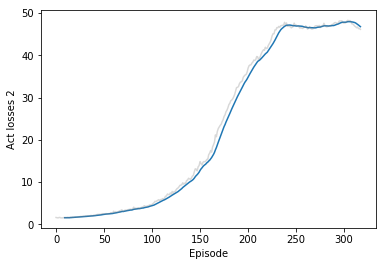

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
